# 选择**数据集Titanic-data**作为本项目分析对象。


### 探索性分析    
**首先，对各因素与生还情况的关系进行探索性分析**
这些因素包括：年龄、性别、舱级、舱位等已有的数据资料。

### 特征工程
**对各因素间的相互影响进行分析，并建立新的特征**

### 建模
**建模对生还情况进行预测分析**
<br>

## 0 导入库 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

%matplotlib inline
sns.set_style("white",{'axes.spines.right':False,'axes.spines.top':False,\
               'font.family': ['sans-serif'],'font.sans-serif': ['Microsoft Yahei']})

In [2]:
%config InlineBackend.figure_format = 'retina'    # this is preferable for retina display

## 1 导入数据
同时导入训练集和测试集，便于统一清洗和整理。

In [3]:
titanic_train = pd.read_csv('./titanic-data.csv')
titanic_test = pd.read_csv('./test.csv')

titanic_df = pd.concat([titanic_train,titanic_test],axis=0,sort=False,ignore_index=True)
titanic_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


统计该数据集中所有人数，以及生还的人数。  
从如上分析结果可知，**该数据集中共统计乘客人数1309人，其中生还数据有891条，因为测试集无此数据，有生还信息的数据中生还率为0.38**    
<br>
## 2 清洗数据

In [4]:
titanic_clean = titanic_df.copy()
print(titanic_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


In [5]:
print(pd.isnull(titanic_clean).sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [6]:
def missing_rate(df):
    return round(pd.isnull(df).sum()/pd.isnull(df).count()*100,2)

missing_rate(titanic_df)

PassengerId     0.00
Survived       31.93
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.09
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.08
Cabin          77.46
Embarked        0.15
dtype: float64

** Fare列有一个空值。**

In [7]:
print(titanic_clean[titanic_clean.Fare.isnull()])

      PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

      Parch Ticket  Fare Cabin Embarked  
1043      0   3701   NaN   NaN        S  


该缺失值的Pclass=3,Sex='male',且Embarked='S'，选择以此群体的平均值填空。

In [8]:
fare_missing = titanic_clean.loc[(titanic_clean.Pclass == 3) & \
                  (titanic_clean.Embarked == 'S') & (titanic_clean.Sex == "male"),:].Fare.mean()
titanic_clean.Fare.fillna(fare_missing, inplace=True)

#### 因列Cabin的值缺失率太高，暂以空值作为其中一种类型'U'。

In [9]:
titanic_clean['Cabin'].fillna('Unknown',inplace=True)
titanic_clean['Cabin_attr'] = titanic_clean['Cabin'].apply(lambda x:x[0])
titanic_clean['Cabin_attr'].value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin_attr, dtype: int64

In [10]:
# 检查'U'以避免因之前填空的‘Unknown'造成与原有的Cabin首字母存在冲突
titanic_clean.loc[(titanic_clean.Cabin != 'Unknown') & (titanic_clean['Cabin_attr'] == 'U'),'PassengerId'].count()

0

In [11]:
# 对于一开始没有Cabin的情况添加一列Cabin_if来区分
titanic_clean['Cabin_if'] = titanic_clean['Cabin_attr'].apply(lambda x: int(x != 'U'))

In [12]:
titanic_clean.groupby("Cabin_attr")['Fare'].mean().sort_values().sort_values(ascending=False)

Cabin_attr
B    122.383078
C    107.926598
E     54.564634
D     53.007339
A     41.244314
T     35.500000
U     19.126803
F     18.079367
G     14.205000
Name: Fare, dtype: float64

In [13]:
# 同一包厢首字母不同的舱级，平均价格存在差异
titanic_clean.groupby(["Cabin_attr","Pclass"])['Fare'].mean()

Cabin_attr  Pclass
A           1          41.244314
B           1         122.383078
C           1         107.926598
D           1          58.919065
            2          13.595833
E           1          63.464706
            2          11.587500
            3          11.000000
F           2          23.423077
            3           9.395838
G           3          14.205000
T           1          35.500000
U           1          70.268157
            2          21.394537
            3          13.351226
Name: Fare, dtype: float64

In [14]:
titanic_clean.groupby(["Pclass","Cabin_attr"])['Fare'].mean()

Pclass  Cabin_attr
1       A              41.244314
        B             122.383078
        C             107.926598
        D              58.919065
        E              63.464706
        T              35.500000
        U              70.268157
2       D              13.595833
        E              11.587500
        F              23.423077
        U              21.394537
3       E              11.000000
        F               9.395838
        G              14.205000
        U              13.351226
Name: Fare, dtype: float64

In [15]:
# 针对这些无Cabin的情况，根据Fare来确定
def cabin_estimator(pf):
    a = 0
    i, j = pf.split("-")
    i, j = float(i), float(j)
    if i == 1:
        if j < 38:
            a = "T"
        elif j>=38 and j<50:
            a = "A"
        elif j>=50 and j<60:
            a = "D"
        elif j>=60 and j<85:
            a = "E"
        elif j>=85 and j<115:
            a = "C"
        else:
            a = "B"
    if i == 2:
        if j < 12:
            a= "E"
        elif j>=12 and j<18:
            a = "D"
        else:
            a = "F"
    if i == 3:
        if j < 10:
            a = "F"
        elif j>=10 and j<13:
            a = "E"
        else:
            a = "G"
    return a

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
with_U = titanic_clean[titanic_clean.Cabin_attr == "U"]
without_U = titanic_clean[titanic_clean.Cabin_attr != "U"]

##applying cabin estimator function.
with_U['pf'] = with_U.Pclass.astype('str') + '-' + with_U.Fare.astype('str')
with_U['Cabin_attr'] = with_U.pf.apply(lambda x: cabin_estimator(x))
with_U.drop('pf',axis=1, inplace=True)

In [18]:
## getting back train. 
titanic_clean = pd.concat([with_U, without_U], axis=0)

## PassengerId helps us separate train and test. 
titanic_clean.sort_values(by = 'PassengerId', inplace=True)

In [19]:
titanic_clean.groupby(["Cabin_attr","Pclass"])['Fare'].count()

Cabin_attr  Pclass
A           1          30
B           1          77
C           1          96
D           1          46
            2          93
E           1          41
            2          48
            3          16
F           2         136
            3         476
G           3         217
T           1          33
Name: Fare, dtype: int64

#### Embarked列有两个空值，数量较少，查看一下详情。 

In [20]:
titanic_clean.loc[titanic_clean.Embarked.isnull(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_attr,Cabin_if
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,1


缺失该数据的为一等舱的女性，且Ticket号码、Cabin和Fare均一致，推测为同一批登船者。

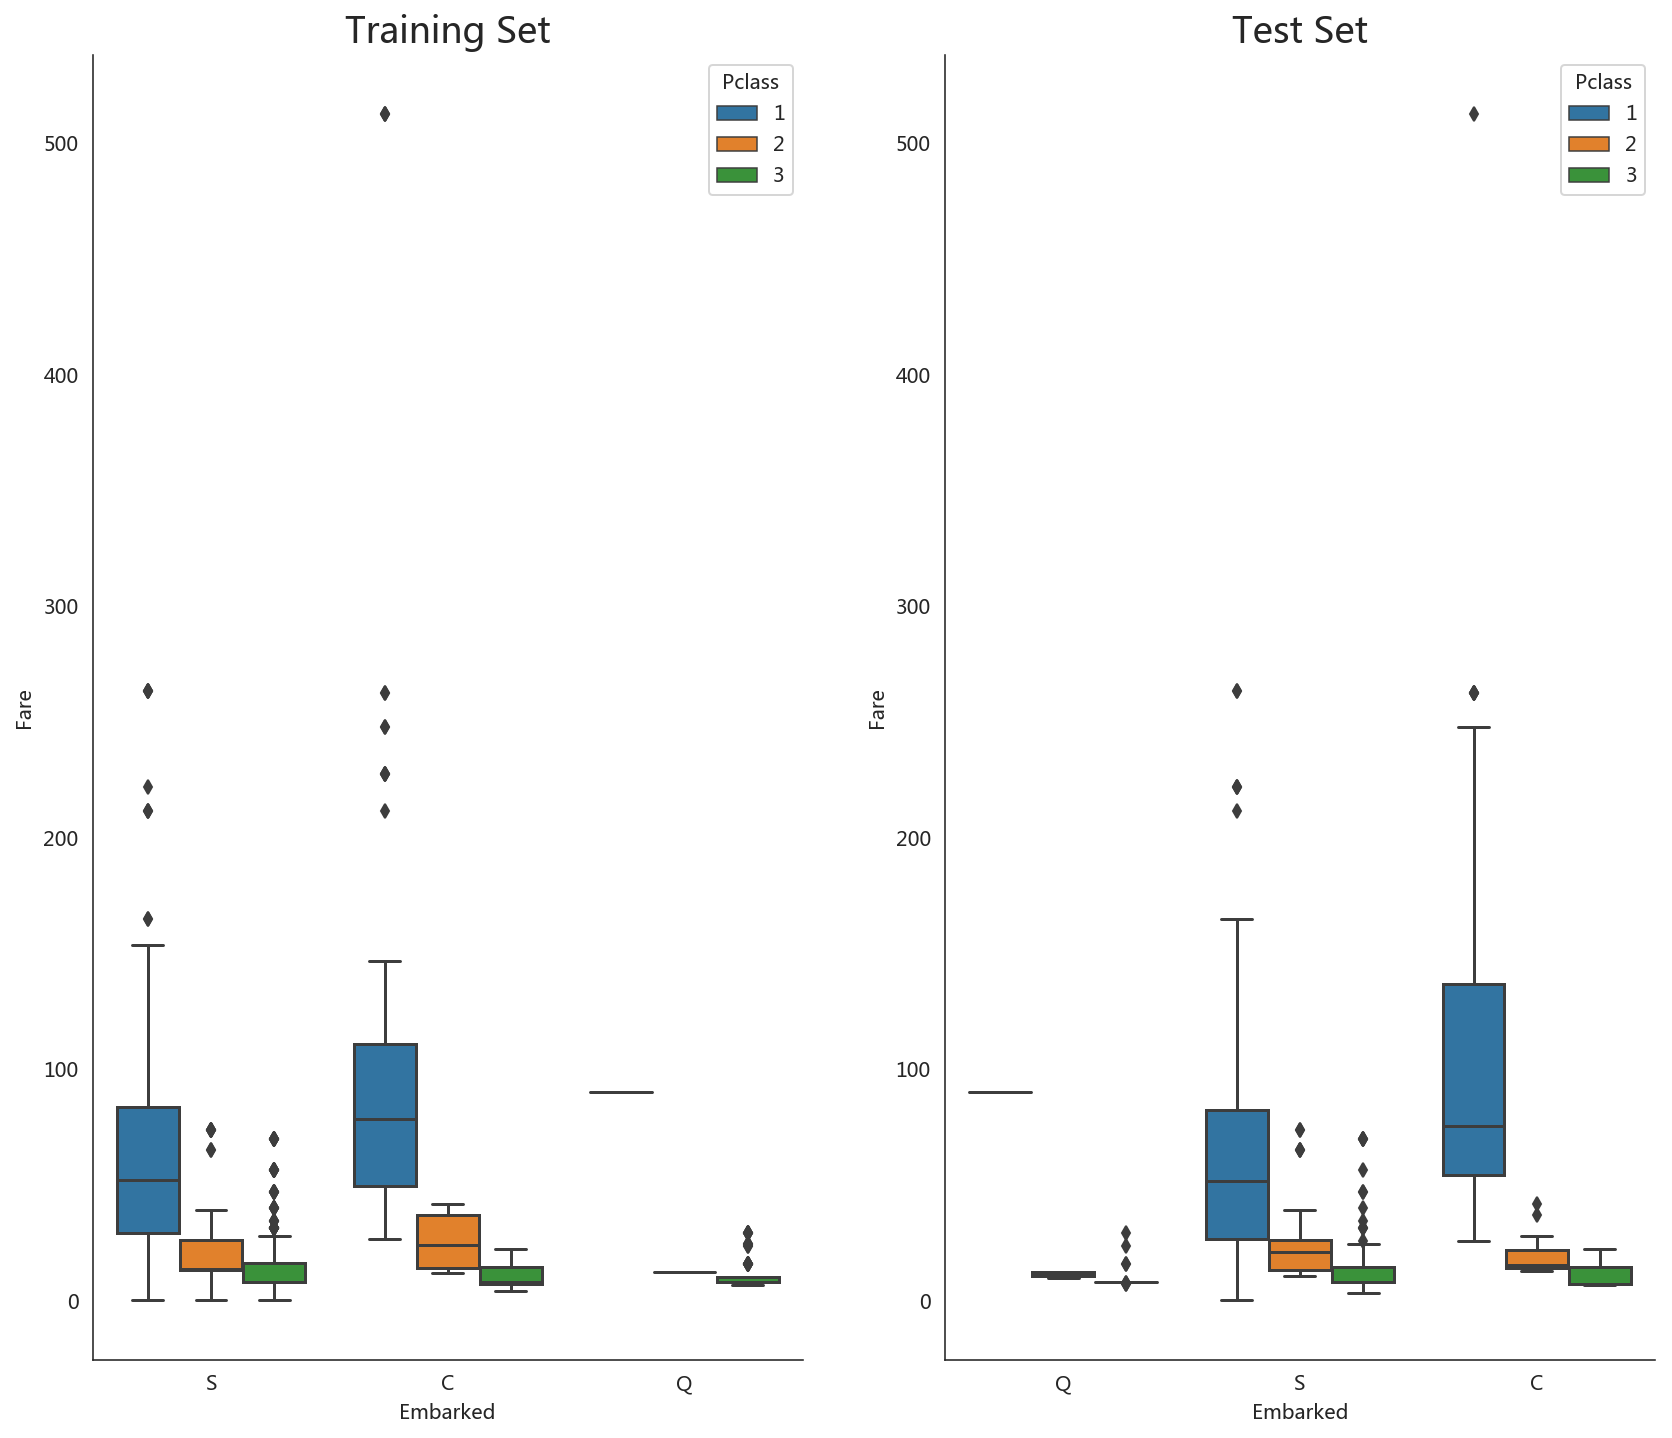

In [21]:
fig, ax = plt.subplots(figsize=(14,12),ncols=2)
ax1 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=titanic_train, ax = ax[0]);
ax2 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=titanic_test, ax = ax[1]);
ax1.set_title("Training Set", fontsize = 18)
ax2.set_title('Test Set',  fontsize = 18)
fig.show()

类似透视表的功能来展示具体数据：
```python
titanic_clean.pivot_table('Fare',['Pclass','Embarked','Cabin_attr'])
```

从上可看出，客舱号在B开头的是在C或者S登船，从票价上来看，与在C登船的平均票价比较相符，Emabrked以C来填空。

In [22]:
# Replacing the null values in the Embarked column with the mode. 
titanic_clean.Embarked.fillna("C", inplace=True)

#titanic_clean.loc[titanic_clean.Embarked.isnull(),'Embarked'] = 'C'

#### Age空值率相对较高。  
从是否生还、名字信息及位于何等舱等不同情况下分析Age是否存在差异。

In [23]:
print ("Train age missing value: " + str(round((titanic_clean[:891].Age.isnull().sum()/len(titanic_clean[:891]))*100,2))+str("%"))
print ("Test age missing value: " + str(round((titanic_clean[891:].Age.isnull().sum()/len(titanic_clean[891:]))*100,2))+str("%"))

Train age missing value: 19.87%
Test age missing value: 20.57%


In [24]:
titanic_clean.loc[titanic_clean.Age.isnull(),:].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_if
count,263.000000,177.000000,263.000000,0.0,263.000000,263.000000,263.000000,263.000000
mean,653.558935,0.293785,2.642586,NaN,0.482890,0.243346,19.823319,0.087452
std,380.161812,0.456787,0.726812,NaN,1.448443,0.949941,27.550667,0.283036
min,6.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,335.500000,0.000000,3.000000,NaN,0.000000,0.000000,7.750000,0.000000
50%,630.000000,0.000000,3.000000,NaN,0.000000,0.000000,8.050000,0.000000
75%,999.500000,1.000000,3.000000,NaN,0.000000,0.000000,22.804150,0.000000
max,1309.000000,1.000000,3.000000,NaN,8.000000,9.000000,227.525000,1.000000


缺失年龄数据的部分，生还率0.29低于整体的0.38；   
Pclass平均值为2.6要大于整体的2.3，且25%值已经是3.0；  
Fare在平均值、四分位及最大值方面均低于整体，但标准差会更小，说明数据更为集中在中下水平。

对Name列中的称呼抬头进行提取，有诸如性别、头衔等信息。   
其中，头衔信息对Age的缺失值填空有较大参考。

In [25]:
titanic_clean.Name.sample(10)

371                         Wiklund, Mr. Jakob Alfred
867              Roebling, Mr. Washington Augustus II
959                   Tucker, Mr. Gilbert Milligan Jr
856        Wick, Mrs. George Dennick (Mary Hitchcock)
105                             Mionoff, Mr. Stoytcho
159                        Sage, Master. Thomas Henry
887                      Graham, Miss. Margaret Edith
424                       Rosblom, Mr. Viktor Richard
328    Goldsmith, Mrs. Frank John (Emily Alice Brown)
0                             Braund, Mr. Owen Harris
Name: Name, dtype: object

In [26]:
titanic_clean['title'] = titanic_clean['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())
pd.crosstab(titanic_clean.title,titanic_clean.Sex)

Sex,female,male
title,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


只有title为Dr时出现同时存在男性和女性的情况,且人数较少，查看一下具体情况。

In [27]:
titanic_clean.loc[(titanic_clean.title == 'Dr'),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_attr,Cabin_if,title
245,246,0.0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,C,1,Dr
317,318,0.0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,Unknown,S,D,0,Dr
398,399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,Unknown,S,E,0,Dr
632,633,1.0,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,B,1,Dr
660,661,1.0,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,Unknown,S,B,0,Dr
766,767,0.0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,Unknown,C,A,0,Dr
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,D,1,Dr
1184,1185,NaN,1,"Dodge, Dr. Washington",male,53.0,1,1,33638,81.8583,A34,S,A,1,Dr


仅有一位男性的年龄缺失，对于Dr职位的人来说，在年龄方面会稍长一些，从上面的数据可知多数在50岁左右，少数较为年轻，对该年龄空值以同性别的平均年龄进行填空。

In [28]:
titanic_clean.loc[titanic_clean.Age.isnull() & (titanic_clean.title == 'Dr'),'Age'] = \
titanic_clean.loc[(titanic_clean.Sex == 'male') & (titanic_clean.title == 'Dr'),'Age'].mean()

In [29]:
titanic_clean.pivot_table('Age',['title','Pclass'])

Age
title        Pclass           
Capt         1       70.000000
Col          1       54.000000
Don          1       40.000000
Dona         1       39.000000
Dr           1       45.111111
             2       38.500000
Jonkheer     1       38.000000
Lady         1       48.000000
Major        1       48.500000
Master       1        6.984000
             2        2.757273
             3        6.090000
Miss         1       30.338983
             2       20.717083
             3       17.360874
Mlle         1       24.000000
Mme          1       24.000000
Mr           1       41.450758
             2       32.346715
             3       28.318910
Mrs          1       43.208955
             2       33.518519
             3       32.326531
Ms           2       28.000000
Rev          2       41.250000
Sir          1       49.000000
the Countess 1       33.000000

In [30]:
pd.crosstab(titanic_clean.title,titanic_clean.Pclass)

Pclass,1,2,3
title,,,
Capt,1,0,0
Col,4,0,0
Don,1,0,0
Dona,1,0,0
Dr,6,2,0
Jonkheer,1,0,0
Lady,1,0,0
Major,2,0,0
Master,5,11,45


In [31]:
pd.crosstab(titanic_clean.loc[titanic_clean.Age.isnull(),:].title,\
            titanic_clean.loc[titanic_clean.Age.isnull(),:].Pclass)

Pclass,1,2,3
title,,,
Master,0,0,8
Miss,1,2,47
Mr,27,13,136
Mrs,10,1,16
Ms,0,0,1


综上分析，Mr, Mrs和Miss各等舱的人数均较多，且不同舱的平均年龄存在一定差异，考虑以不同title和Pclass的平均值填空；   
Master仅缺3等舱的Age数据，且3等舱人数达45人，考虑以三等舱的该头衔的平均值填空；  
而Ms人数仅有2位,空值按该舱级的女性平均值填空。

In [32]:
def get_mean(tl,cls):
    return titanic_clean.loc[(titanic_clean.title == tl) & (titanic_clean.Pclass == cls),'Age'].mean()

In [33]:
title_fill = ['Master','Miss','Mr','Mrs']
Pclass = [1,2,3]
titanic_clean.fillAge = None

for i in title_fill:
    for j in Pclass:
        titanic_clean.loc[(titanic_clean.title == i) & (titanic_clean.Pclass == j) & \
                          (titanic_clean.Age.isnull()),'Age'] = get_mean(i,j)

In [34]:
titanic_clean.loc[(titanic_clean.title == 'Ms') & (titanic_clean.Age.isnull()),'Age'] = \
titanic_clean.loc[(titanic_clean.Sex == 'female') & (titanic_clean.Pclass == 3),'Age'].mean()

In [35]:
#不同title的生还率与不同title的人数的情况
titanic_clean.pivot_table('Survived',['title']).reset_index().merge(\
                                                                    titanic_clean.groupby('title')['Survived'].count().reset_index(),\
                                                                    how='outer',on='title')

,title,Survived_x,Survived_y
0,Capt,0.000000,1
1,Col,0.500000,2
2,Don,0.000000,1
3,Dr,0.428571,7
4,Jonkheer,0.000000,1
5,Lady,1.000000,1
6,Major,0.500000,2
7,Master,0.575000,40
8,Miss,0.697802,182
9,Mlle,1.000000,2


In [36]:
titanic_clean[titanic_clean.title=='Dona']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_attr,Cabin_if,title
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,C,1,Dona


基本上，男性、女性中人数较少的类别生还率均比数量较多的类别的生还率更高，保留人数较多的类别Mr,Miss,Mrs和Master,其他类别按性别不同分别划为selected_male和selected_female.

In [37]:
titanic_clean.title.replace({'Mme':'Miss','Ms':'Miss','Mlle':'Miss'},inplace=True)
titanic_clean.title.replace('Jonkheer','Mr',inplace=True)

In [38]:
m_title = ['Don', 'Rev', 'Dr', 'Major', 'Sir', 'Col', 'Capt']
f_title = ['Lady', 'the Countess','Dona']   # 女性中'Dr'的情况单独处理

titanic_clean.loc[(titanic_clean.Sex == 'female') & (titanic_clean.title == 'Dr'),'title'] ='selected_female'

def change_title(titles,targt):
    for t in titles:
        titanic_clean.loc[titanic_clean.title == t,'title'] = targt

change_title(m_title,'selected_male')
change_title(f_title,'selected_female')

In [39]:
titanic_clean.pivot_table('Survived',['title']).sort_values(by='Survived')

,Survived
title,
Mr,0.156371
selected_male,0.263158
Master,0.575000
Miss,0.704301
Mrs,0.792000
selected_female,1.000000


In [40]:
print(titanic_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 15 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Cabin_attr     1309 non-null object
Cabin_if       1309 non-null int64
title          1309 non-null object
dtypes: float64(3), int64(5), object(7)
memory usage: 163.6+ KB
None


至此，数据清洗完成。  
<br>


## 3 数据探索性分析
  
### 问题一
生还的人员中年龄段分布情况以及各年龄段的生还情况？

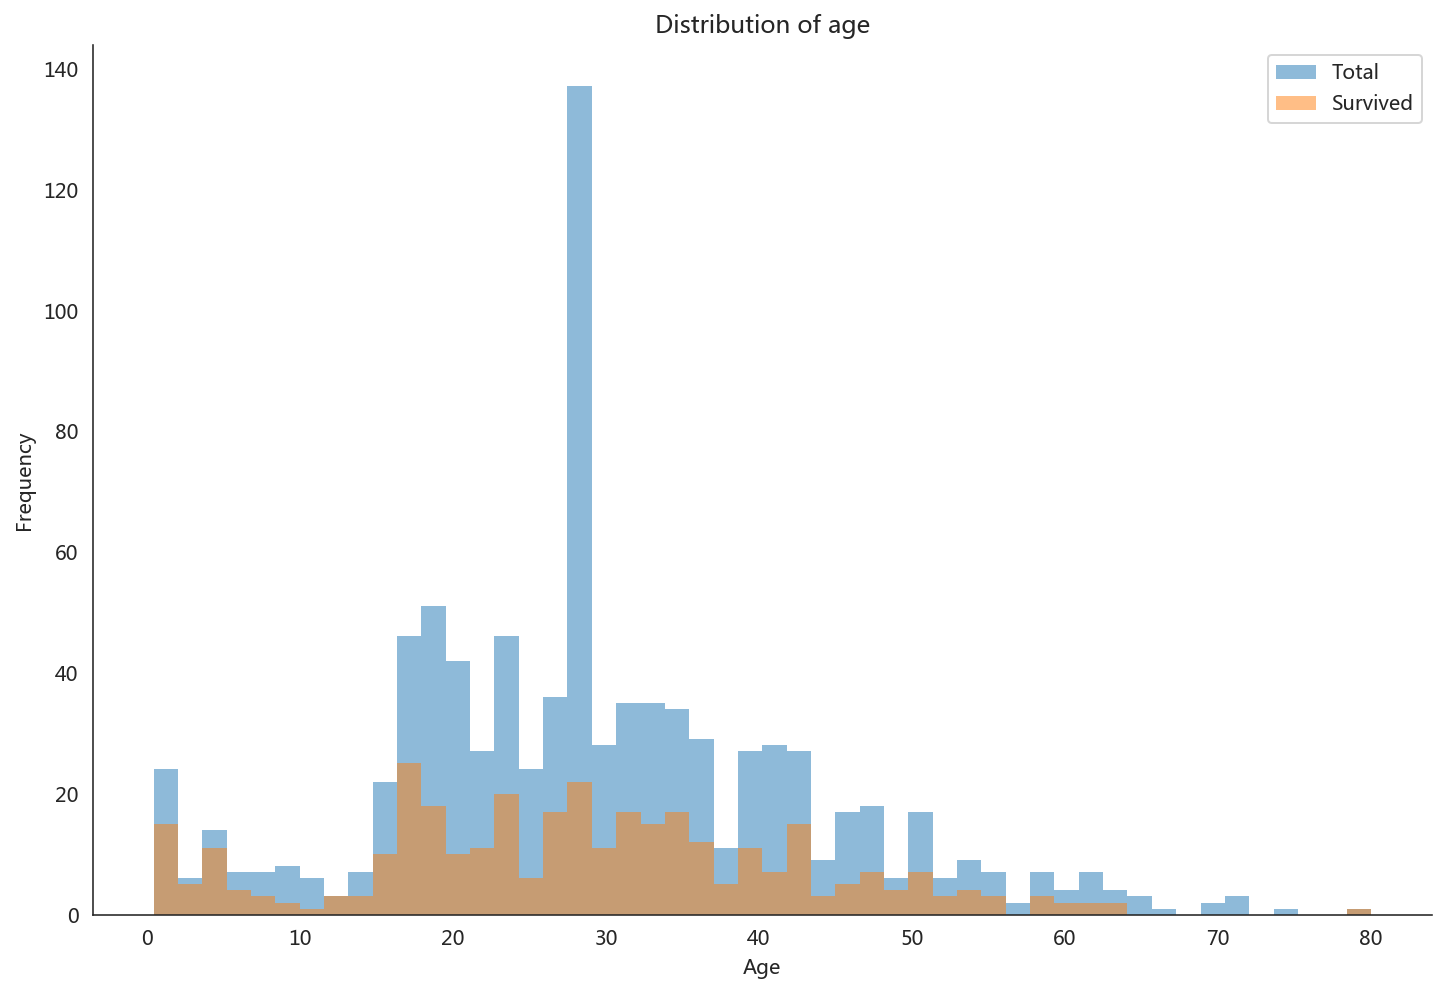

In [41]:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(titanic_clean[:891].Age,edgecolor='None',alpha=.5,bins=50, label='Total')
ax.hist(titanic_clean.loc[titanic_clean['Survived']==1,'Age'],edgecolor='None',alpha=.5,bins=50,label='Survived')
ax.set(title='Distribution of age',ylabel='Frequency',xlabel='Age')
plt.legend(loc='best');


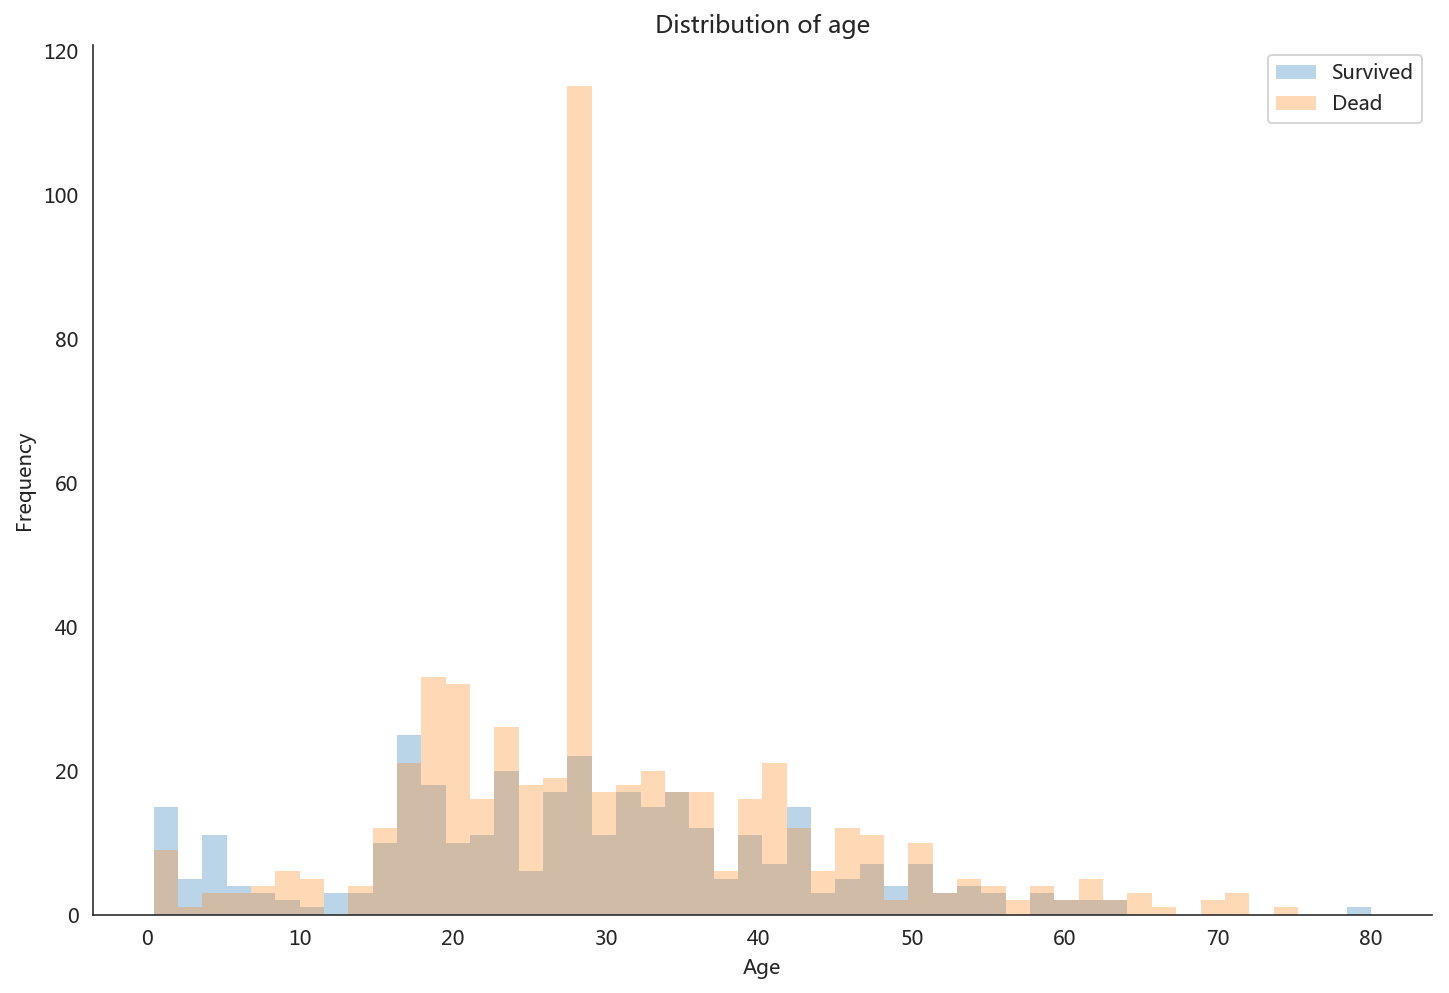

In [42]:
agehist=pd.concat([titanic_clean.loc[titanic_clean.Survived==1,'Age'],\
                   titanic_clean.loc[titanic_clean.Survived==0,'Age']],axis=1)
agehist.columns=['Survived','Dead']
ax=agehist.plot(kind='hist',bins=50,figsize=(12,8),alpha=0.3,edgecolor='none')
ax.set(title='Distribution of age',ylabel='Frequency',xlabel='Age');

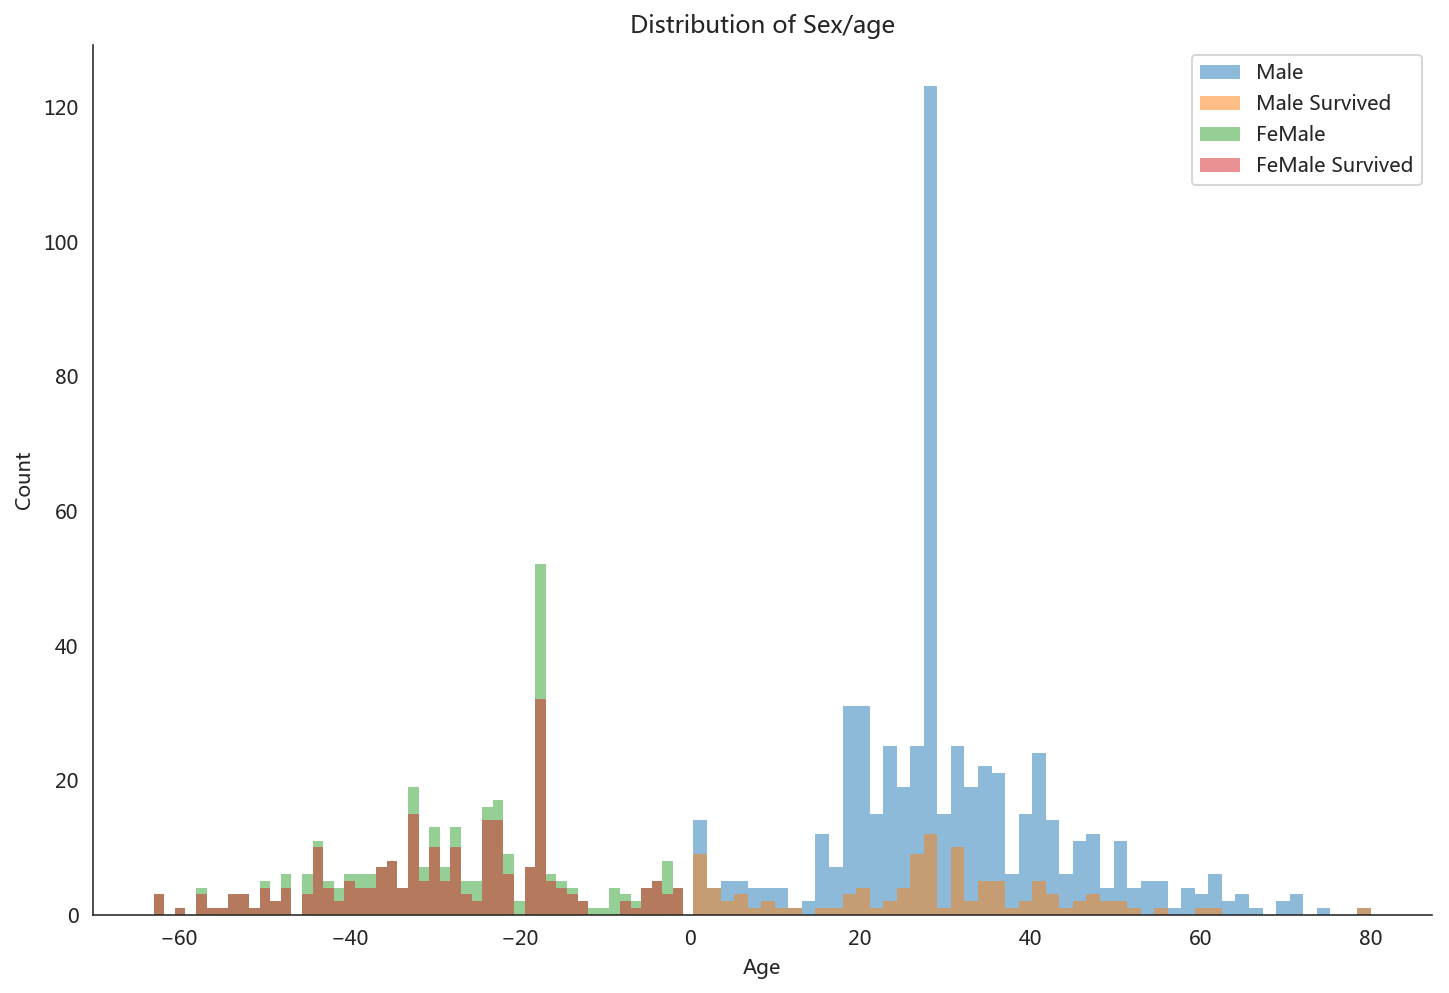

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(titanic_clean[:891].loc[titanic_clean.Sex=='male','Age'],edgecolor='None',alpha=.5,bins=50, label='Male')
ax.hist(titanic_clean[:891].loc[(titanic_clean.Sex=='male') & (titanic_clean.Survived==1),'Age'],edgecolor='None',alpha=.5,bins=50, label='Male Survived')
ax.hist(-titanic_clean[:891].loc[titanic_clean.Sex=='female','Age'],edgecolor='None',alpha=.5,bins=50, label='FeMale')
ax.hist(-titanic_clean[:891].loc[(titanic_clean.Sex=='female') & (titanic_clean.Survived==1),'Age'],edgecolor='None',alpha=.5,bins=50, label='FeMale Survived')
ax.set(title='Distribution of Sex/age',ylabel='Count',xlabel='Age')
plt.legend(loc='best');

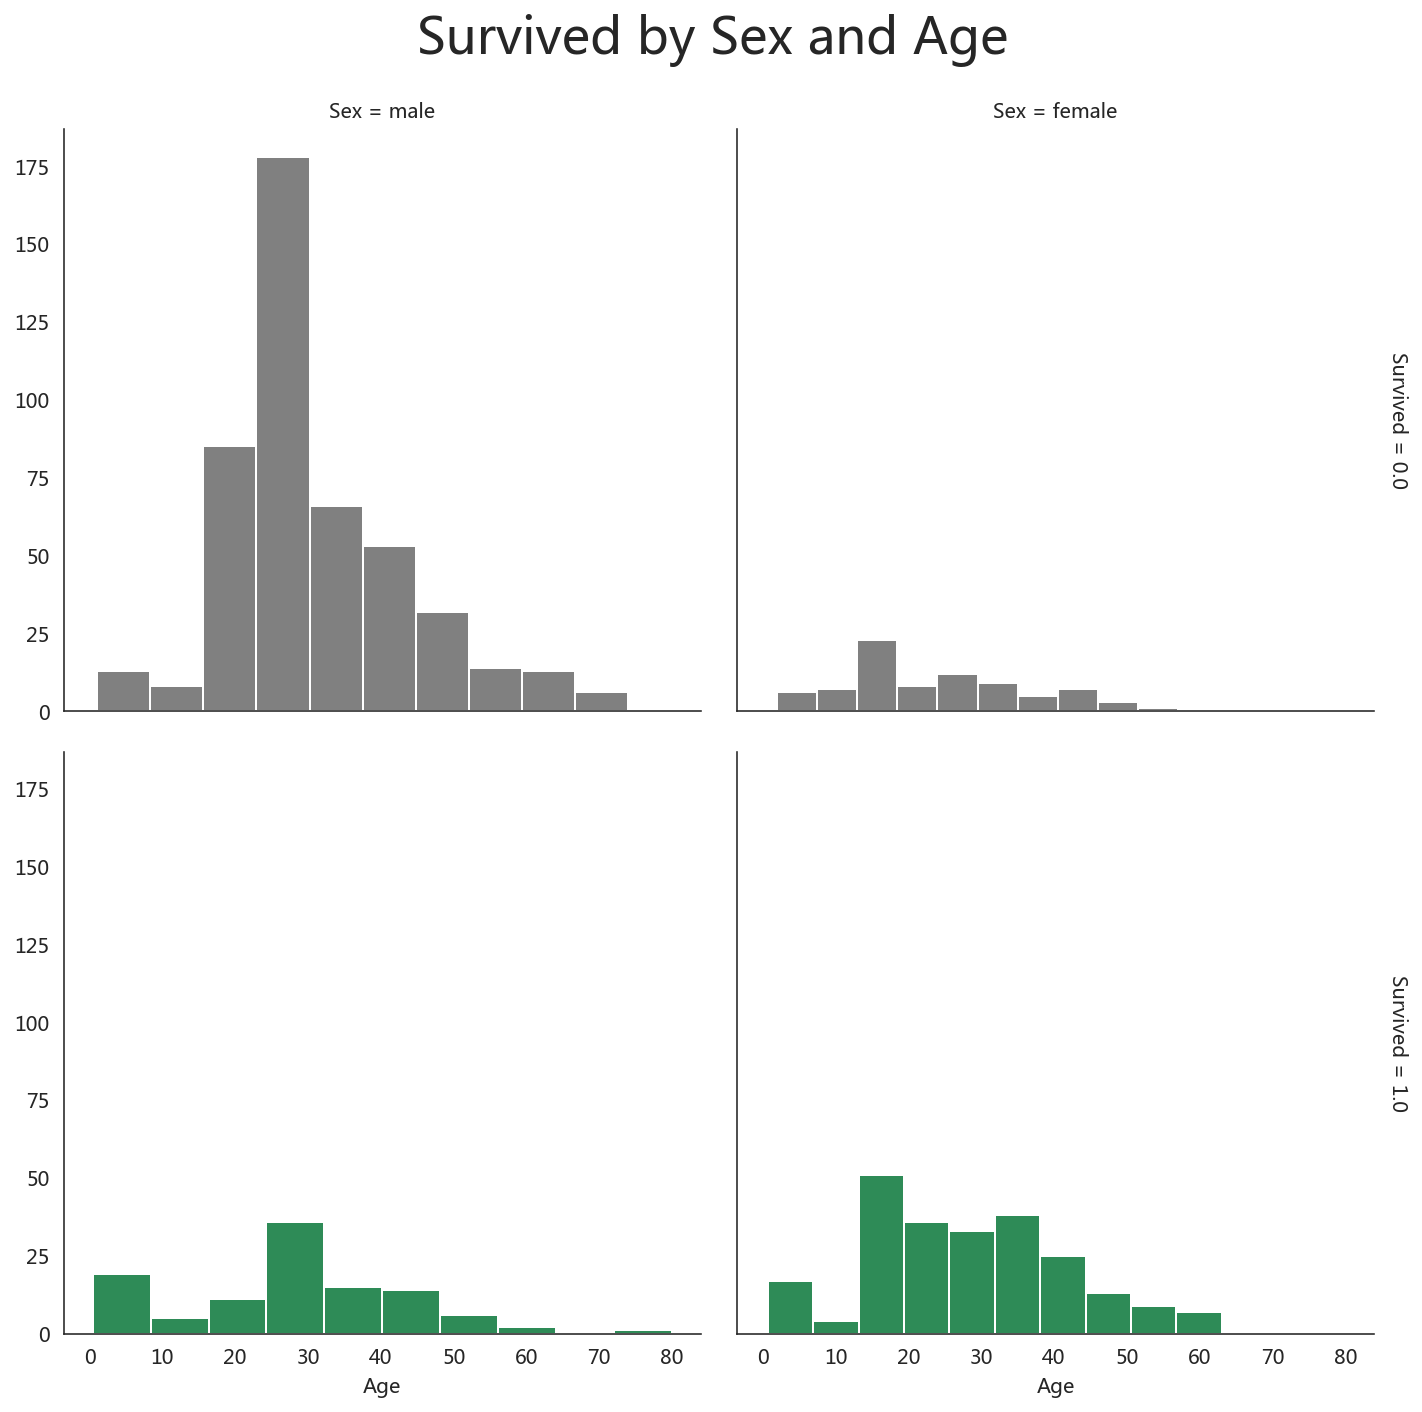

In [44]:
train = titanic_clean[:891]
pal = {1:"seagreen", 0:"gray"}
g = sns.FacetGrid(train, size=5, col="Sex", row="Survived", margin_titles=True, hue = "Survived", palette=pal)
g = g.map(plt.hist, "Age", edgecolor = 'white');
g.fig.suptitle("Survived by Sex and Age", size = 25)
plt.subplots_adjust(top=0.90)

In [45]:
#将年龄进行分段来分析
def age_cut(df):
    return pd.cut(df.loc[:,'Age'],bins=[0,5,12,18,35,60,80],
                  labels=['Baby','Child','Teenager','Young Adult','Adult','Senior'],
                  right=True,precision=1)

titanic_clean.loc[:,'age_cut'] = age_cut(titanic_clean)

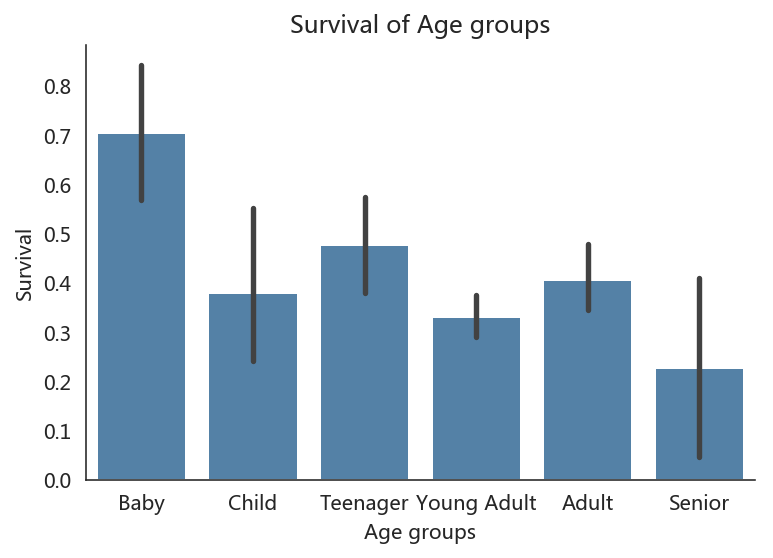

In [46]:
sns.barplot(x='age_cut',y='Survived',data=titanic_clean[:891],color='steelblue')
plt.title('Survival of Age groups')
plt.xlabel('Age groups')
plt.ylabel('Survival')
plt.show();

相比于其他年龄段人员，5岁以下的婴幼儿的生还率最高,其次是青少年，长者的生还率最低。

### 问题二  
不同性别的生还率是多少？生还人员中性别比例状况？

In [47]:
def get_pct(arr):
    return arr.count()/len(titanic_clean)

titanic_clean.groupby('Sex')['PassengerId'].agg([('Cnt','count'),('Percentage',get_pct)])

,Cnt,Percentage
Sex,,
female,466,0.355997
male,843,0.644003


In [48]:
def get_pct(arr):
    return arr.count()/len(titanic_clean[:891])

titanic_clean.groupby('Sex')['Survived'].agg([('Cnt','count'),('Percentage',get_pct),('Survival','mean')])

,Cnt,Percentage,Survival
Sex,,,
female,314,0.352413,0.742038
male,577,0.647587,0.188908


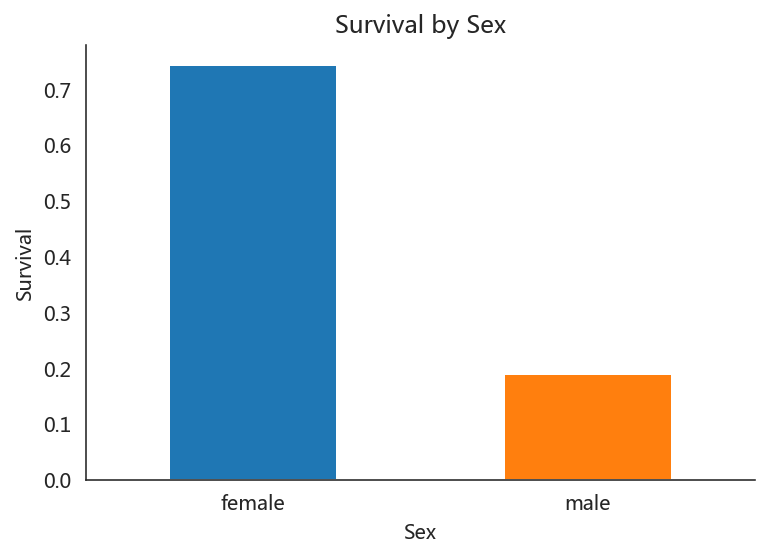

In [49]:
titanic_clean.groupby('Sex')['Survived'].mean().plot(kind='bar')
plt.title('Survival by Sex')
plt.xticks(rotation=0)
plt.ylabel('Survival');

基于测试数据集，女性生还率高达74%，远高于男性的19%。 
<br>  
对不同性别的生还率差异做t-test,检验是否存在显著差异。

In [50]:
train = titanic_clean[:891]
# separating male and female dataframe. 
male = train[train['Sex'] == 'male']
female = train[train['Sex'] == 'female']

# getting 50 random sample for male and female. 
import random
male_sample = random.sample(list(male['Survived']),int(0.2*len(male)))
female_sample = random.sample(list(female['Survived']),int(0.2*len(female)))

# Taking a sample means of survival feature from male and female
male_sample_mean = np.mean(male_sample)
female_sample_mean = np.mean(female_sample)

# Print them out
print ("Male sample mean: " + str(male_sample_mean))
print ("Female sample mean: " + str(female_sample_mean))

Male sample mean: 0.22608695652173913
Female sample mean: 0.7419354838709677


In [51]:
import scipy.stats as stats

print(stats.ttest_ind(male_sample, female_sample))
print ("This is the p-value when we break it into standard form: " + \
       format(stats.ttest_ind(male_sample, female_sample).pvalue, '.16f'))

Ttest_indResult(statistic=-7.6572681812517995, pvalue=1.2357162935949151e-12)
This is the p-value when we break it into standard form: 0.0000000000012357


In [52]:
#计算不同性别是否生还的比例
def get_survival(x1,x2):
    survived_sex = titanic_clean.loc[(titanic_clean.Survived==x1) & (titanic_clean.Sex==x2),'Survived'].count()
    return survived_sex / titanic_train.Sex.count()

vals = np.array([[get_survival(1,'female'),get_survival(1,'male')],[get_survival(0,'female'),get_survival(0,'male')]])
print(vals)

[[0.26150393 0.12233446]
 [0.09090909 0.52525253]]


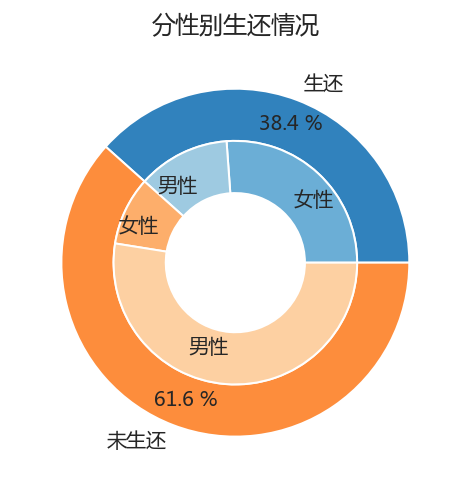

In [53]:
fig, ax = plt.subplots()

size = 0.3
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.array([0, 5]))
inner_colors = cmap(np.array([1, 2, 6, 7]))

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors, labels=['生还','未生还'],rotatelabels=0,
       autopct='% 3.1f %%', pctdistance=0.85, wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors, labels=['女性','男性','女性','男性'],labeldistance=0.7,\
      wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title="分性别生还情况")

plt.show();

从如上饼图可看出，基于现有的数据集，整体生还率为38.4%，生还女性占总体的26.2%，高于男性, 未生还的男性占总体的53%。

### 问题三  
哪个舱位的人员生还率最高？

In [54]:
titanic_clean.pivot_table('Survived',index='Pclass',margins=True)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363
All,0.383838


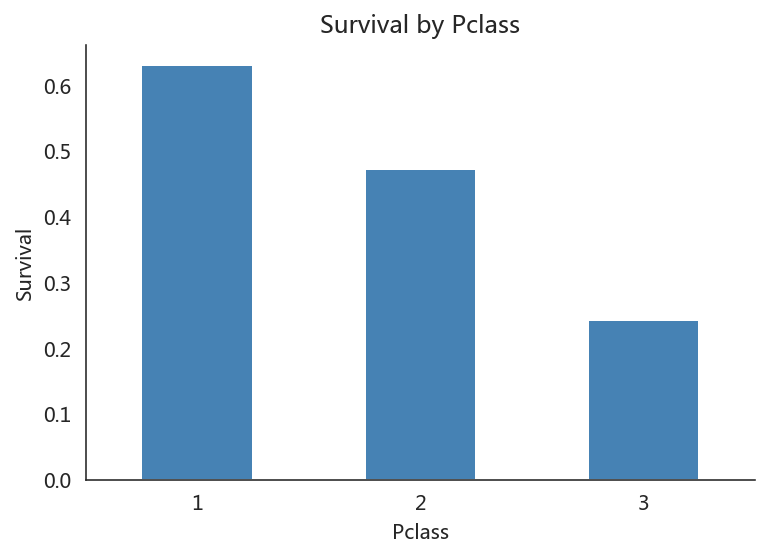

In [55]:
titanic_clean.groupby('Pclass')['Survived'].mean().plot(kind='bar',color='steelblue')
plt.title('Survival by Pclass')
plt.xticks(rotation=0)
plt.ylabel('Survival');

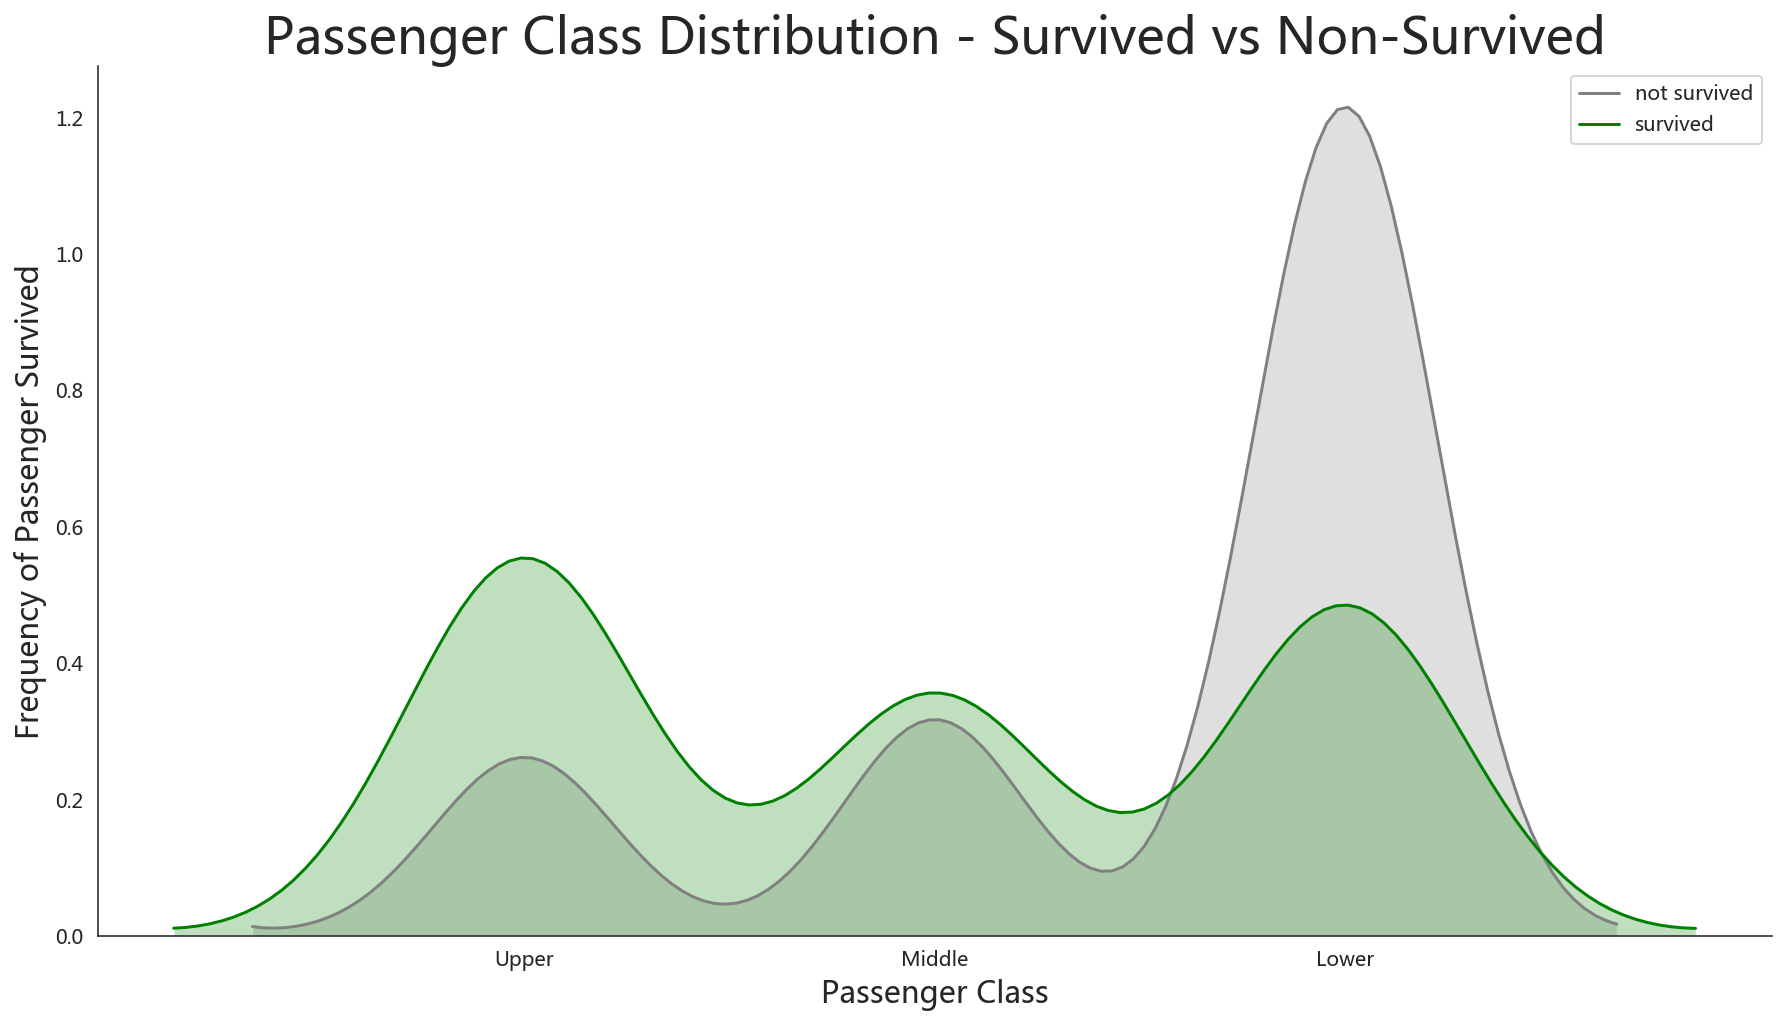

In [56]:
train = titanic_clean[:891]
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)

ax=sns.kdeplot(train.Pclass[train.Survived == 0] , 
               color='gray',
               shade=True,
               label='not survived')
ax=sns.kdeplot(train.loc[(train['Survived'] == 1),'Pclass'] , 
               color='g',
               shade=True, 
               label='survived')
plt.title('Passenger Class Distribution - Survived vs Non-Survived', fontsize = 25)
plt.ylabel("Frequency of Passenger Survived", fontsize = 15)
plt.xlabel("Passenger Class", fontsize = 15)
## Converting xticks into words for better understanding
labels = ['Upper', 'Middle', 'Lower']
plt.xticks(sorted(train.Pclass.unique()), labels);

如预期所料，**一等舱的生还最高**，为63%，生还率顺序为一等舱>二等舱>三等舱。  

### 问题四  
其他因素对生还率的影响？  
包括Fare, Parch, SlibSp, Title, Emabrked, Cabin等。  
<br>
**Fare**

Text(0.5, 0, 'Fare')

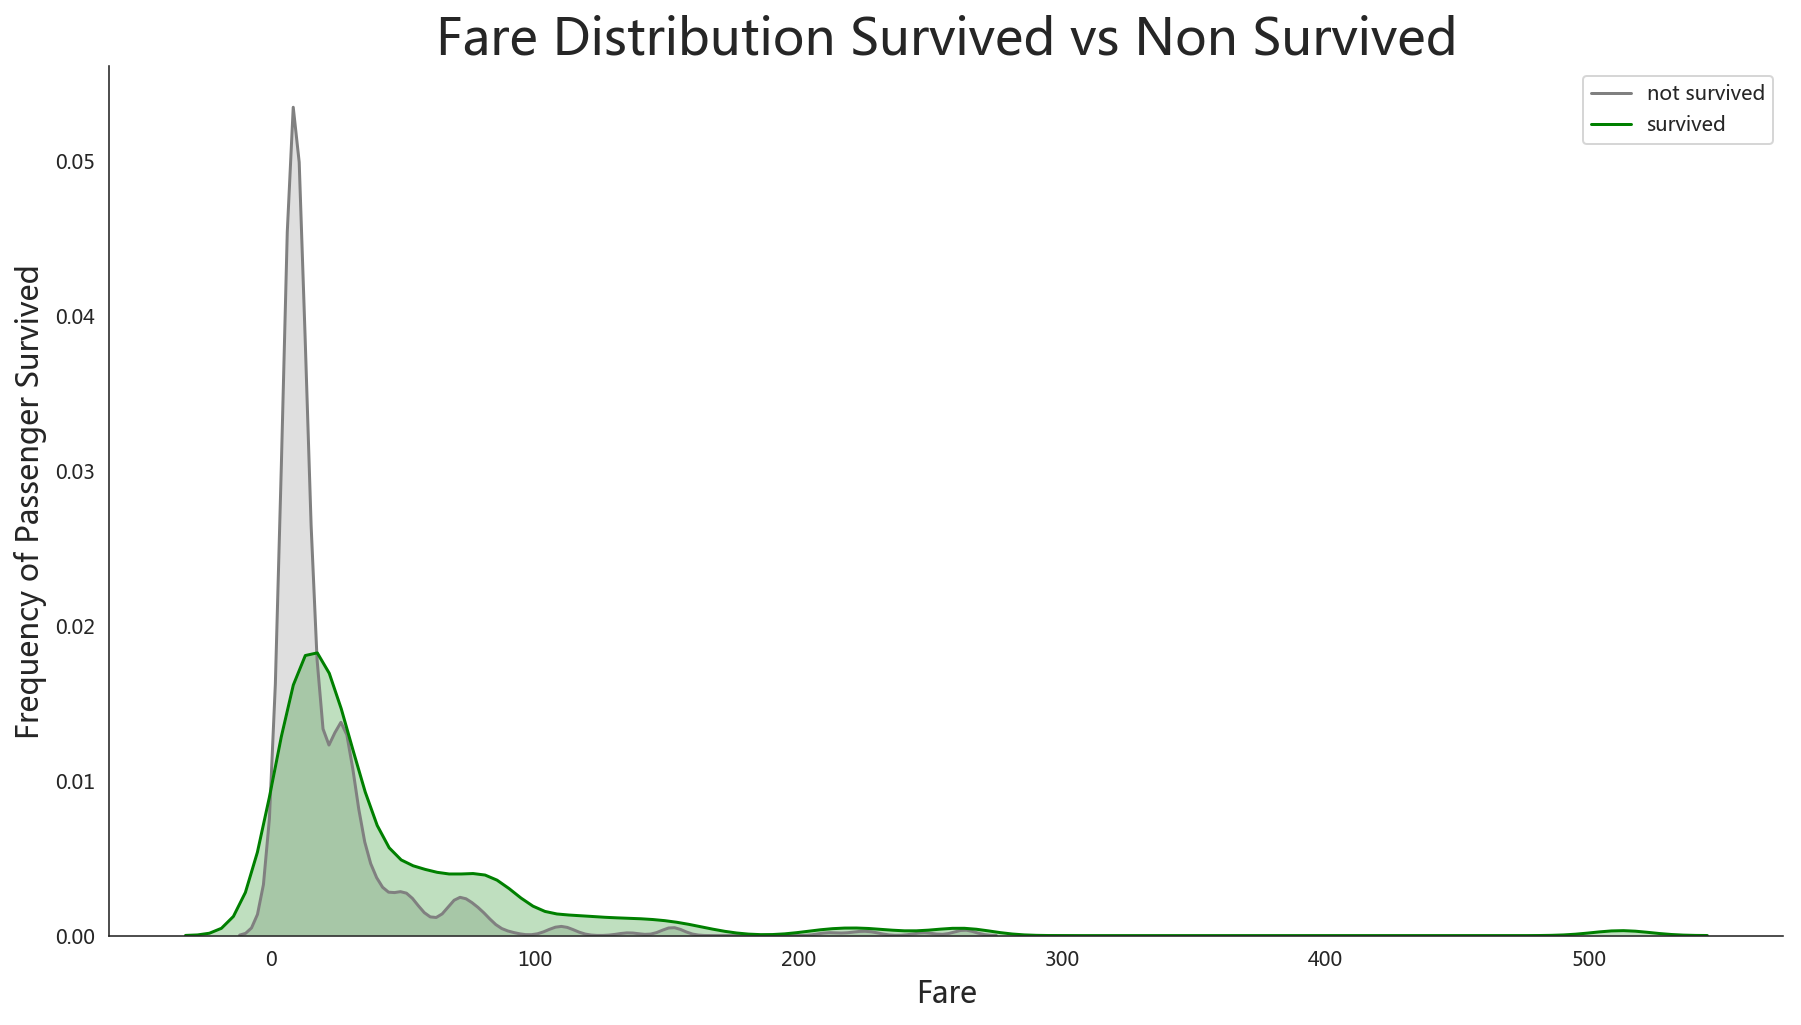

In [57]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)
ax=sns.kdeplot(train.loc[(train['Survived'] == 0),'Fare'] , color='gray',shade=True,label='not survived')
ax=sns.kdeplot(train.loc[(train['Survived'] == 1),'Fare'] , color='g',shade=True, label='survived')
plt.title('Fare Distribution Survived vs Non Survived', fontsize = 25)
plt.ylabel("Frequency of Passenger Survived", fontsize = 15)
plt.xlabel("Fare", fontsize = 15)

In [58]:
#train[train.Fare > 280]    # 暂不做删除处理 

**Parch**

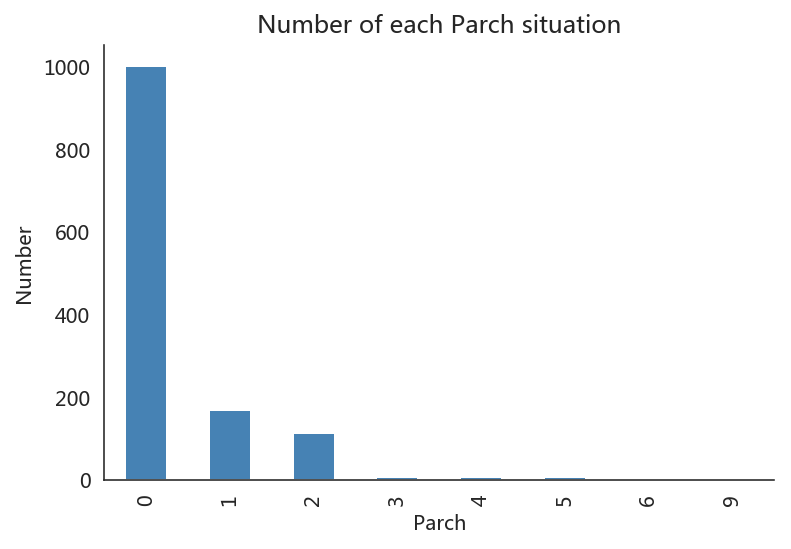

In [59]:
num_Parch = titanic_clean.groupby('Parch')['PassengerId'].count()
ax=num_Parch.plot(kind='bar',color='steelblue')
ax.set(title="Number of each Parch situation",xlabel='Parch',ylabel='Number');

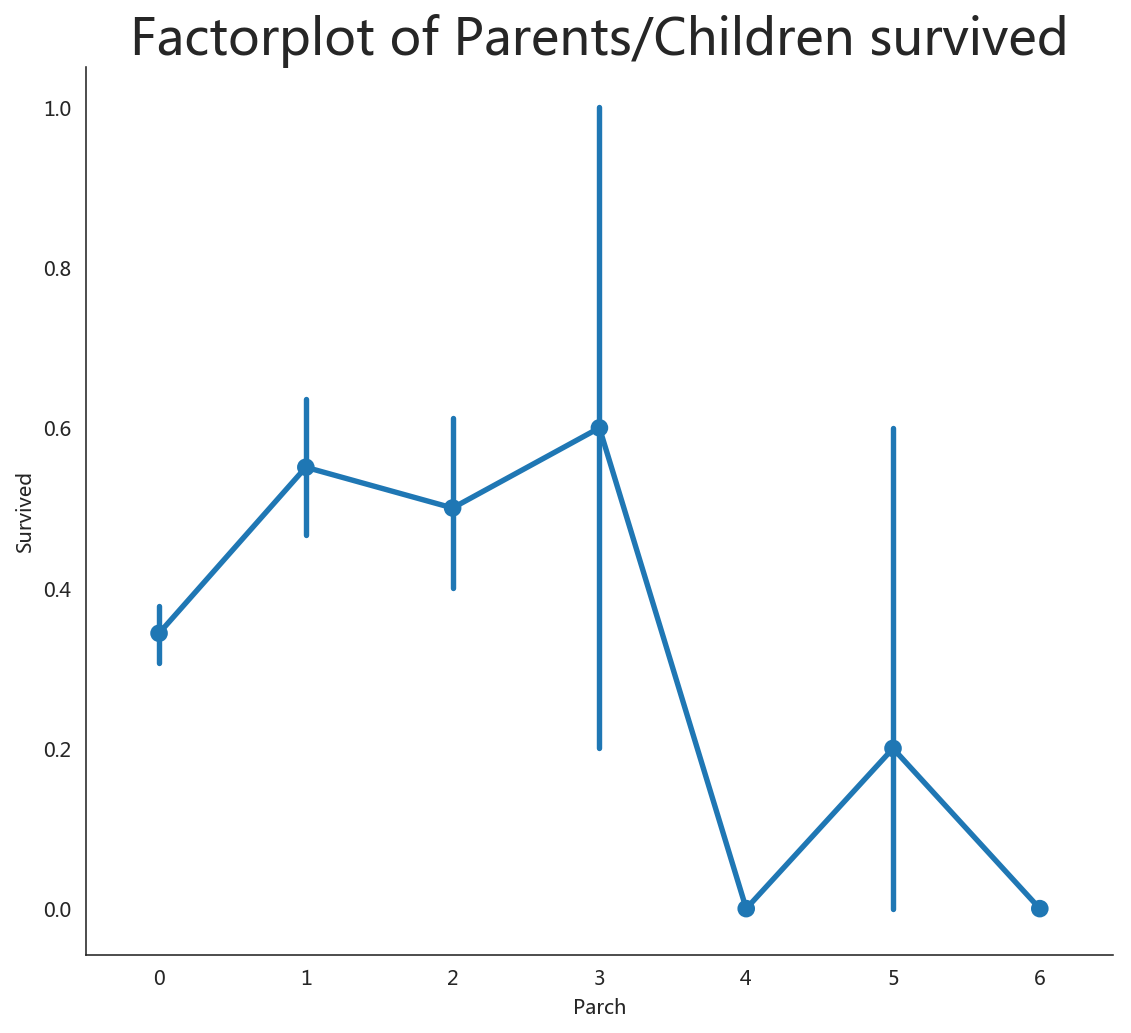

In [60]:
sns.factorplot(x = "Parch", y = "Survived", data = train, kind = "point",size = 8)
plt.title("Factorplot of Parents/Children survived", fontsize = 25)
plt.subplots_adjust(top=0.85)

绝大多数人没有双亲或小孩陪同出行，部分人有1－2个双亲或小孩陪同，而陪同超过2个人的情况非常少。  
虽然有3个陪同的生还率最高，但因为样本仅有5个人，且标准差较大，不足以作出有3个双亲或小孩陪同的人生还率就很高的推论；   
而有1－2个陪同的生还率较高，可能原因是小孩优先存活，同时需要有双亲陪同。

**SibSp**

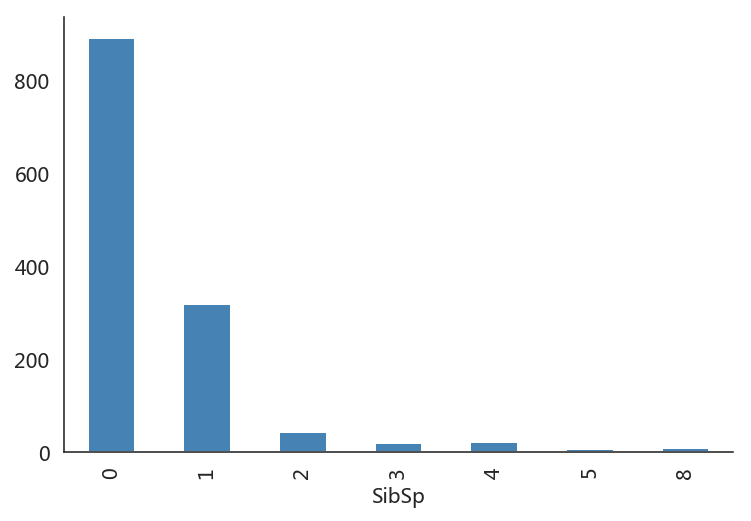

In [61]:
num_SibSp = titanic_clean.groupby('SibSp')['PassengerId'].count()
num_SibSp.plot(kind='bar',color='steelblue');

与Parch情况类似，没有兄弟姐妹或配偶陪同出行的人员占绝大多数，其次是有1人陪同的情况，多位兄弟姐妹或配偶出行的情况较少。

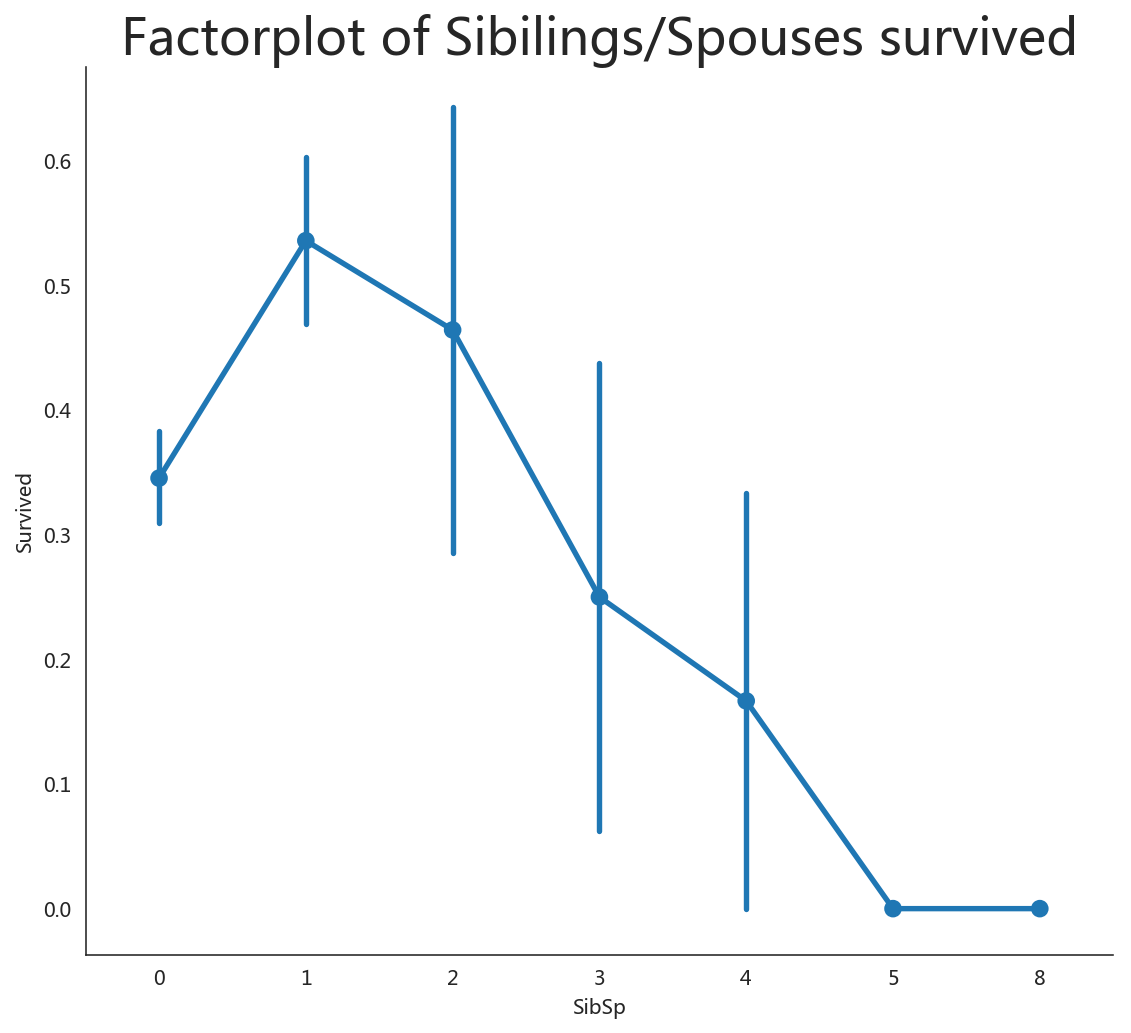

In [62]:
sns.factorplot(x = "SibSp", y = "Survived", data = train, kind = "point",size = 8)
plt.title("Factorplot of Sibilings/Spouses survived", fontsize = 25)
plt.subplots_adjust(top=0.85)

有1位兄弟姐妹或配偶陪同出行的生还率最高，其次是有2位陪同，但因2位陪同的情况样本数少，可靠性更低;  
大体上呈现的趋势是兄妹或配偶人数越多，生还率越低。

**Title**

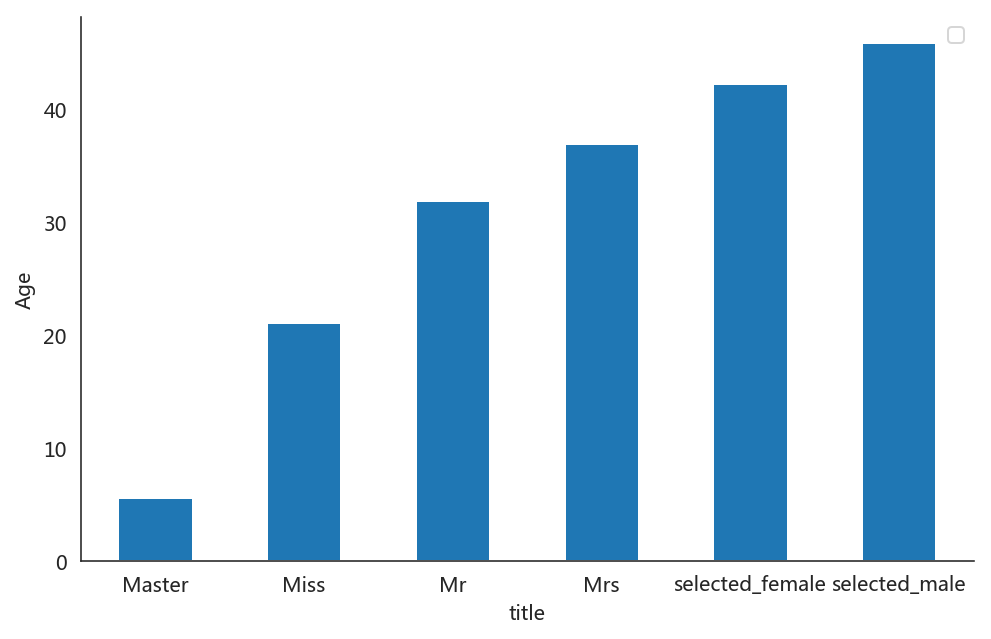

In [63]:
titanic_clean.groupby(['title'])[['Age','title']].mean().plot(kind='bar',figsize=(8,5))
plt.legend('')
plt.ylabel('Age')
plt.xticks(rotation=0)
plt.show()

年龄分布相对title较为合理。

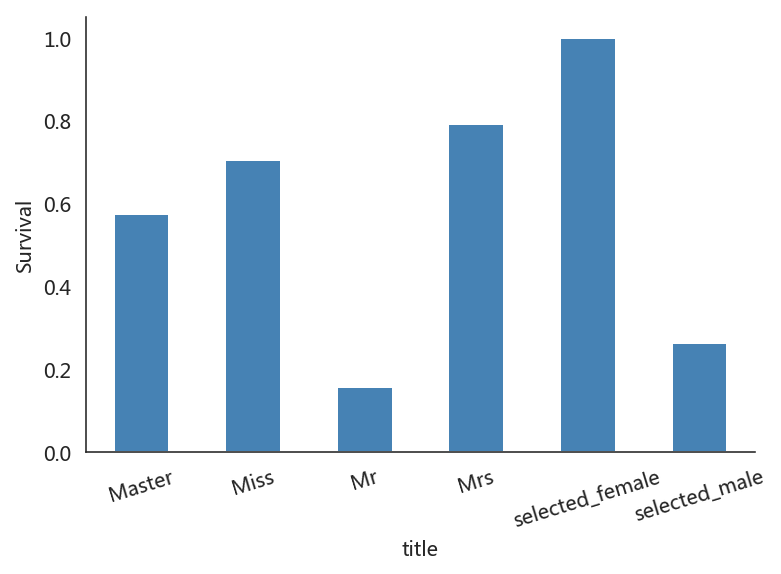

In [64]:
titanic_clean.groupby('title')['Survived'].mean().plot(kind='bar',color='steelblue')
plt.ylabel('Survival')
plt.xticks(rotation=17);

不同title的生还率差异明显，整体均为男性较低，而有特殊title的部分比同性别的普通人士的生还率稍高些。

In [65]:
Mr_idx = np.random.choice(titanic_clean[(titanic_clean.title=='Mr')&(titanic_clean.Survived.notnull())].index, size=100)
sldM_idx = np.random.choice(titanic_clean[(titanic_clean.title=='selected_male')&(titanic_clean.Survived.notnull())].index, size=100)

Mr_sample = titanic_clean.loc[Mr_idx,'Survived']
sldM_sample = titanic_clean.loc[sldM_idx,'Survived']
print('Mean survived of Mr:{0}, Mean survived of selected Male:{1}'.format(np.mean(Mr_sample), np.mean(sldM_sample)))

print(stats.ttest_ind(Mr_sample, sldM_sample))

Mean survived of Mr:0.1, Mean survived of selected Male:0.27
Ttest_indResult(statistic=-3.156820749009882, pvalue=0.001844266200623279)


从上述T检验结果可知，在95%的置信度时，selected male与一般Mr间的生还率具有统计显著差异。

**Embarked**

In [66]:
Survived_Embarked = pd.concat([train.groupby('Embarked')['Survived'].count(),
                               train.groupby('Embarked')['Survived'].sum(),
                               train.groupby('Embarked')['Survived'].mean()],axis=1).reset_index()
Survived_Embarked.columns=['Embarked','Total','Survived','Survival']
Survived_Embarked

,Embarked,Total,Survived,Survival
0,C,170,95.0,0.558824
1,Q,77,30.0,0.389610
2,S,644,217.0,0.336957


<Figure size 864x720 with 0 Axes>

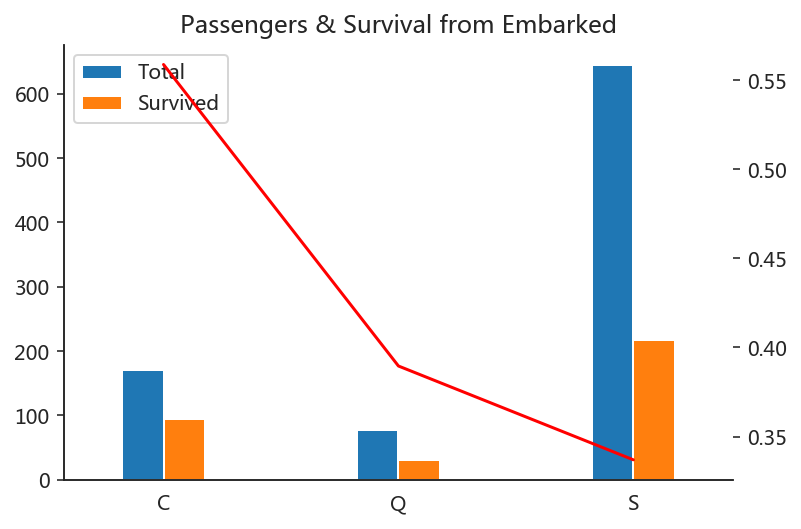

In [67]:
fig = plt.figure(figsize=(12,10))
ind = np.arange(3)
width = 0.35

Survived_Embarked[['Total','Survived']].plot(kind='bar',width=width)
Survived_Embarked['Survival'].plot(secondary_y=True,color='r')
plt.title('Passengers & Survival from Embarked')
plt.xticks(ind, ('C', 'Q', 'S'))

plt.show();

S港登船的人数最多，远超过C、Q登船的人数；  
而S港登船的生还率是最低的，C港登船的生还率最高。  

**Cabin**

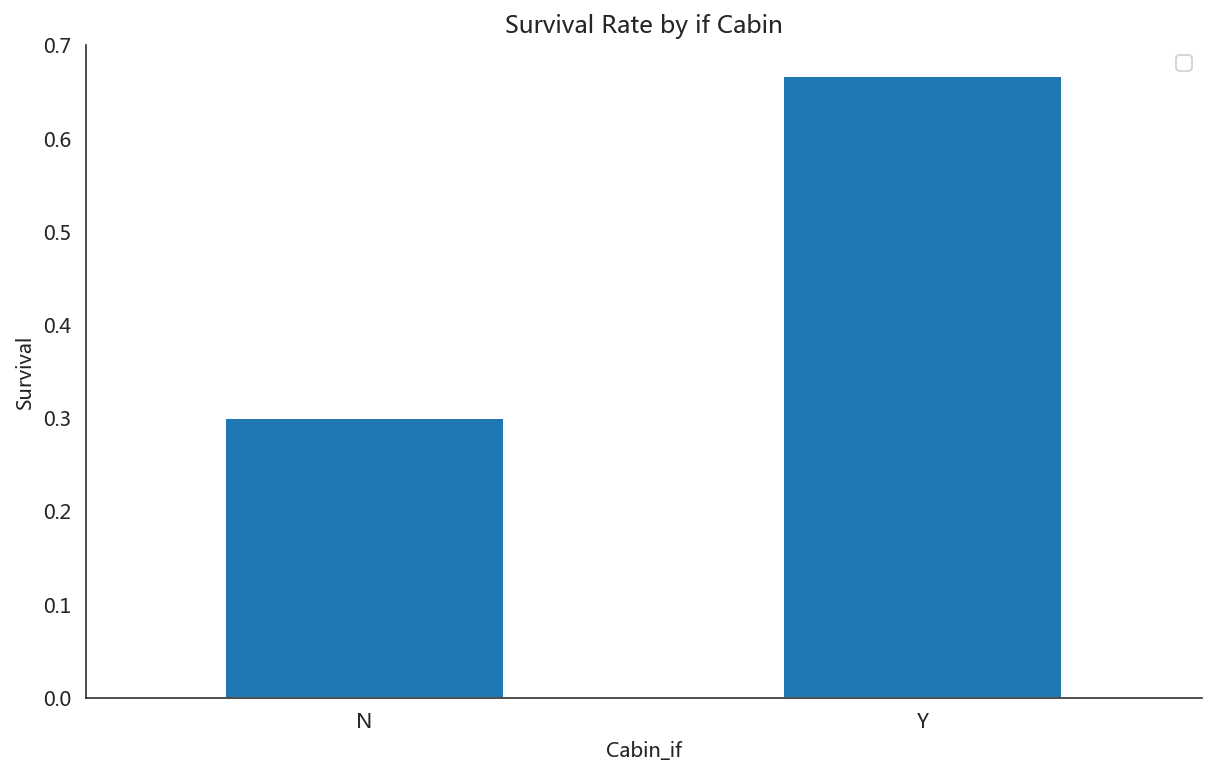

In [68]:
pd.pivot_table(titanic_clean,index=['Cabin_if'],values=['Survived']).plot.bar(figsize=(10,6))
plt.title('Survival Rate by if Cabin')
plt.ylabel('Survival')
plt.legend('')
plt.xticks([0,1],['N','Y'],rotation=0)
plt.show();

从上图可知，有包厢号的生还率会远高于无包厢的情况。

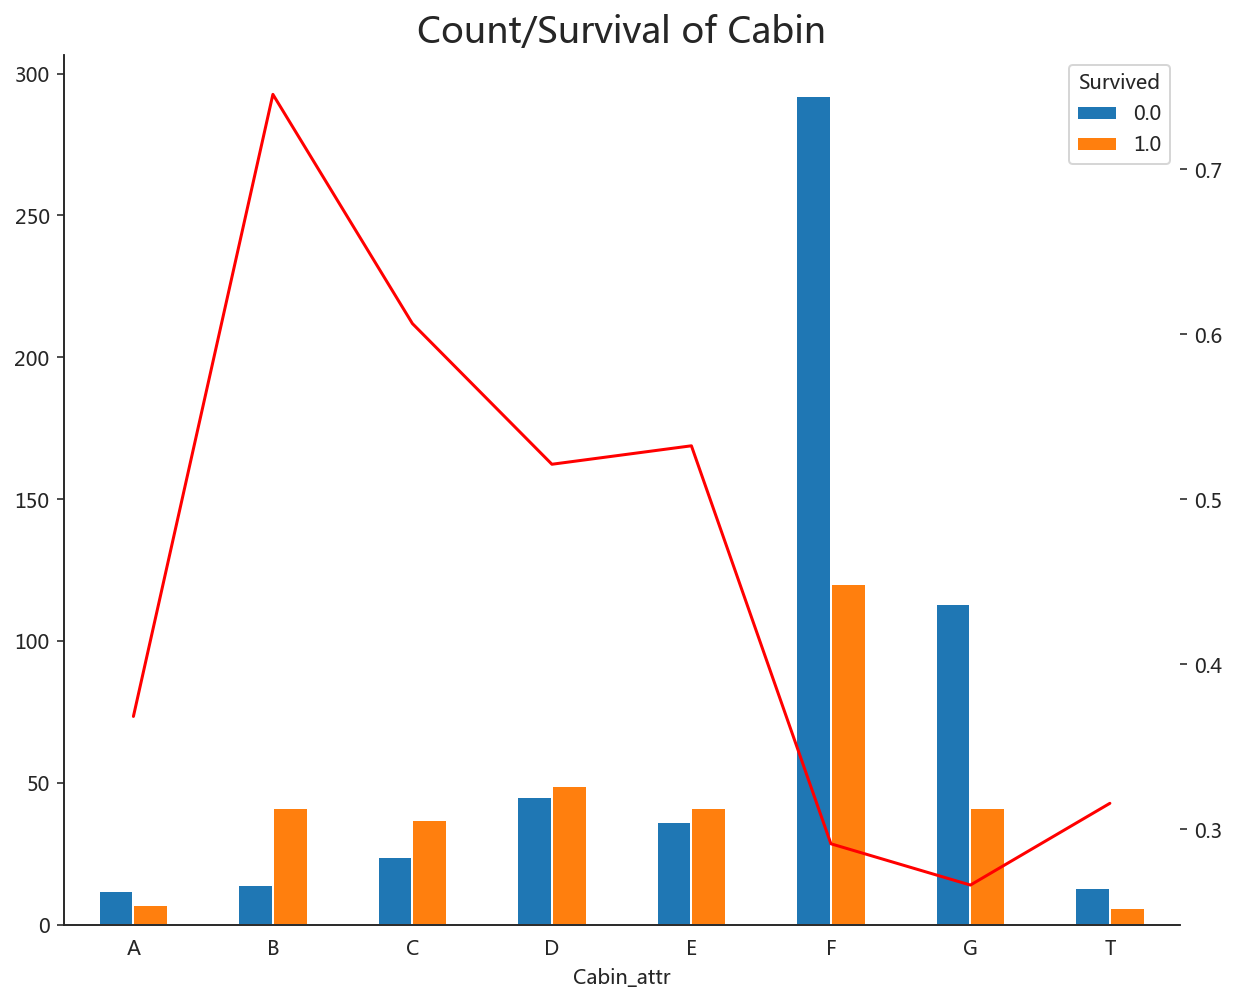

In [69]:
pd.crosstab(titanic_clean.Cabin_attr,titanic_clean.Survived).plot(kind='bar',figsize=(10,8))
titanic_clean.groupby('Cabin_attr')['Survived'].mean().plot(secondary_y=True,kind='line',color='r')
plt.title('Count/Survival of Cabin', fontsize=18)
plt.show();

生还率最高的为包厢首字母为B的，包厢首字母为F和G的人数最多，但生还率最低。

### 问题五
组合特征间的关系

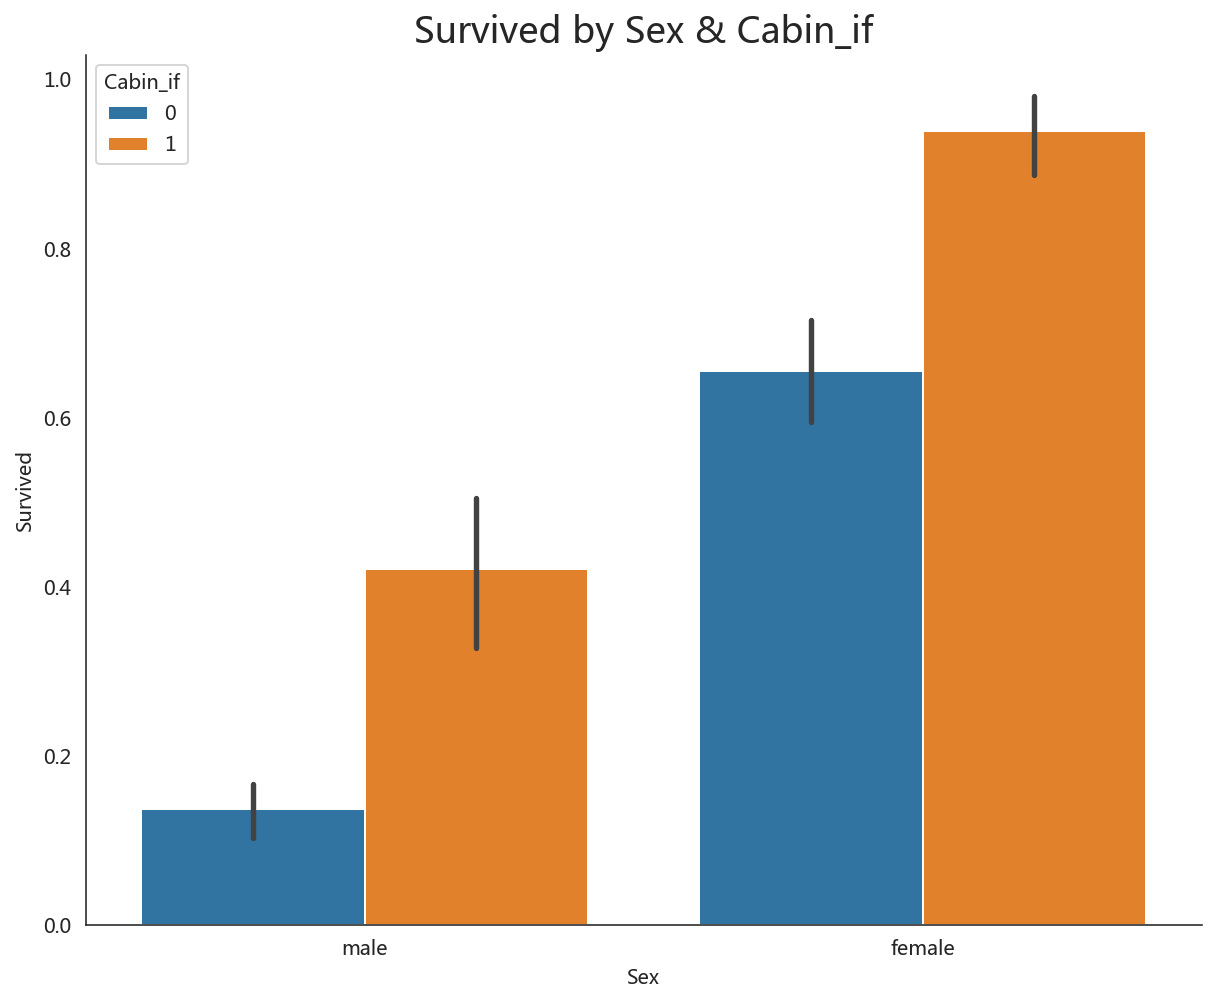

In [70]:
plt.figure(figsize=(10,8))
sns.barplot(x='Sex',y='Survived',hue='Cabin_if',data=titanic_clean)
plt.title("Survived by Sex & Cabin_if",fontsize=18);

<Figure size 576x432 with 0 Axes>

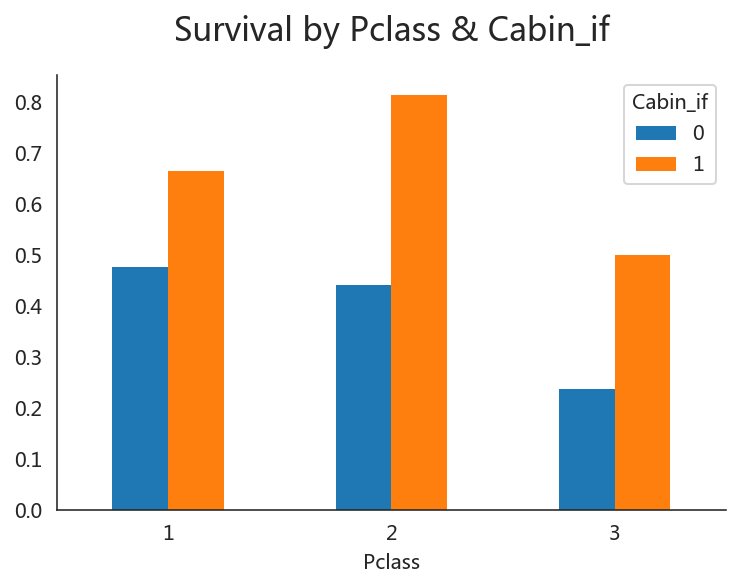

In [71]:
plt.figure(figsize=(8,6))
titanic_clean.pivot_table('Survived',index='Pclass',columns='Cabin_if').plot(kind='bar',edgecolor='none')
plt.title('Survival by Pclass & Cabin_if',y=1.05, size=16)
plt.xticks(rotation=0)
plt.show();

有包厢号记录的生还率高于空缺的情况；  
对于无包厢号的，各等级舱的生还率与整体上各舱级的情况较为接近，而有包厢号的情况中，二等舱的生还率却是高于一等舱的。

**Embarked & Pclass**

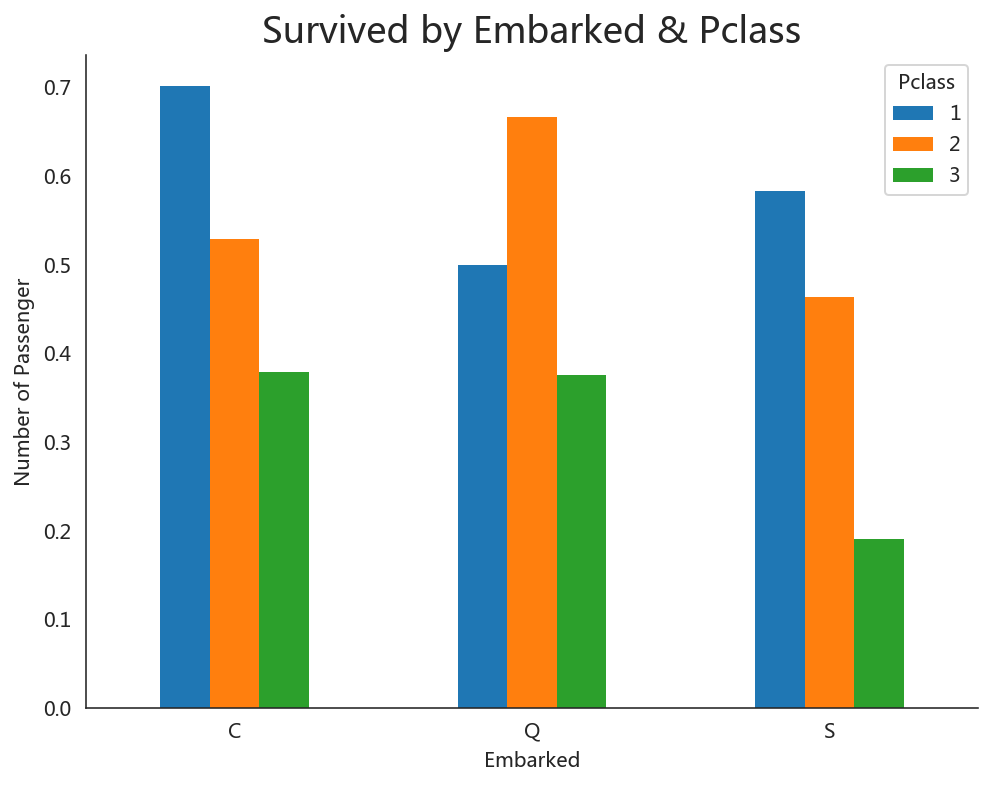

In [72]:
fig,ax = plt.subplots(figsize=(8,6))
#fig.set_size_inches((8,6))
titanic_clean[:891].groupby(['Embarked','Pclass'])['Survived'].mean().unstack().plot(kind='bar',
                                                                                         ax = ax,edgecolor='none')
ax.set(xlabel='Embarked',ylabel='Number of Passenger')
plt.title('Survived by Embarked & Pclass', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0);

在Southampton港登船的人数最多，而其中又以三等舱的人数占比最高，而三等舱的生还率较低，影响Southampton登船的生还率更低；  
在Cherbourg上船的一等舱人员占比最高，而一等舱的生还率最高，从而影响Cherbourg登船的生还率最高。
<br>

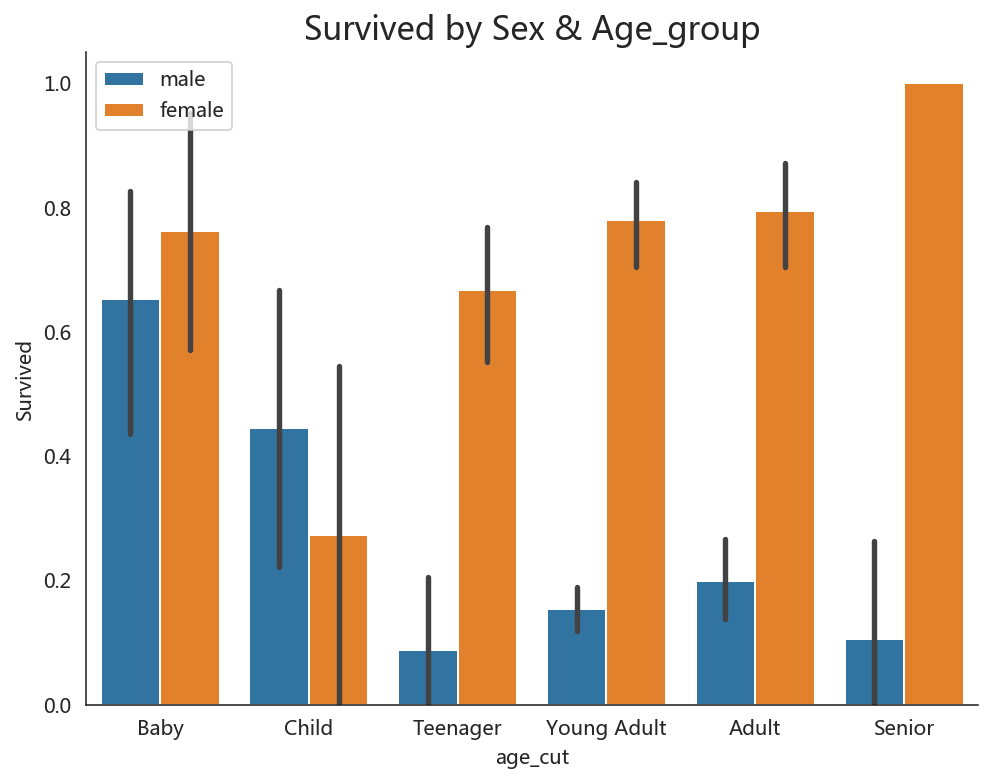

In [73]:
plt.figure(figsize=(8,6))
sns.barplot(x='age_cut',y='Survived',hue='Sex',data=titanic_clean[:891])
plt.title("Survived by Sex & Age_group",fontsize=16)
plt.legend(loc='upper left');

不同年龄段的生还率，性别差异明显，除Child是男性生还率高于女性外，其他均为女性的生还率更高。

**Sex & Pclass**

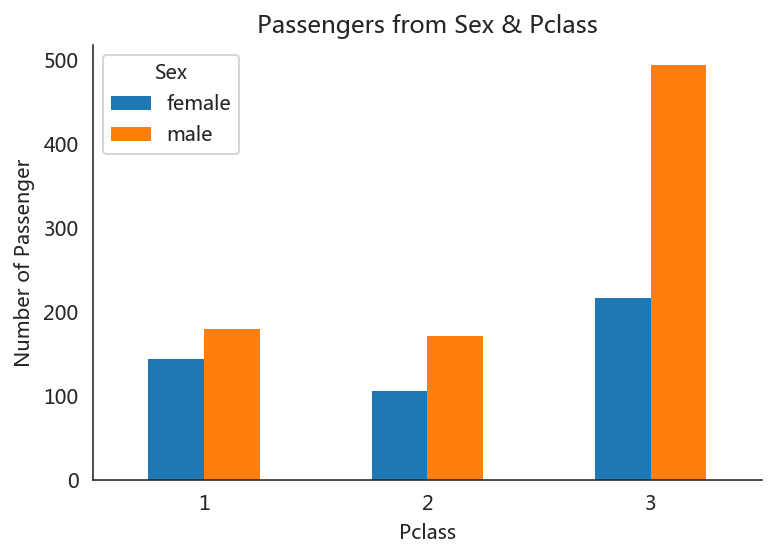

In [74]:
f,ax = plt.subplots()
f.set_size_inches((6,4))
titanic_clean.groupby(['Pclass','Sex'])['PassengerId'].count().unstack().plot(kind='bar',ax = ax,edgecolor='none')
ax.set_title('Passengers from Sex & Pclass')
ax.set_ylabel('Number of Passenger')
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show();

从整体来看，各类舱位均是男性乘客较多，特别是三等舱，男性乘客是女性的2倍多。  
因男性的生还率远低于女性，这对于不同舱位的生还率存在较大的影响。

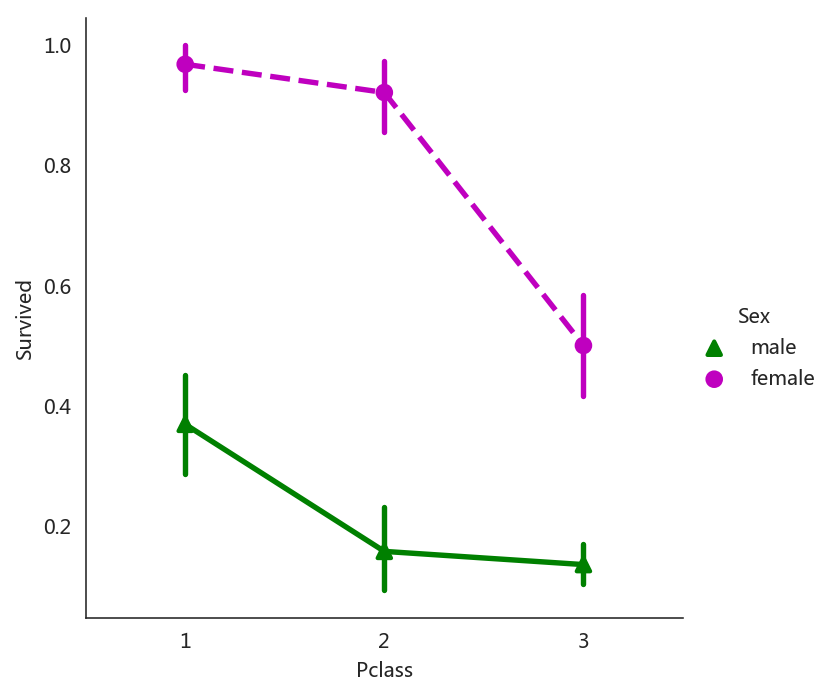

In [75]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", kind="point", palette={"male": "g", "female": "m"},
            markers=["^", "o"], linestyles=["-", "--"],data=titanic_clean);

一等舱和二等舱的女性生还率均较高，超过90%，而三等舱的女性生还率却骤减，仅约50%；  
男性仅一等舱的生还率相对较高，但会低于三等舱女性的生还率，二等舱和三等舱的男性生还率取低，且相差不大。

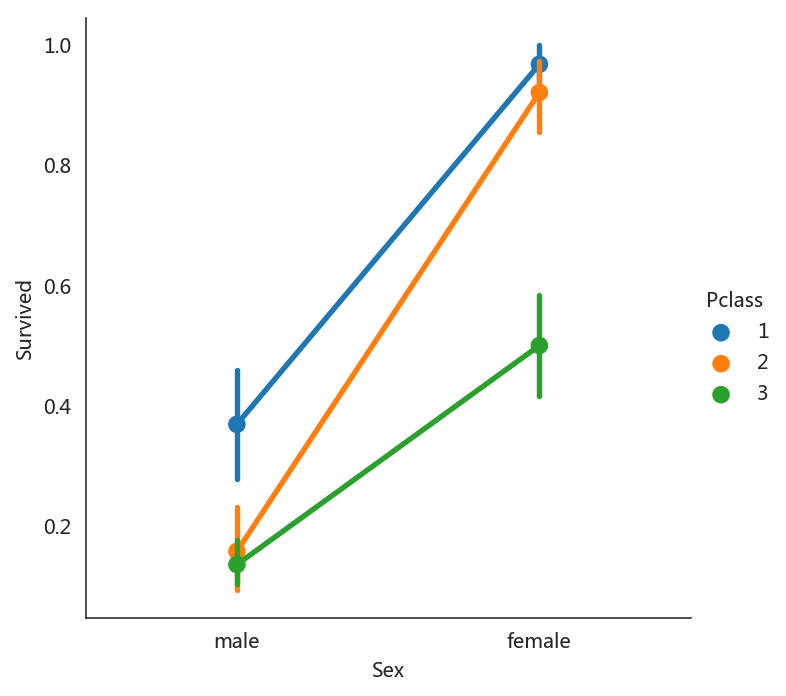

In [76]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="point", data=titanic_clean);

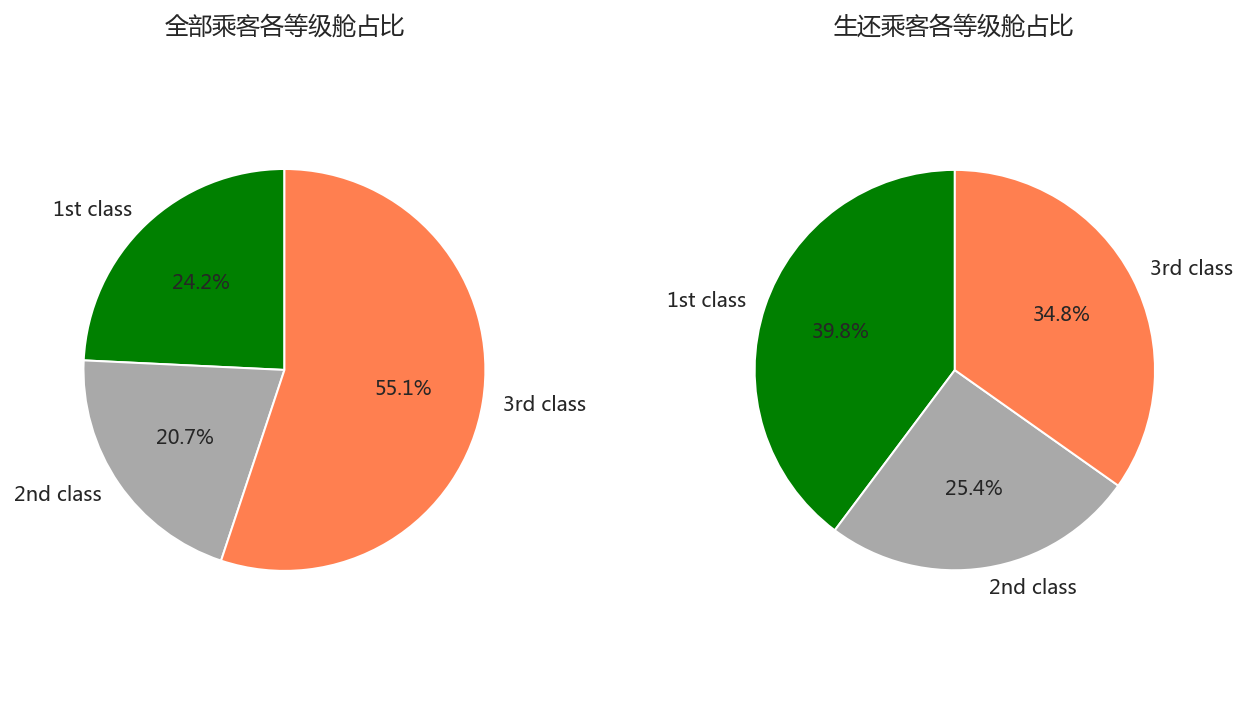

In [77]:
labels = '1st class','2nd class','3rd class'
titanic_tr_survived = titanic_clean.loc[titanic_clean.Survived == 1,:]
datas = [titanic_clean[:891],titanic_tr_survived]

fig, axes = plt.subplots(1,2,figsize=(10,6))
for i,data in enumerate(datas):
    axes[i].pie(data.groupby('Pclass')['Survived'].count()/data.Survived.count(),
                labels=labels, autopct='%1.1f%%',colors=['Green','darkgray','coral'],
                shadow=False, startangle=90,wedgeprops=dict(edgecolor='w'))
    axes[i].axis('equal')

axes[0].set_title('全部乘客各等级舱占比')
axes[1].set_title('生还乘客各等级舱占比')
plt.subplots_adjust(wspace = 0.5)

从生还人员所来自的舱位来看，一等舱人员占比最高，约为40%，而乘客数量占比超过半数的三等舱人员在生还人员中仅占约三分之一，二等舱人数占比最少，生还人员中占比稍有提高。

## 4 特征工程  
  

In [78]:
titanic_feat = titanic_clean.copy()

### 1) family_size feature

In [79]:
pd.pivot_table(titanic_feat,index=['Parch'],columns=['SibSp'], values=['Survived'])

Survived                                                  
SibSp         0         1         2         3         4    5    8
Parch                                                            
0      0.303538  0.520325  0.250000  1.000000       NaN  NaN  NaN
1      0.657895  0.596491  0.857143  0.000000  0.000000  NaN  NaN
2      0.724138  0.631579  0.500000  0.285714  0.333333  0.0  0.0
3      1.000000  0.333333  1.000000       NaN       NaN  NaN  NaN
4      0.000000  0.000000       NaN       NaN       NaN  NaN  NaN
5      0.000000  0.333333       NaN       NaN       NaN  NaN  NaN
6           NaN  0.000000       NaN       NaN       NaN  NaN  NaN

In [80]:
pd.crosstab(titanic_feat.loc[:891,'Parch'], titanic_feat.loc[:891,'SibSp'])

SibSp,0,1,2,3,4,5,8
Parch,,,,,,,
0,538,123,16,2,0,0,0
1,38,57,7,7,9,0,0
2,29,19,4,7,9,5,7
3,1,3,1,0,0,0,0
4,1,3,0,0,0,0,0
5,2,3,0,0,0,0,0
6,0,1,0,0,0,0,0


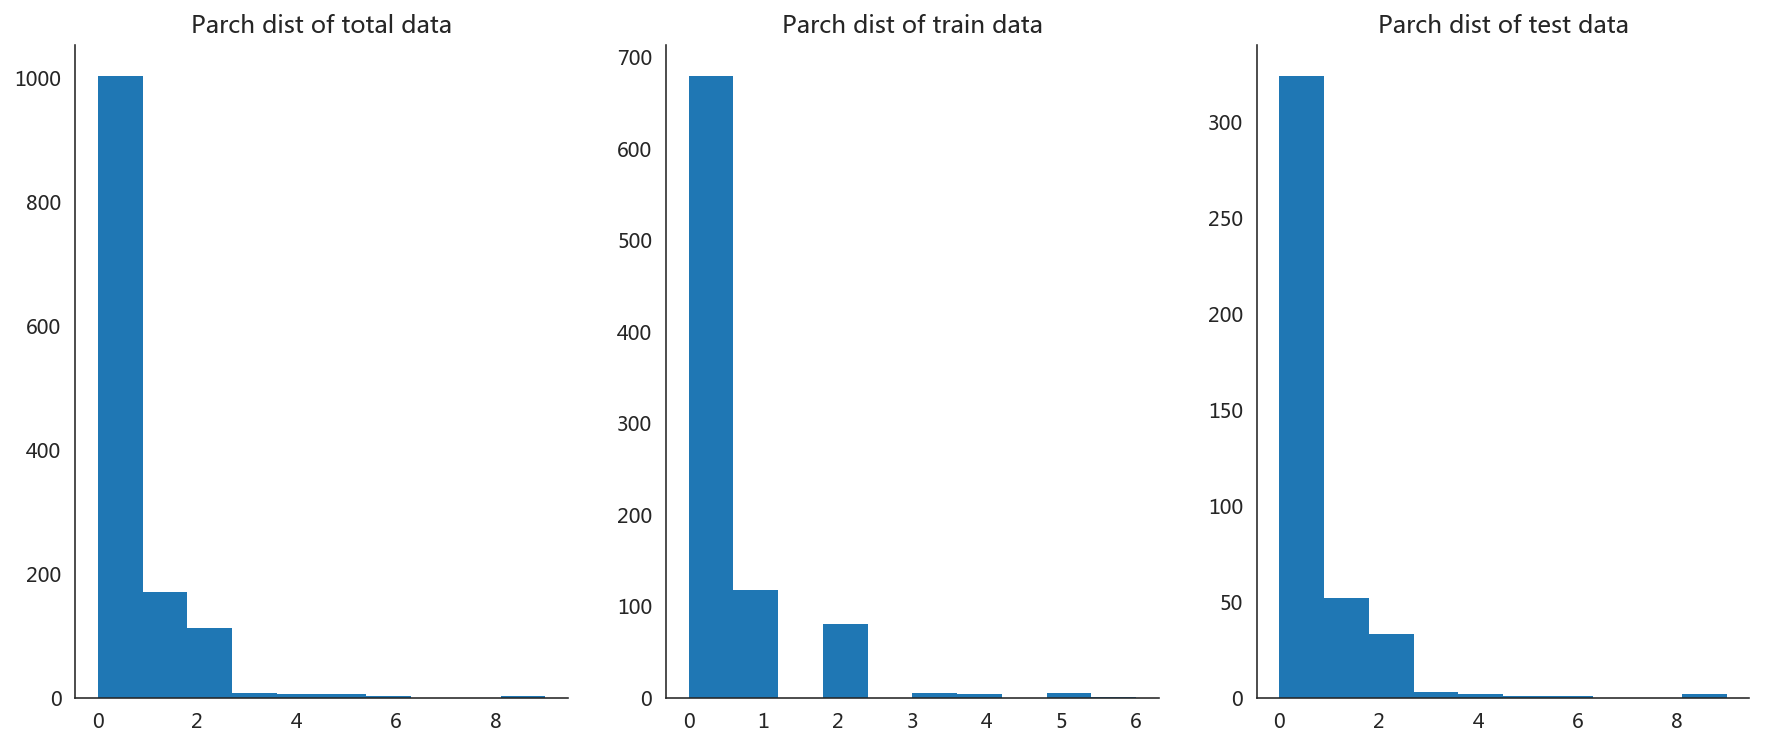

In [81]:
fig = plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.hist(titanic_feat.Parch, bins=10, edgecolor="None")
plt.title('Parch dist of total data')

plt.subplot(1,3,2)
plt.hist(titanic_feat.loc[:891,'Parch'],bins=10, edgecolor="None")
plt.title('Parch dist of train data')

plt.subplot(1,3,3)
plt.hist(titanic_feat.loc[891:,'Parch'], bins=10,edgecolor="None")
plt.title('Parch dist of test data')
plt.show()

In [82]:
titanic_feat['fsize'] = titanic_feat['Parch'].add(titanic_feat['SibSp'].values) + 1
titanic_feat[['fsize','Parch','SibSp']].sample(3)

,fsize,Parch,SibSp
65,3,1,1
1142,1,0,0
109,2,0,1


In [83]:
titanic_feat.fsize.value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: fsize, dtype: int64

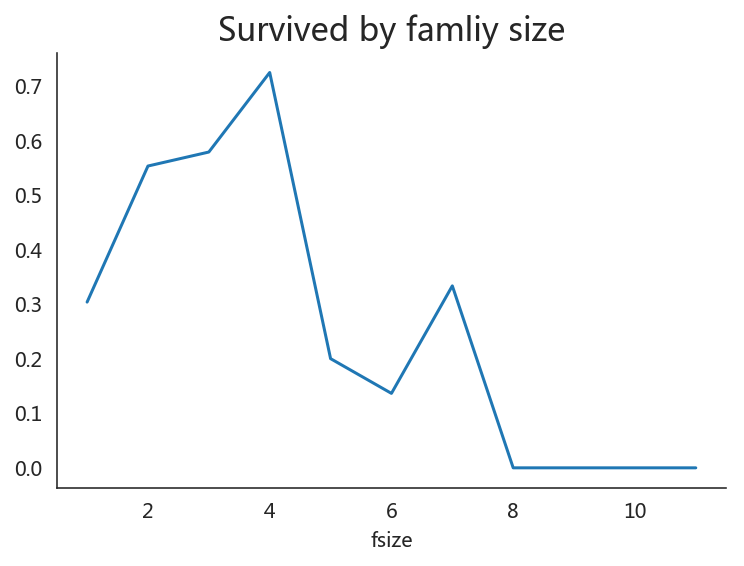

In [84]:
titanic_feat.groupby('fsize')['Survived'].mean().plot(kind='line')
plt.title("Survived by famliy size",fontsize=16);

### 2) family_group feature

In [85]:
def family_group(size):
    a = ''
    if (size <= 1):
        a = 'loner'
    elif (size <= 4):
        a = 'small'
    else:
        a = 'large'
    return a

titanic_feat['fgroup'] = titanic_feat.fsize.map(family_group)
titanic_feat.fgroup.value_counts()

loner    790
small    437
large     82
Name: fgroup, dtype: int64

In [86]:
titanic_feat.pivot_table(index=['fgroup'],values=['Survived'])

,Survived
fgroup,
large,0.161290
loner,0.303538
small,0.578767


### 3) is_alone feature

In [87]:
titanic_feat['is_alone'] = titanic_feat.fsize.apply(lambda x: 1 if x<2 else 0)
titanic_feat.groupby('is_alone')['Survived'].mean()

is_alone
0    0.505650
1    0.303538
Name: Survived, dtype: float64

### 4) tp feature    
set it to be 1 when title not including 'Mr' and 'selected_male' & Pclass not including 3rd 

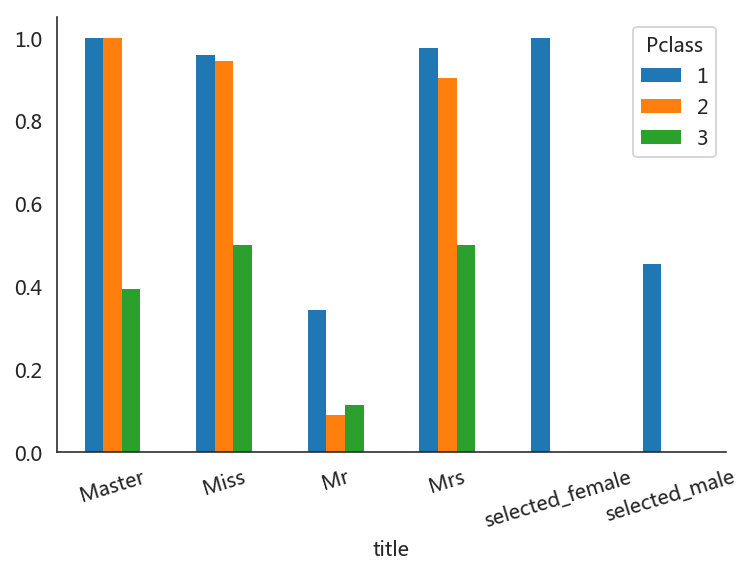

In [88]:
titanic_feat.pivot_table('Survived',index='title',columns='Pclass').plot(kind='bar',edgecolor='none')
plt.xticks(rotation=17);

对于女性和Master来说，一等舱和二等舱的生还率较为接近，均高于三等舱，而男性Mr和selected_male仅一等舱生还率稍高。

In [89]:
def comp_tp(x):
    if (titanic_feat.loc[x,'Pclass']!=3) and (titanic_feat.loc[x,'title']!="Mr" 
                                              or titanic_feat.loc[x,'title']!="selected_male"):
        return 1
    else:
        return 0

In [90]:
for i in range(len(titanic_feat)):
    titanic_feat.loc[i,'tp'] = comp_tp(i)

titanic_feat.tp.sum()

600.0

### 5) calculated_fare
Fare/numOfSameTicket

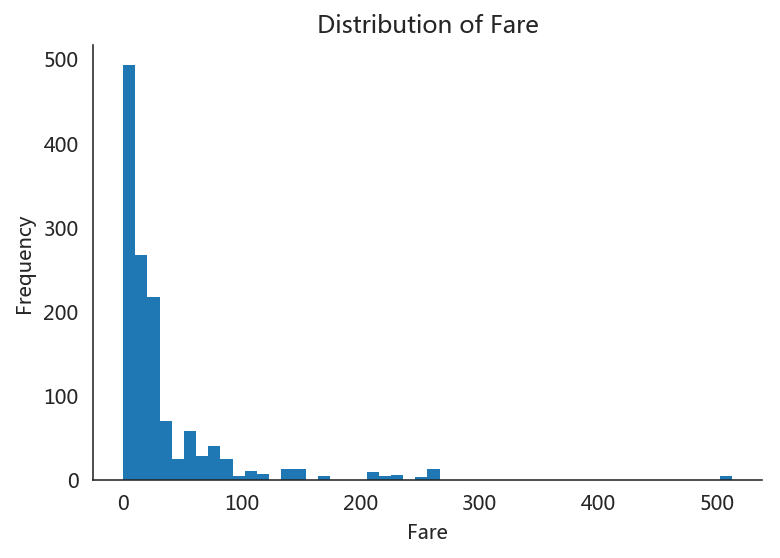

In [91]:
plt.hist(titanic_feat.Fare, bins=50, edgecolor="None")
plt.title("Distribution of Fare")
plt.xlabel("Fare")
plt.ylabel("Frequency");

In [92]:
ticket_num = dict(titanic_feat['Ticket'].value_counts())
titanic_feat['n_ticket'] = titanic_feat['Ticket'].map(ticket_num)

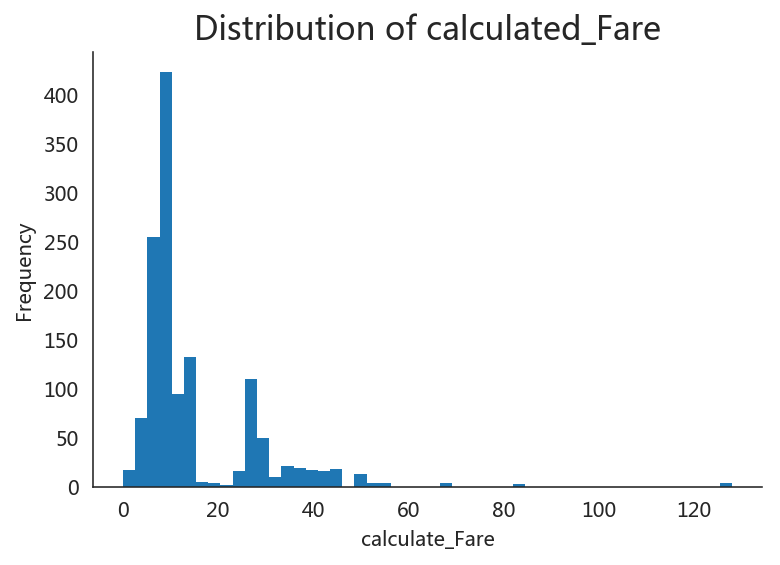

In [93]:
## Calculating fare based on num of same ticket. 
titanic_feat['calculated_fare'] = titanic_feat.Fare/titanic_feat.n_ticket
plt.hist(titanic_feat.calculated_fare, bins=50, edgecolor="None")
plt.title("Distribution of calculated_Fare",fontsize=16)
plt.xlabel("calculate_Fare")
plt.ylabel("Frequency");

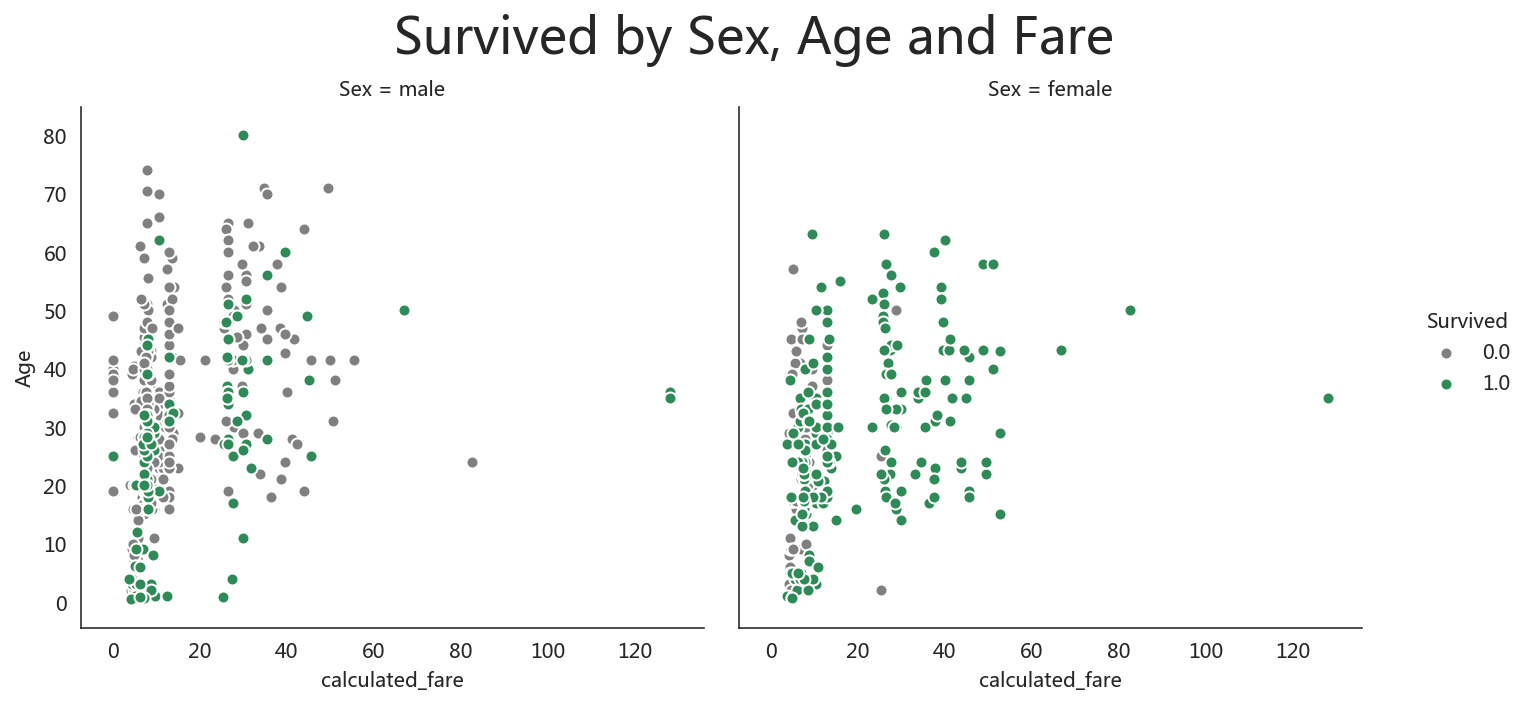

In [94]:
train = titanic_feat[:891]
g = sns.FacetGrid(train, size=5,hue="Survived", col ="Sex", margin_titles=True,palette=pal)
g.map(plt.scatter, "calculated_fare", "Age",edgecolor="w").add_legend()
g.fig.suptitle("Survived by Sex, Age and Fare", size = 25)
plt.subplots_adjust(top=0.85)

### 6) fare_cut

In [95]:
def cut_fare(x):
    if x <= 10:
        return "very_low"
    elif x <= 25:
        return "low"
    elif x <= 40:
        return "middle"
    else:
        return "high"

titanic_feat.loc[:,'fare_cut'] = titanic_feat.Fare.apply(cut_fare)

In [96]:
titanic_feat['fare_cut'].value_counts()

very_low    491
low         331
high        264
middle      223
Name: fare_cut, dtype: int64

In [97]:
titanic_feat.groupby('fare_cut')['Survived'].mean().sort_values()

fare_cut
very_low    0.199405
low         0.420814
middle      0.436709
high        0.642045
Name: Survived, dtype: float64

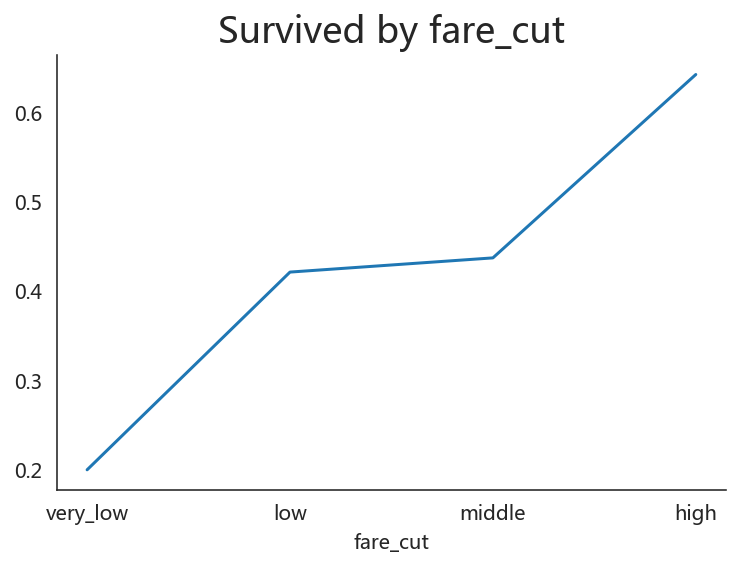

In [98]:
titanic_feat.groupby('fare_cut')['Survived'].mean().sort_values().plot()
plt.xticks([0,1,2,3],["very_low","low","middle","high"])
plt.title("Survived by fare_cut",fontsize=18)
plt.show();

In [99]:
pd.crosstab(titanic_feat['fare_cut'], titanic_feat.Pclass)

Pclass,1,2,3
fare_cut,,,
high,221,16,27
low,0,168,163
middle,94,86,43
very_low,8,7,476


In [100]:
titanic_feat.pivot_table('Survived',index=['fare_cut','Pclass'])

Survived
fare_cut Pclass          
high     1       0.712329
         2       0.400000
         3       0.250000
low      2       0.445455
         3       0.396396
middle   1       0.500000
         2       0.586207
         3       0.083333
very_low 1       0.000000
         2       0.000000
         3       0.206790

### 7) nlength_group

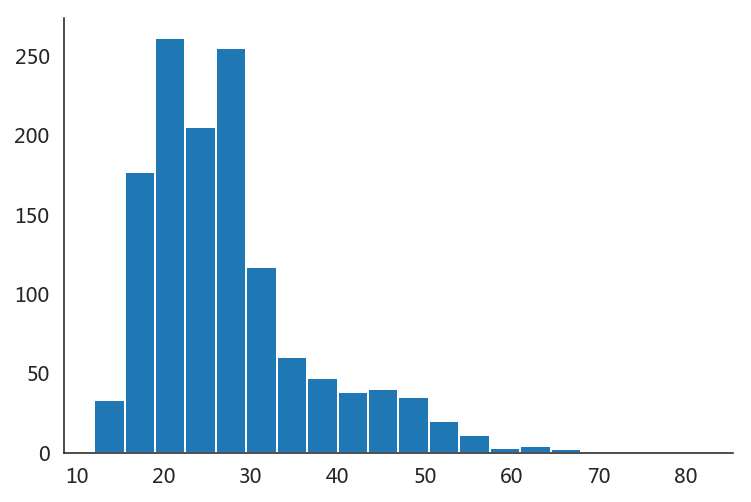

In [101]:
titanic_feat['name_length'] = titanic_feat.Name.apply(lambda x:len(x))
plt.hist(titanic_feat.name_length,bins=20);

In [102]:
def name_length_group(size):
    a = ''
    if (size <=20):
        a = 'short'
    elif (size <=35):
        a = 'medium'
    elif (size <=45):
        a = 'good'
    else:
        a = 'long'
    return a

titanic_feat['nlength_group'] = titanic_feat.name_length.apply(name_length_group)

titanic_feat.nlength_group.value_counts()

medium    736
short     358
good      127
long       88
Name: nlength_group, dtype: int64

### 8) TPP

In [103]:
def qtlineBar(data):
    data.plot(kind='bar', figsize=(12,8))
    plt.axhline(0.75,color='#BA55D3')
    plt.axhline(0.5,color='#BA55D3')
    plt.axhline(0.25,color='#BA55D3')

In [104]:
def matchVariate(col1,col2,col3,val,cal,data):
    v1 = np.unique(col1)
    v2 = np.unique(col2)
    v3 = np.unique(col3)
    for i in v1:
        for j in v2:
            for t in v3:
                if data.loc[(col1==i) & (col2==j) & (col3==t) & (val.notnull()),'Survived'].mean()>=0.75:
                    data.loc[(col1==i) & (col2==j) & (col3==t),cal] = 1
                elif data.loc[(col1==i) & (col2==j) & (col3==t) & (val.notnull()),'Survived'].mean()>=0.5:
                    data.loc[(col1==i) & (col2==j) & (col3==t),cal] = 2
                elif data.loc[(col1==i) & (col2==j) & (col3==t) & (val.notnull()),'Survived'].mean()>=0.25:
                    data.loc[(col1==i) & (col2==j) & (col3==t),cal] = 3
                elif data.loc[(col1==i) & (col2==j) & (col3==t) & (val.notnull()),'Survived'].mean()>=0:
                    data.loc[(col1==i) & (col2==j) & (col3==t),cal] = 4
                else:
                    data.loc[(col1==i) & (col2==j) & (col3==t),cal] = 5

In [105]:
titanic_feat.pivot_table('Survived',index=['title','Pclass']).sort_values('Survived',ascending=False)

Survived
title           Pclass          
Master          1       1.000000
                2       1.000000
selected_female 1       1.000000
Mrs             1       0.976190
Miss            1       0.959184
                2       0.942857
Mrs             2       0.902439
Miss            3       0.500000
Mrs             3       0.500000
selected_male   1       0.454545
Master          3       0.392857
Mr              1       0.342593
                3       0.112853
                2       0.087912
selected_male   2       0.000000

Text(32, 0.28, '25% survival rate')

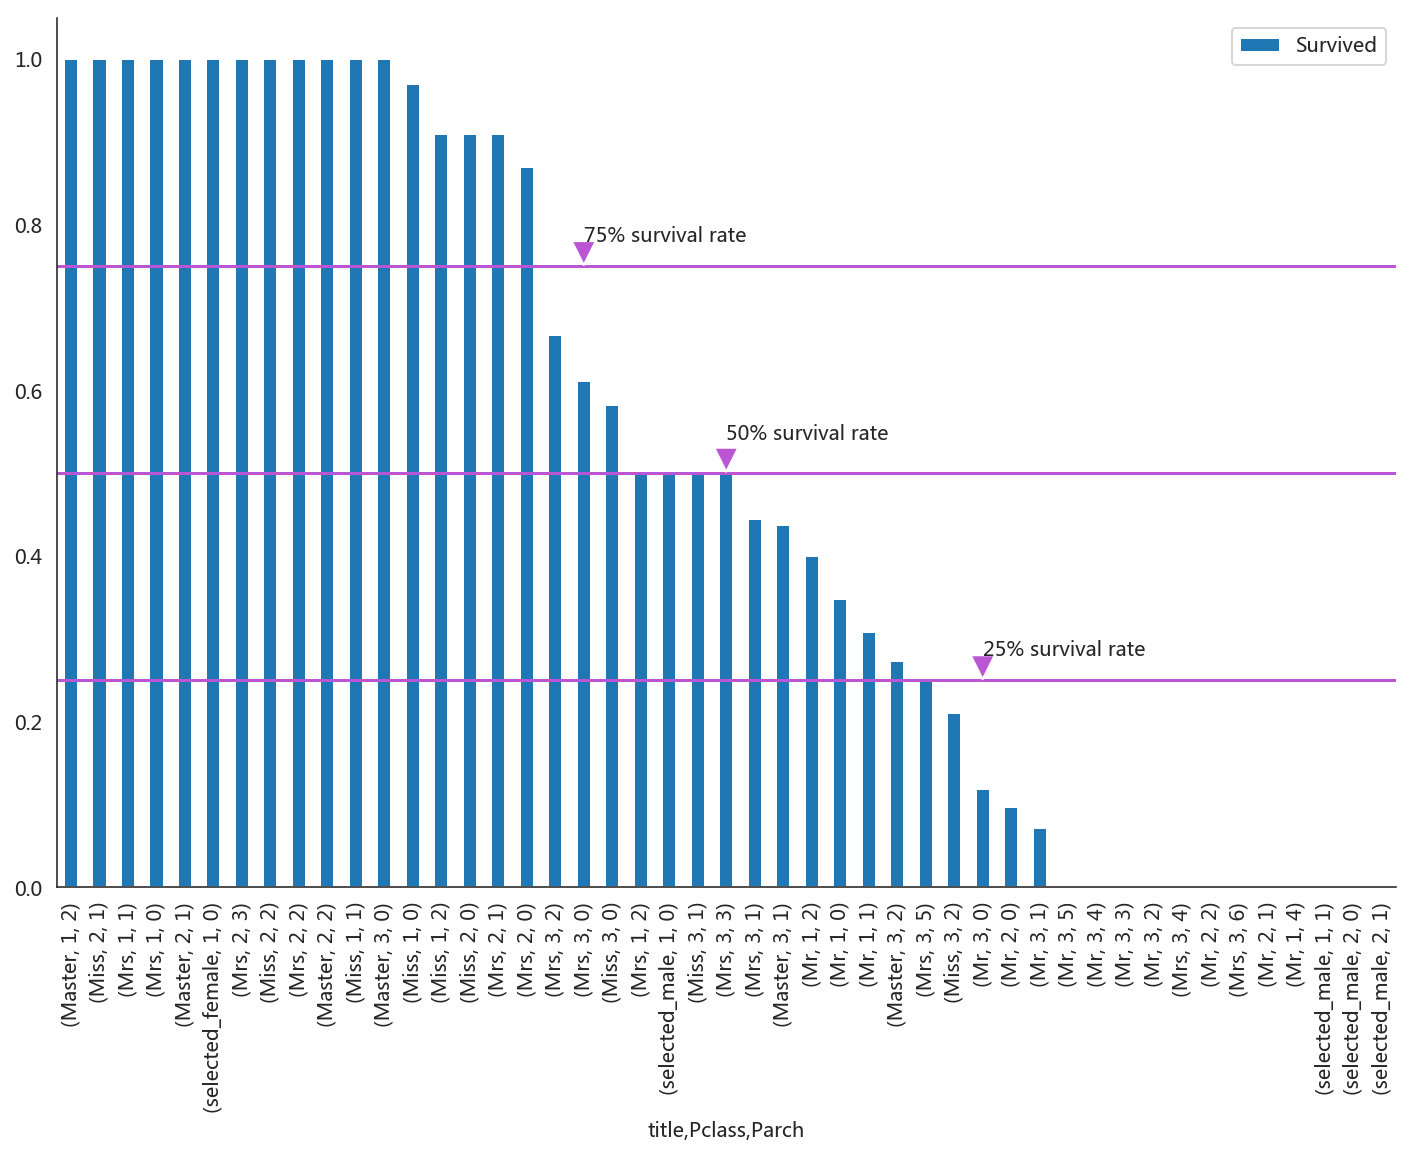

In [106]:
TPP = titanic_feat.pivot_table('Survived',index=['title','Pclass','Parch']).sort_values('Survived',ascending=False)
qtlineBar(TPP)
plt.annotate('75% survival rate',xy=(18,0.75),xytext=(18,0.78),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))
plt.annotate('50% survival rate',xy=(23,0.50),xytext=(23,0.54),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))
plt.annotate('25% survival rate',xy=(32,0.25),xytext=(32,0.28),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))

In [107]:
matchVariate(titanic_feat.title,titanic_feat.Pclass,titanic_feat.Parch,titanic_feat.Survived,'TPP',titanic_feat)
titanic_feat.TPP.unique()

array([4., 1., 2., 3., 5.])

In [108]:
titanic_feat.loc[titanic_feat.TPP == 5,:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,fsize,fgroup,is_alone,tp,n_ticket,calculated_fare,fare_cut,name_length,nlength_group,TPP
915,916,NaN,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.000000,1,3,PC 17608,262.375,...,5,large,0,1.0,7,37.482143,high,47,long,5.0
960,961,NaN,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.000000,1,4,19950,263.000,...,6,large,0,1.0,6,43.833333,high,35,medium,5.0
1030,1031,NaN,3,"Goodwin, Mr. Charles Frederick",male,40.000000,1,6,CA 2144,46.900,...,8,large,0,0.0,8,5.862500,high,30,medium,5.0
1033,1034,NaN,1,"Ryerson, Mr. Arthur Larned",male,61.000000,1,3,PC 17608,262.375,...,5,large,0,1.0,7,37.482143,high,26,medium,5.0
1233,1234,NaN,3,"Sage, Mr. John George",male,28.318910,1,9,CA. 2343,69.550,...,11,large,0,0.0,11,6.322727,high,21,medium,5.0
1256,1257,NaN,3,"Sage, Mrs. John (Annie Bullen)",female,32.326531,1,9,CA. 2343,69.550,...,11,large,0,0.0,11,6.322727,high,30,medium,5.0


In [109]:
titanic_feat.loc[(titanic_feat.TPP==5.)&(titanic_feat.Sex=='female'),'TPP'] = 1
titanic_feat.loc[(titanic_feat.TPP==5.)&(titanic_feat.Sex=='male'),'TPP'] = 4
titanic_feat.TPP.unique()

array([4., 1., 2., 3.])

In [110]:
print(titanic_feat.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_attr',
       'Cabin_if', 'title', 'age_cut', 'fsize', 'fgroup', 'is_alone', 'tp',
       'n_ticket', 'calculated_fare', 'fare_cut', 'name_length',
       'nlength_group', 'TPP'],
      dtype='object')


### 5 Pre-modeling

#### bulid dataset

In [111]:
# choose the features for modeling
titanic_est1 = pd.get_dummies(titanic_feat, columns=['Pclass', 'Embarked', 'Cabin_attr','title', 'age_cut',
                                                     'fgroup','fare_cut','TPP','nlength_group'],drop_first=True)
titanic_est1.drop(['Name','Ticket','Cabin','fsize','n_ticket','name_length'],axis=1,inplace=True)

titanic_est1 = titanic_est1.set_index(['PassengerId'])

# change Sex to int number
titanic_est1['Sex'] = (titanic_est1['Sex'] == 'male').astype('int')
titanic_est1['tp'] = titanic_est1['tp'].astype('int')
# change Cabin_if to int number
#titanic_est1['Cabin_if'] = (titanic_est1['Cabin_if'] == 'Y').astype('int')

# change Embarked to number, not correct, Embarked is a discrete feature.
#labels = titanic_est1['Embarked'].unique().tolist()
#titanic_est1['Embarked'] = titanic_est1['Embarked'].apply(lambda n: labels.index(n))

#age_cut_dict = {'Baby':1,'Child':2,'Teenager':3,'Young Adult':4,'Adult':5,'Senior':6}
#titanic_est1['age_cut'] = titanic_est1['age_cut'].map(age_cut_dict)

#title_dict = {'selected_female':1,'Mrs':2, 'Miss':3, 'Master':4, 'selected_male':5, 'Mr':6}
#titanic_est1['title'] = titanic_est1['title'].map(title_dict)

titanic_est1.sample(3)

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin_if,is_alone,tp,calculated_fare,...,fgroup_small,fare_cut_low,fare_cut_middle,fare_cut_very_low,TPP_2.0,TPP_3.0,TPP_4.0,nlength_group_long,nlength_group_medium,nlength_group_short
PassengerId,,,,,,,,,,,,,,,,,,,,,
493,0.0,1,55.000000,0,0,30.5000,1,1,1,30.5000,...,0,0,1,0,0,1,0,0,1,0
29,1.0,0,17.360874,0,0,7.8792,0,1,0,7.8792,...,0,0,0,1,1,0,0,0,1,0
50,0.0,0,18.000000,1,0,17.8000,0,0,0,8.9000,...,1,1,0,0,1,0,0,0,0,0


In [112]:
X = titanic_est1.drop(['Survived'],axis=1)

X1 = X[:891].values
X2 = X[891:].values
y1 = titanic_est1['Survived'][:891].values

print("train_data size: {0}\ntest_data size: {1}\ntrain_target size: {2}".format(X1.shape, X2.shape, y1.shape))

train_data size: (891, 41)
test_data size: (418, 41)
train_target size: (891,)


#### 标准化

In [113]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(X1)
X_scaled=scaler.transform(X1)
X_test_scaled=scaler.transform(X2)

#### try some basic models

In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [115]:
models=[KNeighborsClassifier(),LogisticRegression(penalty='l2',solver='newton-cg'),GaussianNB(),
        DecisionTreeClassifier(),RandomForestClassifier(n_estimators=10), GradientBoostingClassifier(),
        SVC(gamma='auto')]

# evaluate models by using cross-validation
names=['KNN','LR','NB','Tree','RF','GDBT','SVM']
for name, model in zip(names,models):
    score=cross_val_score(model,X1,y1,cv=5)
    print("{}:{},{}".format(name,score.mean(),score))

KNN:0.7251302669315094,[0.69273743 0.69273743 0.70786517 0.78089888 0.75141243]
LR:0.8260730331759101,[0.82122905 0.82122905 0.8258427  0.81460674 0.84745763]
NB:0.7801119020691989,[0.73184358 0.78212291 0.80898876 0.76404494 0.81355932]
Tree:0.7777952377254026,[0.73184358 0.81005587 0.79213483 0.7752809  0.77966102]
RF:0.8069589298766184,[0.81564246 0.80446927 0.83707865 0.76404494 0.81355932]
GDBT:0.8272027638967057,[0.81564246 0.81005587 0.85393258 0.82022472 0.83615819]
SVM:0.727358697660497,[0.68715084 0.72067039 0.71348315 0.75842697 0.75706215]


In [116]:
# used scaled data
names=['KNN','LR','NB','Tree','RF','GDBT','SVM']
for name, model in zip(names,models):
    kfold = KFold(n_splits=5)
    score=cross_val_score(model,X_scaled,y1,cv=kfold)
    print("{}:{},{}".format(name,score.mean(),score))

KNN:0.8081099742640134,[0.78212291 0.79775281 0.83146067 0.81460674 0.81460674]
LR:0.8249325214989642,[0.81005587 0.82022472 0.83146067 0.79775281 0.86516854]
NB:0.7463687150837989,[0.73184358 0.73595506 0.75842697 0.70224719 0.80337079]
Tree:0.7755445358106836,[0.76536313 0.79775281 0.76966292 0.78089888 0.76404494]
RF:0.8148201619484026,[0.81005587 0.80898876 0.83146067 0.78651685 0.83707865]
GDBT:0.8181783943255289,[0.82122905 0.79213483 0.83146067 0.80337079 0.84269663]
SVM:0.8249199673592367,[0.82122905 0.82022472 0.83146067 0.78089888 0.87078652]


'k-Nearest Neighbors', 'Support Vector Machine' perform much better on scaled data.  

In [117]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


def model_compare(X_train, y_train):
    # Machine Learning Algorithm (MLA) Selection and Initialization
    MLA = [
        # Ensemble Methods
        ensemble.AdaBoostClassifier(),
        ensemble.BaggingClassifier(),
        ensemble.ExtraTreesClassifier(),
        ensemble.GradientBoostingClassifier(),
        ensemble.RandomForestClassifier(),

        # Gaussian Processes
        gaussian_process.GaussianProcessClassifier(),

        # GLM
        linear_model.LogisticRegressionCV(),
        linear_model.PassiveAggressiveClassifier(),
        linear_model.RidgeClassifierCV(),
        linear_model.SGDClassifier(),
        linear_model.Perceptron(),

        # Navies Bayes
        naive_bayes.BernoulliNB(),
        naive_bayes.GaussianNB(),

        # Nearest Neighbor
        neighbors.KNeighborsClassifier(),

        # SVM
        svm.SVC(probability=True),
        svm.NuSVC(probability=True),
        svm.LinearSVC(),

        # Trees
        tree.DecisionTreeClassifier(),
        tree.ExtraTreeClassifier(),

        # Discriminant Analysis
        discriminant_analysis.LinearDiscriminantAnalysis(),
        discriminant_analysis.QuadraticDiscriminantAnalysis(),

        # xgboost: http://xgboost.readthedocs.io/en/latest/model.html
        XGBClassifier()
    ]
    # run model 10x with 60/30 split intentionally leaving out 10%
    cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, random_state=0,train_size=.6)

    # create table to compare MLA metrics
    MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean',
                   'MLA Test Accuracy 3*STD', 'MLA Time']
    MLA_compare = pd.DataFrame(columns=MLA_columns)

    # create table to compare MLA predictions
    MLA_predict = pd.DataFrame()

    # index through MLA and save performance to table
    row_index = 0
    for alg in MLA:
        # set name and parameters
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

        cv_results = model_selection.cross_validate(alg,X_train,y_train, cv=cv_split)

        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
        # if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean,
        # should statistically capture 99.7% of the subsets
        MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3
        # let's know the worst that can happen!

        # save MLA predictions - see section 6 for usage
        alg.fit(X_train, y_train)
        MLA_predict[MLA_name] = alg.predict(X_train)

        row_index += 1

    MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
    return MLA_compare

MLA_compare = model_compare(X_scaled,y1)

In [118]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.908801,0.836567,0.0841862,0.0838404
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.928652,0.83097,0.0807291,0.11562
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.874906,0.826119,0.0586379,0.0669151
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.849064,0.825373,0.0373954,0.00615711
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.846816,0.824627,0.040049,0.00551984
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.853184,0.823507,0.0436567,0.0790543
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.860487,0.823134,0.0592755,0.0812424
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.976592,0.816791,0.0666867,0.021713
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.847566,0.816791,0.0528496,0.351926
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.861423,0.810448,0.0661869,0.0714199


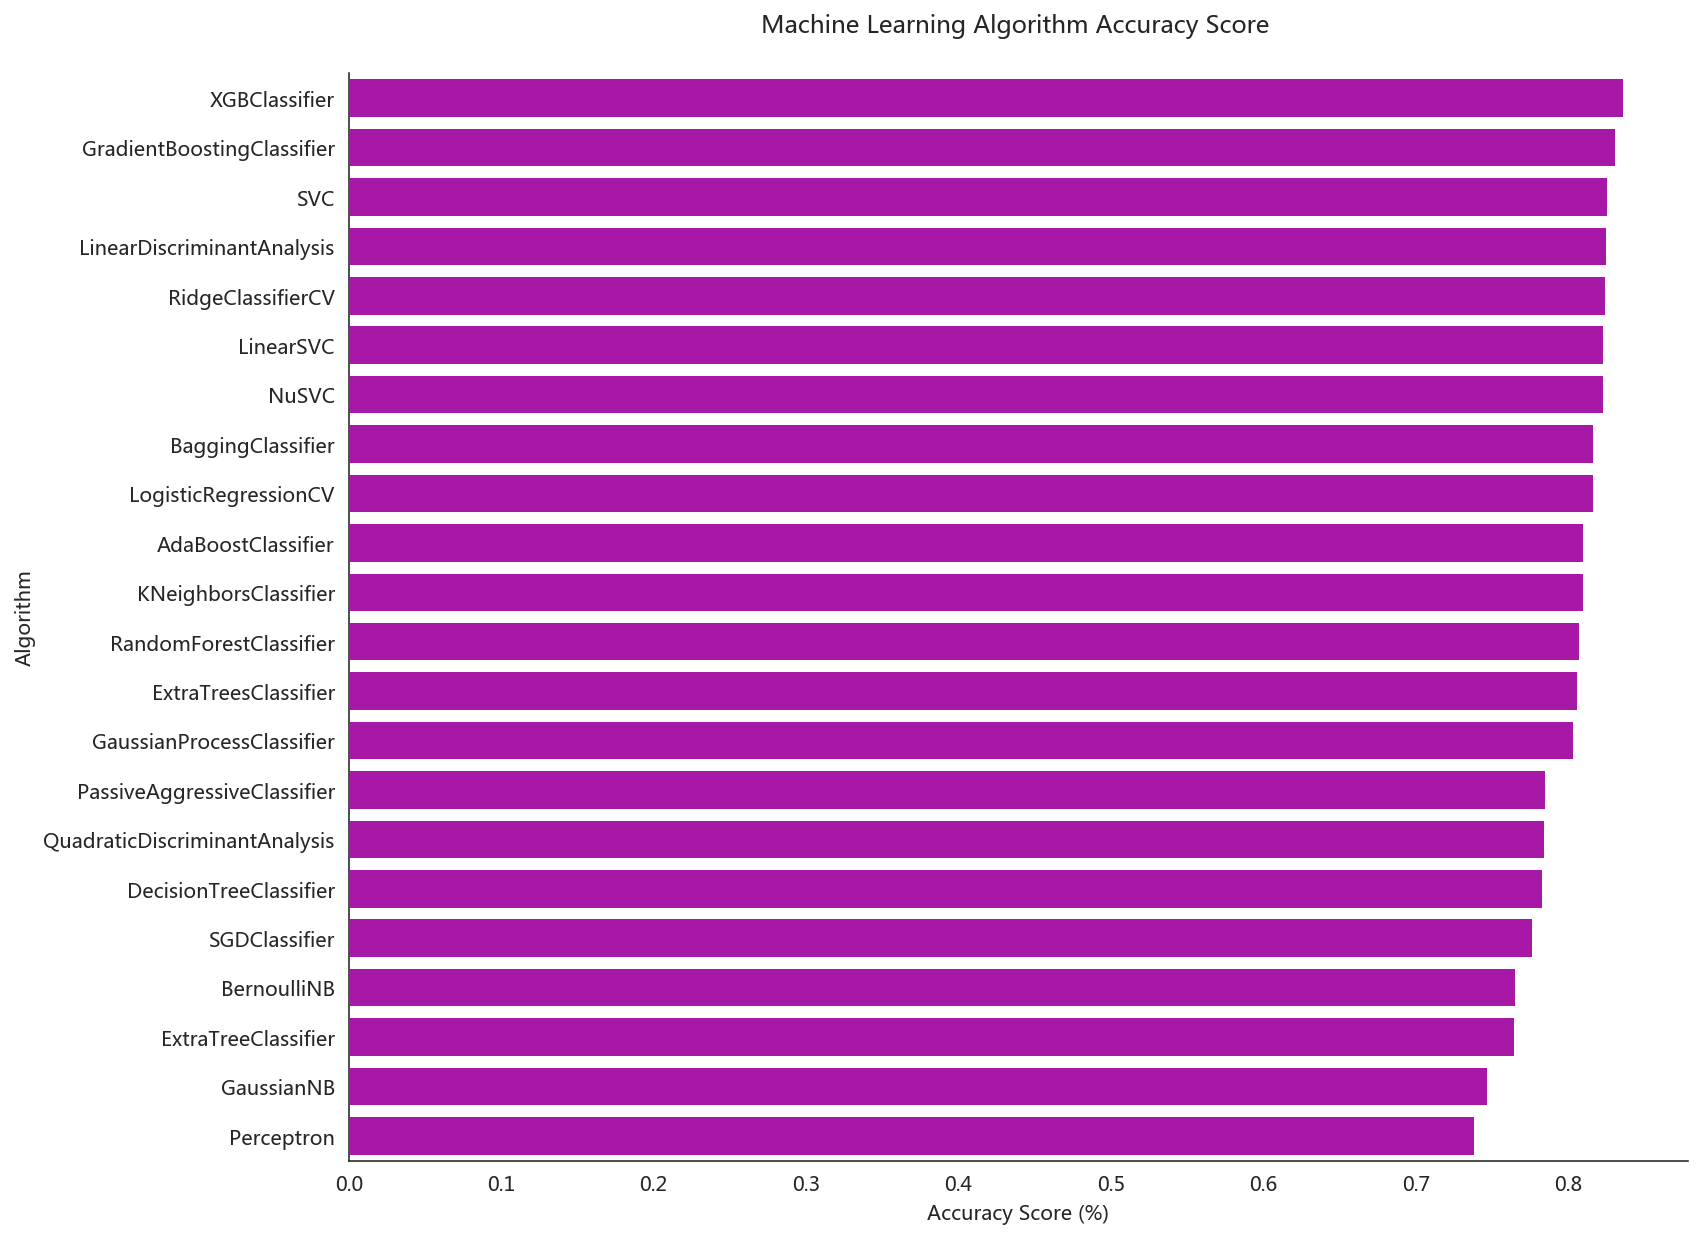

In [121]:
def plot_model_performance(MLA_compare):
    plt.figure(figsize=(12,10))
    sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')
    # prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
    plt.title('Machine Learning Algorithm Accuracy Score \n')
    plt.xlabel('Accuracy Score (%)')
    plt.ylabel('Algorithm')

plot_model_performance(MLA_compare)

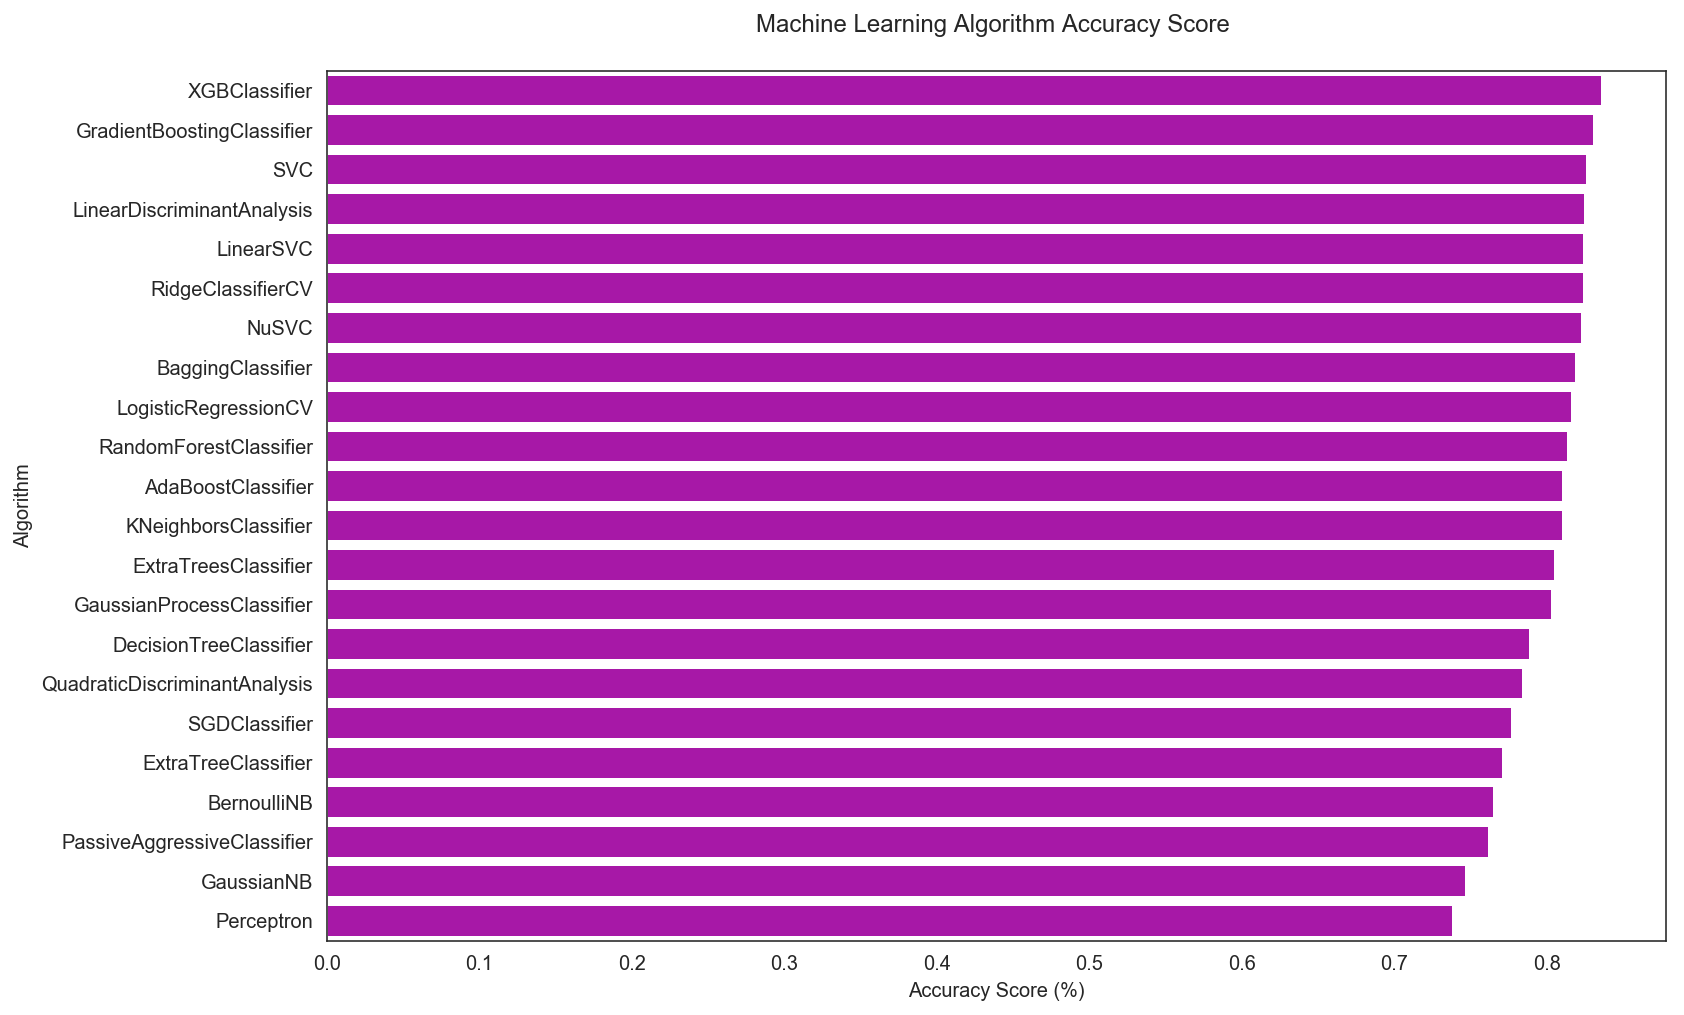

In [124]:
import os
cur_dir = '/Users/mabelfan/Documents/Git/modeling_projects/Titanic_data_analysis'
sorce_dir = '/Users/mabelfan/Documents/python'
os.chdir(sorce_dir)
from utils import select_model
MLA_cp, MLA_pred=select_model.model_compare(X_scaled, y1)
select_model.plot_model_performance(MLA_cp)

In [125]:
os.chdir(cur_dir)

#### PCA降维

In [126]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X_scaled)
print(sum(pca.explained_variance_ratio_))

0.9122942873310691


#### feature importance

In [127]:
model=GradientBoostingClassifier()
model.fit(X1,y1)
fi=pd.DataFrame({'importance':model.feature_importances_},index=X.columns)
fi.sort_values('importance',ascending=False)

,importance
TPP_4.0,4.412396e-01
TPP_3.0,1.246030e-01
TPP_2.0,8.190144e-02
Age,7.818577e-02
Fare,6.735649e-02
calculated_fare,6.046294e-02
title_Mr,3.406496e-02
SibSp,3.012235e-02
Cabin_attr_G,1.741834e-02
fgroup_small,1.033618e-02


#### Select K best features

In [128]:
from sklearn.feature_selection import SelectKBest,chi2

selector = SelectKBest(k=5)  #默认为F值检验算法
selector = selector.fit(X1, y1)
print("the best features choosed by F test are:{}".format([X.columns[i] for i in selector.get_support(indices=True)]))

the best features choosed by F test are:['Sex', 'title_Miss', 'title_Mr', 'title_Mrs', 'TPP_4.0']


In [129]:
selector = SelectKBest(chi2,k=5)
selector = selector.fit(X1, y1)
print("the best features choosed by chi test are:{}".format([X.columns[i] for i in selector.get_support(indices=True)]))

the best features choosed by chi test are:['Sex', 'Fare', 'calculated_fare', 'title_Mr', 'TPP_4.0']


In [130]:
from sklearn.feature_selection import RFE
#递归特征消除法，返回特征选择后的数据

data_rfe = RFE(estimator=LogisticRegression(solver='newton-cg', penalty='l2'),
               n_features_to_select=5).fit(X1, y1)
print("the best features choosed by RFE of logisticRegression are:\n{}".format(
    [X.columns[i] for i in data_rfe.get_support(indices=True)]))

the best features choosed by RFE of logisticRegression are:
['fgroup_loner', 'fgroup_small', 'TPP_2.0', 'TPP_3.0', 'TPP_4.0']


In [131]:
from sklearn.feature_selection import SelectFromModel

#带L1惩罚项的逻辑回归作为基模型的特征选择
data_sfm = SelectFromModel(LogisticRegression(penalty="l1", C=0.1,solver='liblinear')).fit(X1, y1)
print("the best features choosed are:{}".format([X.columns[i] for i in data_sfm.get_support(indices=True)]))

the best features choosed are:['Sex', 'Age', 'SibSp', 'Fare', 'tp', 'calculated_fare', 'Cabin_attr_F', 'title_Mr', 'title_Mrs', 'age_cut_Young Adult', 'fgroup_small', 'TPP_4.0']


```python
SelectKBest(lambda X, Y: tuple(map(tuple,np.array(list(map(lambda x:pearsonr(x, Y), X.T))).T)), \
            k=5).fit_transform(X1, y1)[:10]
```

$r_{pb} = \frac{\sum (x - m_x) (y - m_y)
                   }{\sqrt{\sum (x - m_x)^2 (y - m_y)^2}}$

In [132]:
from scipy.stats import pearsonr
selector = SelectKBest(lambda X, Y: list(np.array([pearsonr(x, Y) for x in X.T]).T), k=5).fit(X1, y1)
print("the best features choosed by Pearsonr are:\n{}".format([X.columns[i] for i in selector.get_support(indices=True)]))

the best features choosed by Pearsonr are:
['Cabin_if', 'tp', 'calculated_fare', 'title_Miss', 'title_Mrs']


#### find out the mis-predicted instances

In [133]:
def mis_idx(n_splits=None):
    rr = []
    model = GradientBoostingClassifier()
    kf = KFold(n_splits=n_splits)
    for train, test in kf.split(X1, y1):
        model.fit(X1[train], y1[train])
        pred = model.predict(X1[test])
        idx = pd.Series(y1)[test][pred != y1[test]].index.values
        rr.append(idx)
    return rr

rr = mis_idx(10)

In [134]:
full_index = np.concatenate(rr)
print('misclassified indeces: {0}\n total amount: {1}'.format(full_index,len(full_index)))

misclassified indeces: [  2   8  14  17  18  21  23  25  34  36  40  41  49  55  68  79  81  85
  92 106 107 118 127 137 139 140 141 146 169 177 181 184 186 187 199 204
 207 209 220 224 226 233 235 240 245 246 248 255 261 262 264 267 271 273
 279 283 286 288 297 298 301 312 315 328 330 338 347 357 391 396 400 404
 414 415 429 444 449 452 453 455 483 484 489 498 501 502 505 507 509 510
 536 543 547 553 554 559 564 569 570 579 587 607 610 622 630 642 643 645
 649 654 657 660 664 673 677 680 681 692 711 712 729 741 744 748 762 766
 767 772 782 786 797 799 804 807 816 821 828 830 839 852 854 857 867 889]
 total amount: 144


In [135]:
errPred = titanic_feat.iloc[full_index,:]
errPred.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_if,fsize,is_alone,tp,n_ticket,calculated_fare,name_length,TPP
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,419.041667,0.625000,2.326389,29.941147,0.458333,0.298611,28.149856,0.263889,1.756944,0.618056,0.388889,1.944444,15.401767,28.034722,2.895833
std,259.334972,0.485813,0.891529,12.421778,0.801005,0.794032,34.081086,0.442278,1.328791,0.487559,0.489200,1.671555,13.278982,10.067196,0.936582
min,3.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,12.000000,1.000000
25%,207.250000,0.000000,1.000000,22.000000,0.000000,0.000000,7.925000,0.000000,1.000000,0.000000,0.000000,1.000000,7.750000,21.000000,2.000000
50%,410.000000,1.000000,3.000000,28.318910,0.000000,0.000000,15.245800,0.000000,1.000000,1.000000,0.000000,1.000000,8.050000,26.000000,3.000000
75%,647.000000,1.000000,3.000000,37.000000,1.000000,0.000000,30.500000,1.000000,2.000000,1.000000,1.000000,2.000000,26.069275,32.000000,4.000000
max,890.000000,1.000000,3.000000,80.000000,4.000000,5.000000,247.520800,1.000000,7.000000,1.000000,1.000000,8.000000,82.506933,57.000000,4.000000


In [136]:
errPred.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked,Cabin_attr,title,fgroup,fare_cut,nlength_group
count,144,144,144,144,144,144,144,144,144,144
unique,144,2,135,38,3,8,5,3,4,4
top,"Lindqvist, Mr. Eino William",male,1601,Unknown,S,F,Mr,loner,very_low,medium
freq,1,84,4,106,102,59,77,89,56,82


In [137]:
errPred.groupby(['title','Pclass'])['Survived'].agg([('average','mean'),('number','count')])

average  number
title         Pclass                  
Master        3       1.000000       2
Miss          1       0.000000       2
              2       0.000000       2
              3       0.419355      31
Mr            1       0.575758      33
              2       0.888889       9
              3       0.971429      35
Mrs           1       0.000000       1
              2       0.000000       4
              3       0.600000      20
selected_male 1       0.400000       5

In [138]:
errPred.groupby(['title','Pclass','Parch','SibSp'])['Survived'].agg([('average','mean'),('number','count')])

average  number
title         Pclass Parch SibSp                  
Master        3      1     1      1.000000       1
                     2     4      1.000000       1
Miss          1      0     0      0.000000       1
                     2     1      0.000000       1
              2      0     0      0.000000       2
              3      0     0      0.391304      23
                           1      0.000000       2
                           2      1.000000       1
                     1     1      0.000000       1
                     2     0      1.000000       1
                           3      0.000000       1
                           4      1.000000       2
Mr            1      0     0      0.705882      17
                           1      0.454545      11
                     1     0      0.000000       2
                           1      0.666667       3
              2      0     0      0.875000       8
                           1      1.000000       1
              3      0     0      0.967742      31
                           1      1.000000       2
                           2      1.000000       1
                     1     1      1.000000       1
Mrs           1      2     1      0.000000       1
              2      0     0      0.000000       1
                           1      0.000000       2
                     1     1      0.000000       1
              3      0     0      0.666667       3
                           1      0.571429       7
                           3      1.000000       1
                     1     1      0.500000       4
                     2     0      0.666667       3
                     5     1      0.500000       2
selected_male 1      0     0      0.333333       3
                           2      0.500000       2

'Mr','Pclass 1','Parch 0','SibSp 0', 19  
'Mr','Pclass 1','Parch 0','SibSp 1', 11  
'Mr','Pclass 3'|'Pclass 2','Parch 0','SibSp 0', 30+8  
'Miss','Pclass 3','Parch 0','SibSp 0', 25  

In [139]:
titanic_feat.loc[(titanic_feat.title=='Mr')&(titanic_feat.Pclass==1)&(titanic_feat.Parch==0)&(titanic_feat.SibSp==0),'MPPS']=2
titanic_feat.loc[(titanic_feat.title=='Mr')&((titanic_feat.Pclass==3)|(titanic_feat.Pclass==2))&(titanic_feat.Parch==0)&(titanic_feat.SibSp==0),'MPPS']=1
titanic_feat.loc[(titanic_feat.title=='Miss')&(titanic_feat.Pclass==3)&(titanic_feat.Parch==0)&(titanic_feat.SibSp==0),'MPPS']=4
titanic_feat.loc[(titanic_feat.title=='Mr')&(titanic_feat.Pclass==1)&(titanic_feat.Parch==0)&(titanic_feat.SibSp==1),'MPPS']=4
titanic_feat.MPPS.fillna(3,inplace=True)
titanic_feat.MPPS.value_counts()

3.0    606
1.0    480
4.0    123
2.0    100
Name: MPPS, dtype: int64

#### Rechoose and scale the data

In [140]:
# choose the features for modeling
titanic_est2 = pd.get_dummies(titanic_feat, columns=['Pclass', 'Embarked', 'Cabin_attr','title', 'age_cut',
                                                     'fgroup','fare_cut','TPP','nlength_group','MPPS'],drop_first=True)
titanic_est2.drop(['Name','Ticket','Cabin','fsize','n_ticket','name_length'],axis=1,inplace=True)

titanic_est2 = titanic_est2.set_index(['PassengerId'])

# change Sex to int number
titanic_est2['Sex'] = (titanic_est2['Sex'] == 'male').astype('int')
titanic_est2['tp'] = titanic_est2['tp'].astype('int')

In [141]:
#titanic_est2.to_csv('titanic_fn.csv')

In [142]:
X = titanic_est2.drop(['Survived'],axis=1)

X1 = X[:891].values
X2 = X[891:].values
y1 = titanic_est2['Survived'][:891].values

print("train_data size: {0}\ntest_data size: {1}\ntrain_target size: {2}".format(X1.shape, X2.shape, y1.shape))

train_data size: (891, 44)
test_data size: (418, 44)
train_target size: (891,)


In [143]:
scaler=StandardScaler().fit(X1)
X_scaled=scaler.transform(X1)
X_test_scaled=scaler.transform(X2)

#### split data into train & test

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y1, test_size=0.4, random_state=1)

## 6 Modeling the data

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

**1) DecisionTree**

In [146]:
entroy_threshold = np.linspace(0, .1, 50)
parameters = {'min_impurity_decrease':entroy_threshold}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy',random_state=0),parameters, 
                   iid=False, cv=5,scoring='accuracy',return_train_score=True)
clf.fit(X_train, y_train)
print("best param: {0}\n best score: {1}".format(clf.best_params_, clf.best_score_))

best param: {'min_impurity_decrease': 0.020408163265306124}
 best score: 0.825611460517121


In [147]:
clf_grid = clf.best_estimator_
train_score = clf_grid.score(X_train, y_train)
test_score = clf_grid.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

train score: 0.8370786516853933; test score: 0.7955182072829131


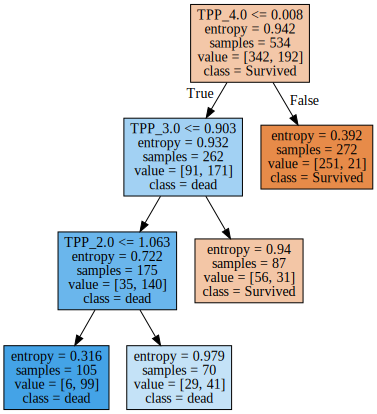

In [156]:
from sklearn.tree import export_graphviz
import graphviz
data = export_graphviz(clf_grid, out_file=None, feature_names=X.columns, class_names=['Survived','dead'], filled=True)
graph = graphviz.Source(data)
graph

In [217]:
titanic_est2['TPP_4.0'].unique()

array([1, 0], dtype=uint64)

TPP_4.0 < 0.008说明该叶节点中的TPP_4.0均为0，从其他特征找出生还与未生还的差异。

In [216]:
node12_S = titanic_est2.loc[(titanic_est2['TPP_4.0'] <=0.008)&(titanic_est2.Survived==1),:]
node12_D = titanic_est2.loc[(titanic_est2['TPP_4.0'] <=0.008)&(titanic_est2.Survived==0),:]

test_cols = titanic_est2.drop(['Survived'],axis=1).columns
test_df = pd.DataFrame(columns=['statistic','pvalue'], index = test_cols)
for i in test_cols:
    test_df.loc[i,:] = stats.ttest_ind(node12_S[i], node12_D[i])

test_df.sort_values(by='pvalue',ascending=True)

,statistic,pvalue
TPP_3.0,-10.4111,7.1358e-23
Sex,-8.45575,3.96602e-16
title_Mr,-8.25026,1.78693e-15
MPPS_3.0,6.74649,4.70538e-11
MPPS_2.0,-6.51178,2.00075e-10
Pclass_2,6.14569,1.76422e-09
Cabin_attr_G,-5.22656,2.65561e-07
fgroup_small,4.57195,6.26348e-06
title_Mrs,4.34492,1.72601e-05
tp,4.11105,4.68737e-05


In [189]:
from sklearn.preprocessing import LabelEncoder

#titanic_notDummy = titanic_feat.drop(['Name','Ticket','Cabin','fsize','n_ticket','name_length'],axis=1)
#titanic_notDummy =titanic_notDummy.set_index(['PassengerId'])
titanic_notDummy = titanic_feat.set_index(['PassengerId'])
# change Sex to int number
titanic_notDummy['Sex'] = (titanic_notDummy['Sex'] == 'male').astype('int')
titanic_notDummy['tp'] = titanic_notDummy['tp'].astype('int')

strCol = ['Embarked', 'Cabin_attr','title','age_cut','fgroup','fare_cut','nlength_group']
for i in strCol:
    le = LabelEncoder().fit(titanic_notDummy[i])
    titanic_notDummy[i] = le.transform(titanic_notDummy[i])

X_nd = titanic_notDummy.drop(['Survived'],axis=1)

X1_nd = X_nd[:891].values
X2_nd = X_nd[891:].values
y1_nd = titanic_notDummy['Survived'][:891].values

print("train_data size: {0}\ntest_data size: {1}\ntrain_target size: {2}".format(X1_nd.shape, X2_nd.shape, y1_nd.shape))

train_data size: (891, 19)
test_data size: (418, 19)
train_target size: (891,)


In [204]:
from sklearn.model_selection import train_test_split
Xnd_train, Xnd_test, ynd_train, ynd_test = train_test_split(X1_nd, y1_nd, test_size=0.4, random_state=1)

entroy_threshold = np.linspace(0, .1, 50)
parameters = [{'min_impurity_decrease':entroy_threshold},
              {'max_depth':range(2,10)}]

clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy',random_state=0),parameters, 
                   iid=False, cv=5,scoring='accuracy',return_train_score=True)
clf.fit(Xnd_train, ynd_train)
print("best param: {0}\n best score: {1}".format(clf.best_params_, clf.best_score_))

clf_grid = clf.best_estimator_
train_score = clf_grid.score(Xnd_train, ynd_train)
test_score = clf_grid.score(Xnd_test, ynd_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

best param: {'min_impurity_decrease': 0.010204081632653062}
 best score: 0.8518518518518519
train score: 0.850187265917603; test score: 0.7983193277310925


Using the data that is not scaled and not apply one-hot encoding, train score and test score are improved a bit compared to previous one.

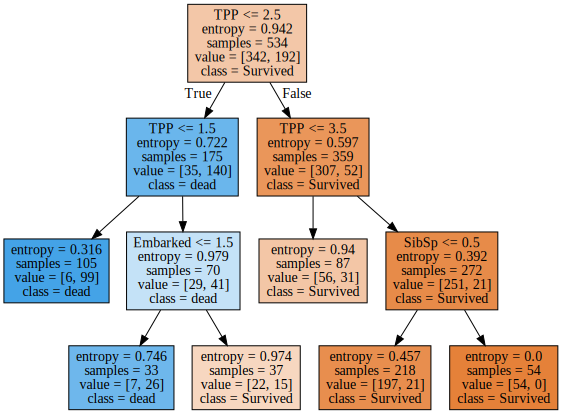

In [205]:
from sklearn.tree import export_graphviz
import graphviz
data = export_graphviz(clf_grid, out_file=None, feature_names=X_nd.columns, class_names=['Survived','dead'], filled=True)
graph = graphviz.Source(data)
graph

In [255]:
node32 = titanic_notDummy[titanic_notDummy.Survived.notnull()].loc[(titanic_notDummy['TPP'] <=2.5)&(titanic_notDummy['TPP'] >1.5)&(titanic_notDummy['Embarked'] >1.5),:]
node32_S = node32[titanic_notDummy.Survived==1]
node32_D = node32[titanic_notDummy.Survived==0]

test_cols = titanic_notDummy.drop(['Survived'],axis=1).columns
test_df = pd.DataFrame(columns=['statistic','pvalue'], index = test_cols)
for i in test_cols:
    test_df.loc[i,:] = stats.ttest_ind(node32_S[i], node32_D[i])

test_df.sort_values(by='pvalue',ascending=True)

,statistic,pvalue
fgroup,1.89983,0.0621089
Cabin_attr,-1.683,0.0974039
SibSp,-1.21821,0.227759
fare_cut,-1.17513,0.244437
title,0.899029,0.372115
calculated_fare,0.767683,0.44559
Cabin_if,0.748312,0.457101
age_cut,0.458909,0.647904
Fare,0.325981,0.745536
Pclass,-0.319333,0.750547


In [256]:
print(len(node32),len(node32_D),len(node32_S))

64 36 28


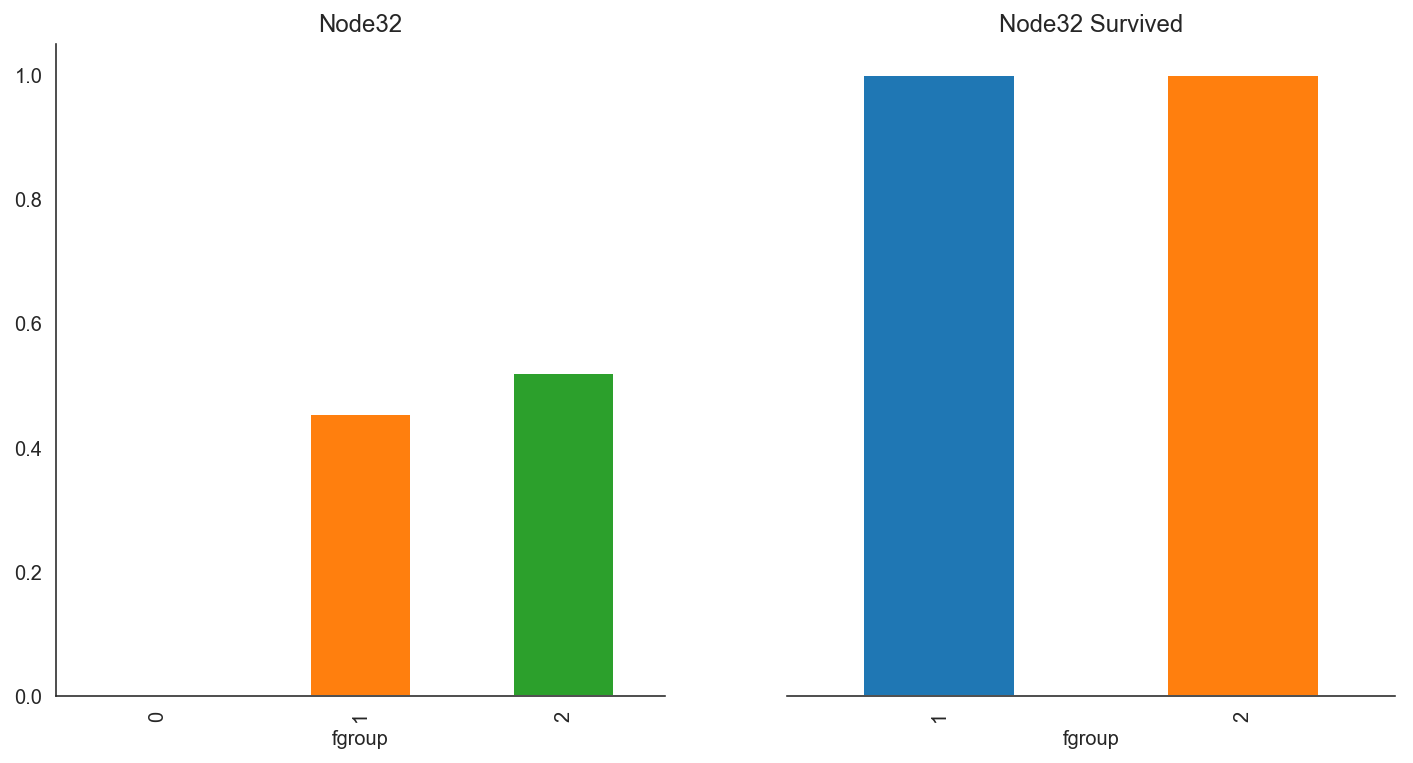

In [262]:
f, ax = plt.subplots(1,2,sharey=True,figsize=(12,6))
node32.groupby('fgroup')['Survived'].mean().plot(kind='bar',ax=ax[0])
ax[0].set_title('Node32')
ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')
node32_S.groupby('fgroup')['Survived'].mean().plot(kind='bar',ax=ax[1])
ax[1].set_title('Node32 Survived')
ax[1].spines['right'].set_color('none')
ax[1].spines['top'].set_color('none')
ax[1].spines['left'].set_color('none')
plt.show()

In [266]:
node32.groupby(['Cabin_attr','fgroup'])['Survived'].mean().sort_values(ascending=False)

Cabin_attr  fgroup
4           2         1.000000
2           1         1.000000
1           2         1.000000
4           1         0.666667
6           2         0.500000
5           1         0.444444
            2         0.200000
7           1         0.000000
6           0         0.000000
2           2         0.000000
1           1         0.000000
Name: Survived, dtype: float64

In [271]:
titanic_tree = titanic_notDummy.copy()
titanic_tree['CbFg'] = None
titanic_tree.loc[((titanic_tree.Cabin_attr==4)|(titanic_tree.Cabin_attr==1))&(titanic_tree.fgroup==2),'CbFg']=1
titanic_tree.loc[(titanic_tree.Cabin_attr==2)&(titanic_tree.fgroup==1),'CbFg']=1
titanic_tree.loc[(titanic_tree.Cabin_attr==4)&(titanic_tree.fgroup==1),'CbFg']=2
titanic_tree.loc[(titanic_tree.Cabin_attr==5)&(titanic_tree.fgroup==1),'CbFg']=2
titanic_tree.loc[(titanic_tree.Cabin_attr==6)&(titanic_tree.fgroup==2),'CbFg']=2
titanic_tree.loc[titanic_tree.CbFg.isnull(),'CbFg'] = 3
titanic_tree.CbFg.unique()

array([3, 2, 1])

In [273]:
X_nd = titanic_tree.drop(['Survived'],axis=1)

X1_nd = X_nd[:891].values
X2_nd = X_nd[891:].values
y1_nd = titanic_tree['Survived'][:891].values

print("train_data size: {0}\ntest_data size: {1}\ntrain_target size: {2}".format(X1_nd.shape, X2_nd.shape, y1_nd.shape))

train_data size: (891, 20)
test_data size: (418, 20)
train_target size: (891,)


In [275]:
from sklearn.model_selection import train_test_split
Xnd_train, Xnd_test, ynd_train, ynd_test = train_test_split(X1_nd, y1_nd, test_size=0.4, random_state=1)

entroy_threshold = np.linspace(0, .1, 50)
parameters = [{'min_impurity_decrease':entroy_threshold},
              {'max_depth':range(2,10)}]

clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy',random_state=0),parameters, 
                   iid=False, cv=5,scoring='accuracy',return_train_score=True)
clf.fit(Xnd_train, ynd_train)
print("best param: {0}\n best score: {1}".format(clf.best_params_, clf.best_score_))

clf_grid = clf.best_estimator_
train_score = clf_grid.score(Xnd_train, ynd_train)
test_score = clf_grid.score(Xnd_test, ynd_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

best param: {'max_depth': 3}
 best score: 0.8594689028651293
train score: 0.8614232209737828; test score: 0.7927170868347339


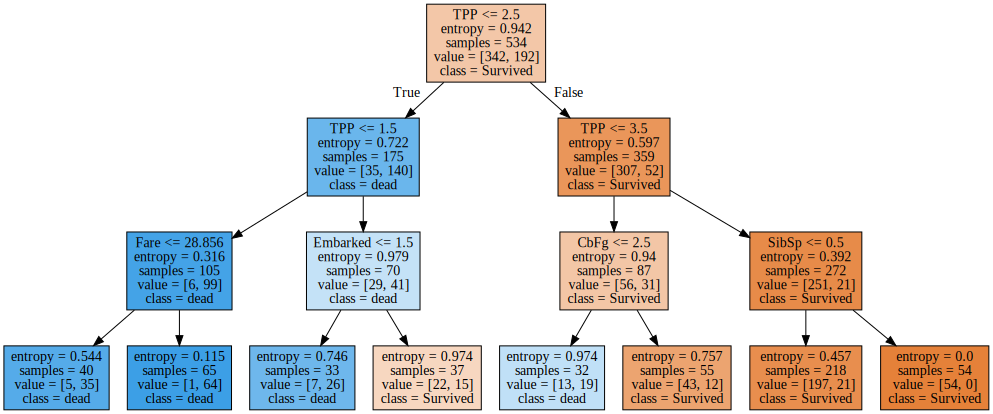

In [276]:
from sklearn.tree import export_graphviz
import graphviz
data = export_graphviz(clf_grid, out_file=None, feature_names=X_nd.columns, class_names=['Survived','dead'], filled=True)
graph = graphviz.Source(data)
graph

针对上一棵树中的32节点（value=[22,15]）创建了特征CbFg，经训练后，预测准确性没有得到提升，与此树中的34结果是一样的。

In [278]:
gini_threshold = np.linspace(0, .01, 50)
parameters = {'min_impurity_decrease':gini_threshold}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

clf = GridSearchCV(DecisionTreeClassifier(criterion='gini',random_state=0),parameters, \
                   iid=False, cv=5,scoring=acc_scorer,return_train_score=True)
clf.fit(X_train, y_train)
print("best param: {0}\n best score: {1}".format(clf.best_params_, clf.best_score_))

best param: {'min_impurity_decrease': 0.005510204081632653}
 best score: 0.8425925925925926


In [279]:
clf_grid = clf.best_estimator_
train_score = clf_grid.score(X_train, y_train)
test_score = clf_grid.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

train score: 0.850187265917603; test score: 0.7983193277310925


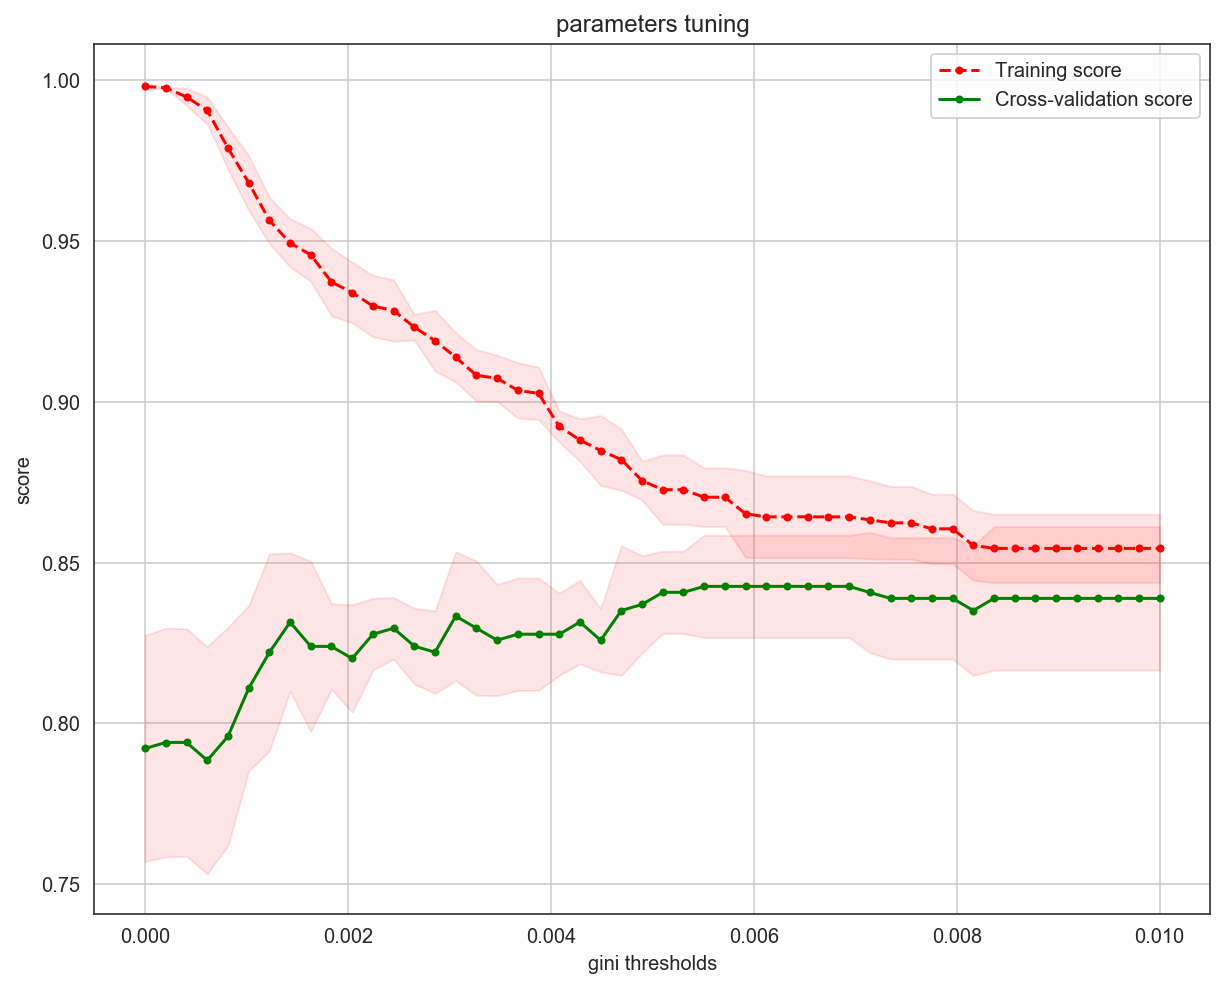

In [280]:
import os
cur_dir = '/Users/mabelfan/Documents/Git/modeling_projects/Titanic_data_analysis'
sorce_dir = '/Users/mabelfan/Documents/python'
os.chdir(sorce_dir)
from utils import training
training.plot_learning_curve(gini_threshold, clf.cv_results_, 'gini thresholds')
os.chdir(cur_dir)

In [281]:
entropy_threshold = np.linspace(0, .1, 50)
gini_threshold = np.linspace(0, .01, 50)
parameters = [{'max_depth': range(2,10)},
              {'min_samples_split': range(2,30,2)}]

clf = GridSearchCV(DecisionTreeClassifier(),parameters, 
                   iid=False, cv=5, scoring=acc_scorer, return_train_score=True)
clf.fit(X_train, y_train)
print("best param: {0}\n best score: {1}".format(clf.best_params_, clf.best_score_))

best param: {'max_depth': 4}
 best score: 0.8350803633822503


In [282]:
clf_grid = clf.best_estimator_
train_score = clf_grid.score(X_train, y_train)
test_score = clf_grid.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

train score: 0.8651685393258427; test score: 0.7955182072829131


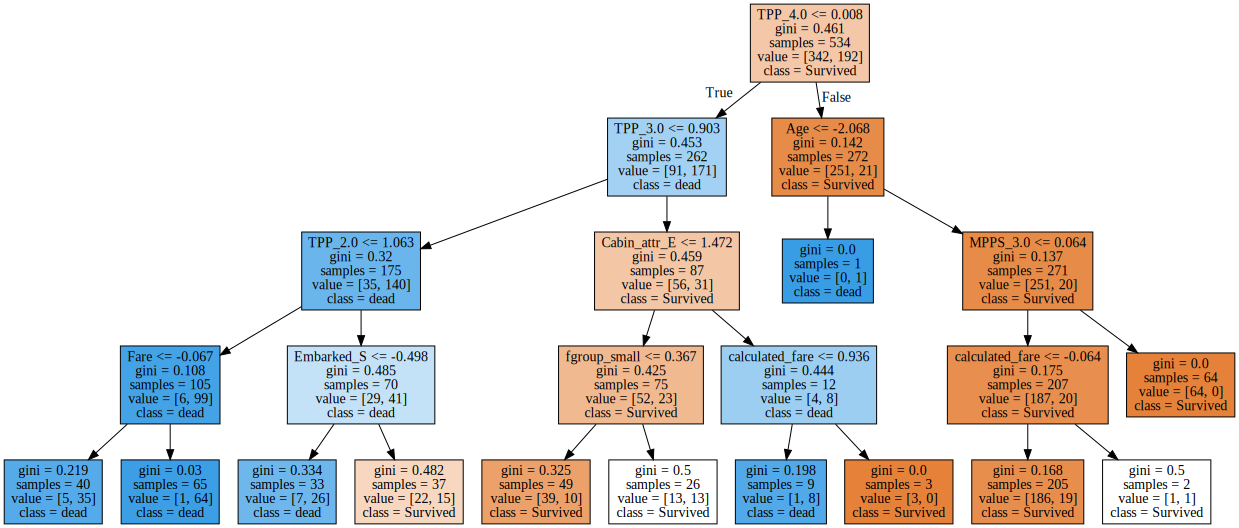

In [283]:
import graphviz
data = export_graphviz(clf_grid, out_file=None,feature_names=X.columns, class_names=['Survived','dead'], filled=True)
graph = graphviz.Source(data)
graph

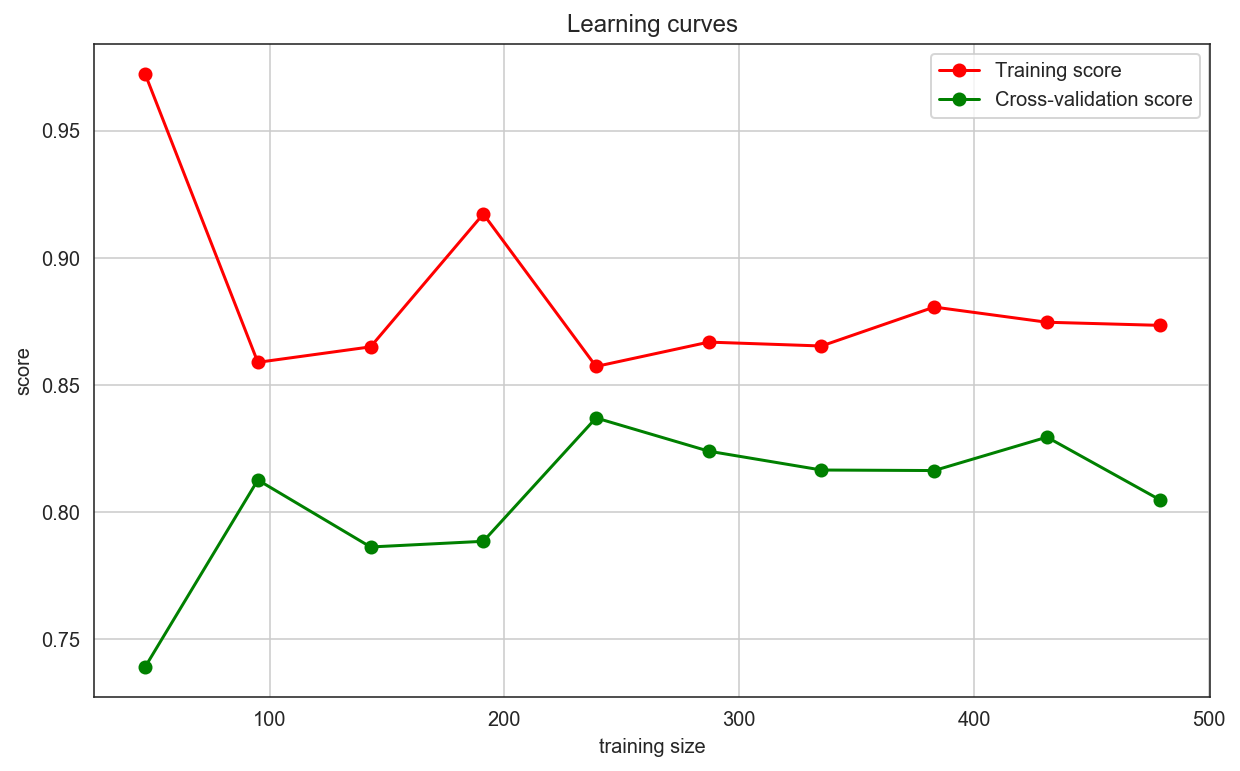

In [284]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores_clf, test_scores_clf = learning_curve(clf, X_train, y_train, 
                                                                train_sizes=np.linspace(0.1, 1, 10),
                                                                scoring=acc_scorer, cv=10)

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_sizes, train_scores_clf.mean(1), 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_clf.mean(1), 'o-', color="g",label="Cross-validation score")
plt.xlabel("training size")
plt.ylabel("score")
plt.title('Learning curves')
plt.legend(loc="best")
plt.show();

In [285]:
def plot_learning_curve(plt, estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, 
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o--', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

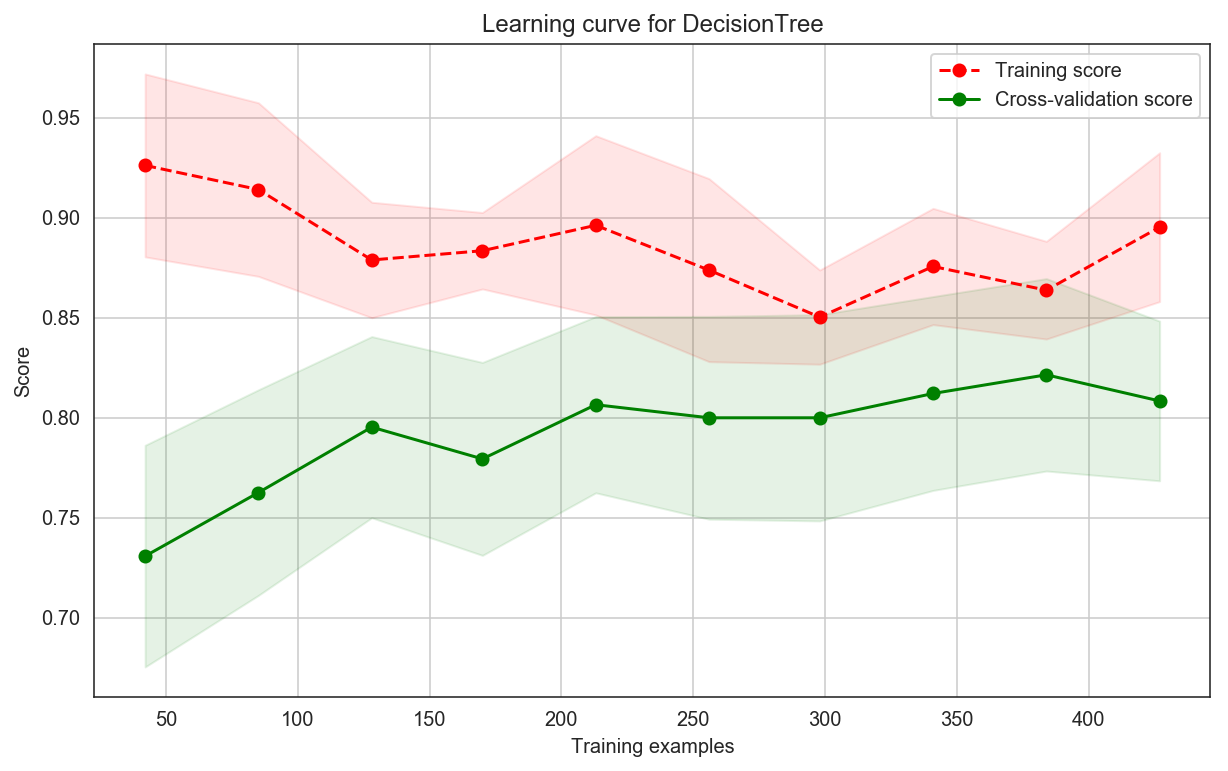

In [286]:
from sklearn.model_selection import ShuffleSplit

cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plt.figure(figsize=(10,6))
plot_learning_curve(plt, clf, "Learning curve for DecisionTree", X_train, y_train, \
                    cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.show();

DT:   
best param: {'min_impurity_decrease': 0.005510204081632653}  
test score: 0.7983193277310925  

**2) Logistic Regression**

In [287]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def polynomial_model(degree=1, **kwarg):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    logistic_regression = LogisticRegression(**kwarg)
    pipeline = Pipeline([("polynomial_feature",polynomial_features),
                        ("logistic_regression",logistic_regression)])
    return pipeline

In [288]:
model = polynomial_model(degree=2, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
cv_score = model.score(X_test, y_test)
print("train_score:{};cv_score:{}".format(train_score,cv_score))

train_score:0.9456928838951311;cv_score:0.7647058823529411


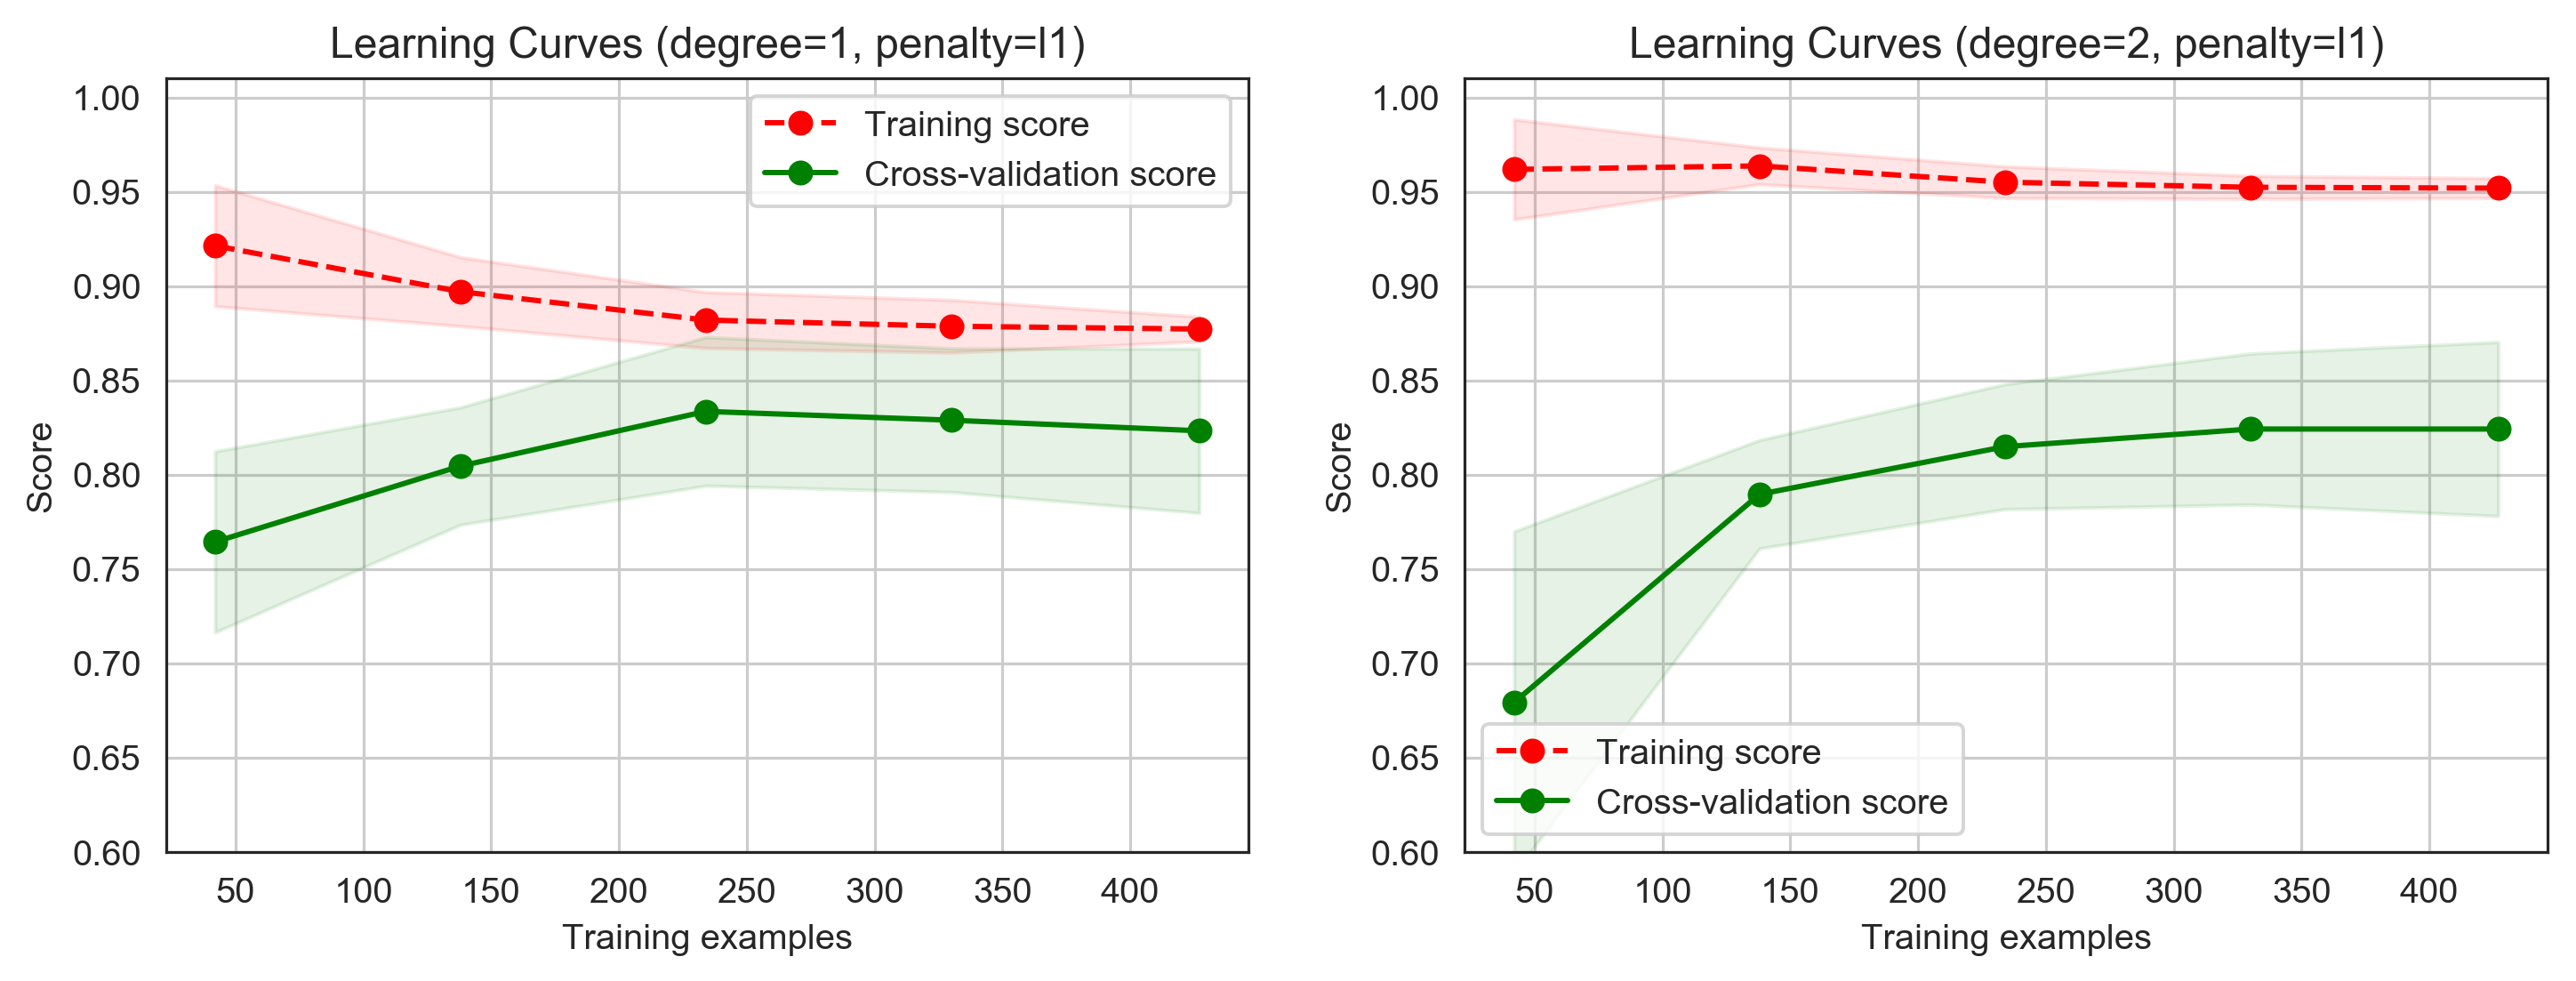

In [289]:
title = 'Learning Curves (degree={0}, penalty={1})'
degrees = [1, 2]
penalty = 'l1'

plt.figure(figsize=(12, 4), dpi=144)
for i in range(len(degrees)):
    plt.subplot(1, len(degrees), i + 1)
    plot_learning_curve(plt, polynomial_model(degree=degrees[i], penalty=penalty, 
                                              solver='liblinear',max_iter=500), 
                        title.format(degrees[i], penalty), X_train, y_train, ylim=(0.6, 1.01), cv=cv)

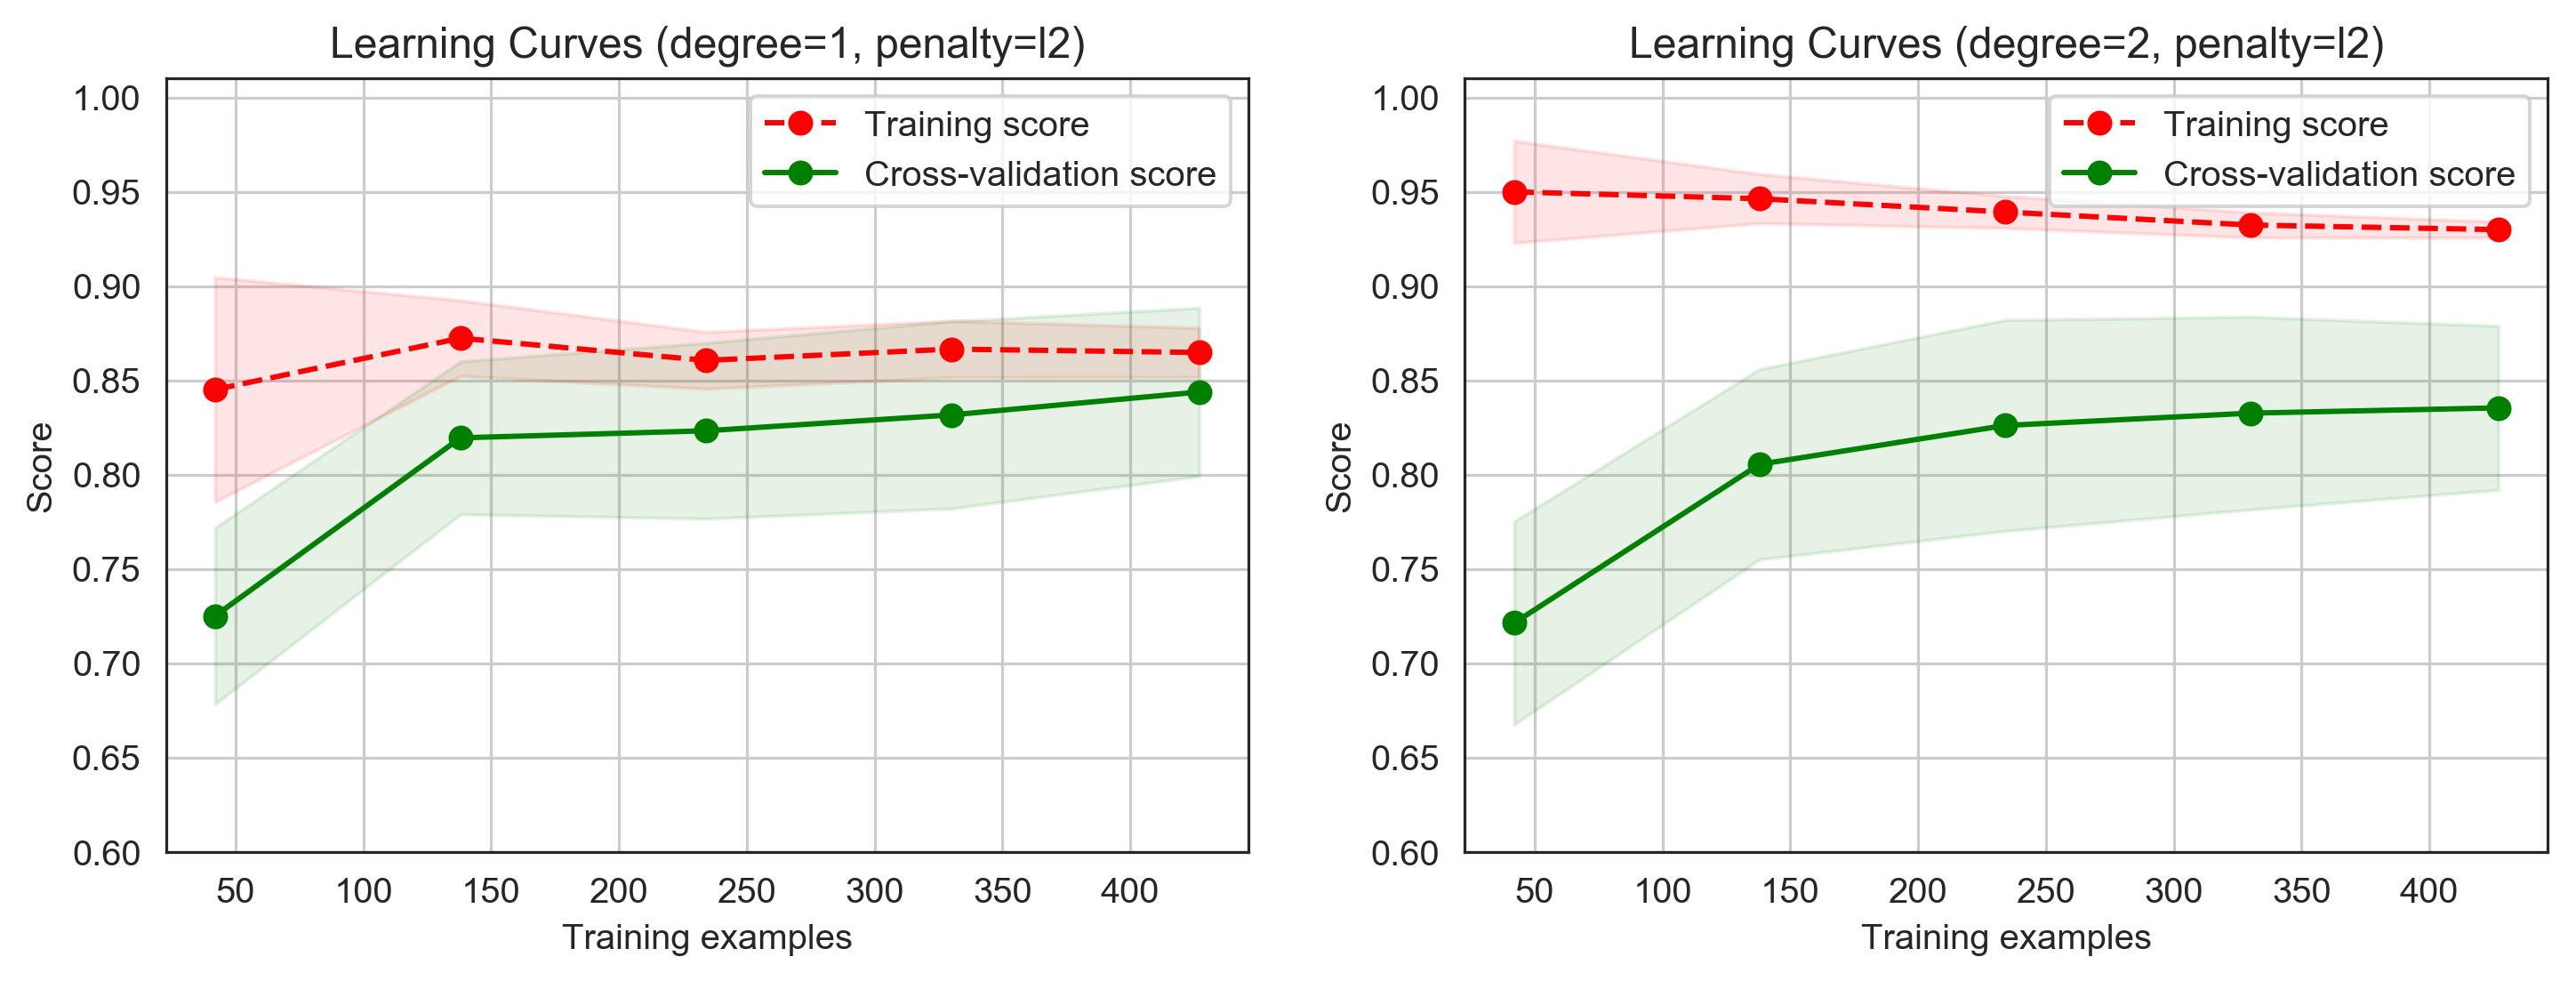

In [290]:
title = 'Learning Curves (degree={0}, penalty={1})'
degrees = [1, 2]
penalty = 'l2'

plt.figure(figsize=(12, 4), dpi=144)
for i in range(len(degrees)):
    plt.subplot(1, len(degrees), i + 1)
    plot_learning_curve(plt, polynomial_model(degree=degrees[i], penalty=penalty, 
                                              solver='newton-cg', C=0.01, max_iter=300), 
                        title.format(degrees[i], penalty), X_train, y_train, ylim=(0.6, 1.01), cv=cv)

In [291]:
model = polynomial_model(degree=2, penalty='l2', solver='newton-cg', C=0.01)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
cv_score = model.score(X_test, y_test)
print("train_score:{};cv_score:{}".format(train_score,cv_score))

train_score:0.9269662921348315;cv_score:0.7703081232492998


对于degree=2的模型没有足够的数据供训练，出现很高有variance.

In [292]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

param_grid = {"C":np.linspace(0.001,1.0,50),
              "solver":['liblinear','newton-cg', 'lbfgs']}
model = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv, iid=False)
model.fit(X_train, y_train)

print("best_params:{}\nbest_score:{}".format(model.best_params_, model.best_score_))

best_params:{'C': 0.021387755102040818, 'solver': 'newton-cg'}
best_score:0.8429906542056076


In [294]:
model.best_estimator_.score(X_test,y_test)

0.7899159663865546

roc: 0.84


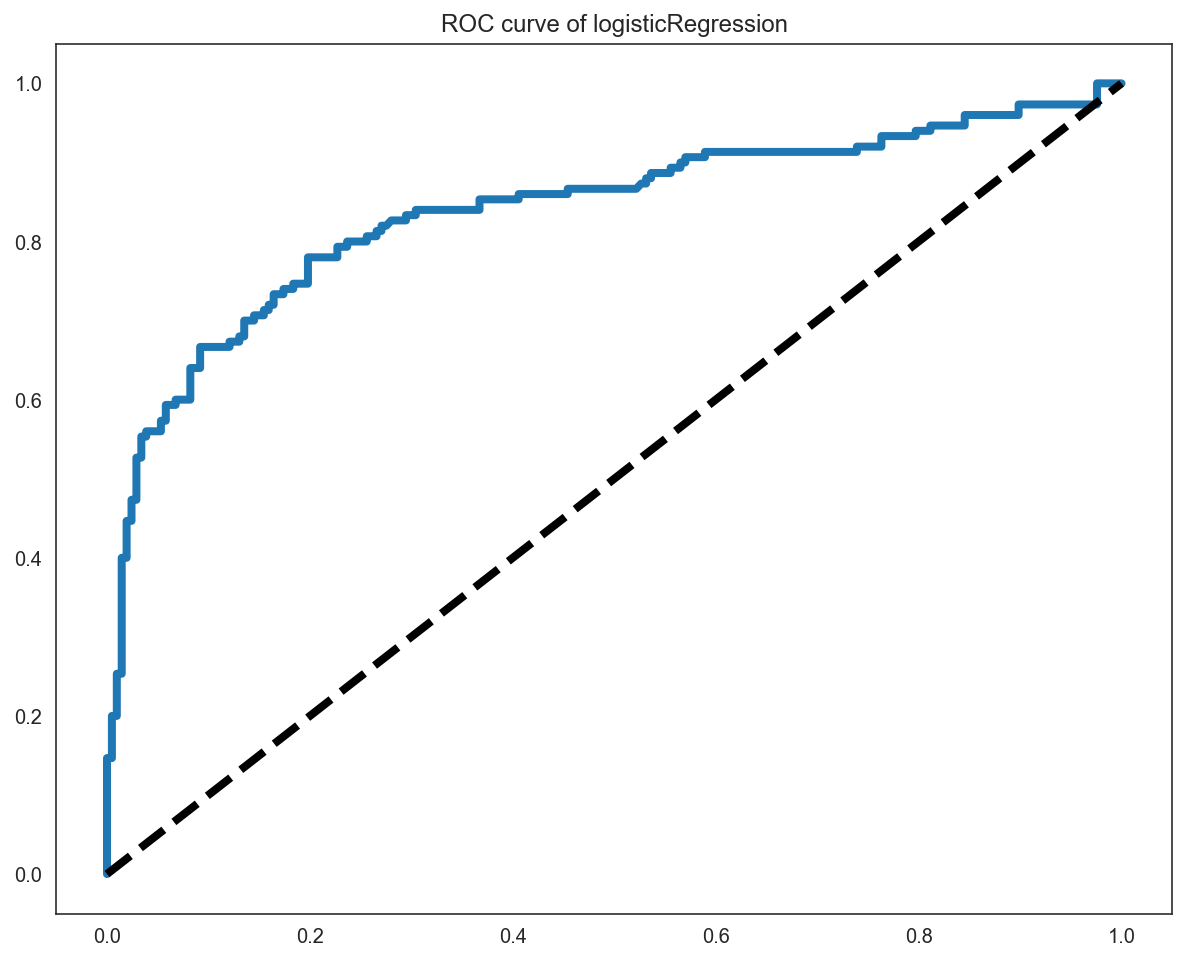

In [297]:
from sklearn.metrics import roc_curve, auc

y_score = model.decision_function(X_test)
FPR, TPR, _ = roc_curve(y_test, y_score)
roc_auc = auc(FPR, TPR)
print("roc:", round(roc_auc,2))

plt.figure(figsize=(10,8))
plt.plot(FPR, TPR, label='ROC curve(area=%0.2f)'%roc_auc, linewidth=4)
plt.plot([0,1],[0,1],'k--',linewidth=4)
plt.title("ROC curve of logisticRegression")
plt.show();

LR:  
best_params:{'C': 0.021387755102040818, 'solver': 'newton-cg'}  
test score: 0.7899159663865546  

**3) AdaBoost Classifier**

In [298]:
from sklearn.ensemble import AdaBoostClassifier
param_grid={'n_estimators':[30,50,80,120,200],'learning_rate':[0.01,0.05,0.1,0.5,1]}
AdaBC=GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4)),param_grid,cv=5, iid=False)

AdaBC.fit(X_train,y_train)

AdaBC.best_params_,AdaBC.best_score_

({'learning_rate': 0.01, 'n_estimators': 120}, 0.8425925925925928)

In [299]:
AdaBC.best_estimator_.score(X_test, y_test)

0.7927170868347339

**4) Gradient Boosting Decision Tree**

In [300]:
param_grid={'n_estimators':[30,50,80,120,200],'learning_rate':[0.01,0.05,0.1,0.5,1],'max_depth':[2,3,4,5,6]}
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5, iid=False)

grid_search.fit(X_train,y_train)

grid_search.best_params_,grid_search.best_score_

({'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200},
 0.8557302585604472)

In [301]:
GBT_grid = grid_search.best_estimator_
y_pred = GBT_grid.predict(X_test)
accuracy_score(y_pred, y_test)

0.7899159663865546

In [302]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[183  24]
 [ 51  99]]


**5) RandomForest Classifier**

In [303]:
# Choose the type of classifier. 
RF = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [6, 8, 10], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              #'min_impurity_decrease':np.linspace(0,.1,50),
              'max_depth': [3, 5, 8], 
              'min_samples_split': [3, 5, 8],
              'min_samples_leaf': [5, 8]
             }

# Run the grid search
RF_grid = GridSearchCV(RF, parameters, scoring=acc_scorer,iid=False,cv=5)
RF_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'n_estimators': [6, 8, 10], 'max_features': ['log2', 'sqrt', 'auto'], 'criterion': ['entropy', 'gini'], 'max_depth': [3, 5, 8], 'min_samples_split': [3, 5, 8], 'min_samples_leaf': [5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [305]:
RF_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 10}

In [304]:
train_score = RF_grid.score(X_train, y_train)
test_score = RF_grid.score(X_test, y_test)
print('train score: {0}\ntest score: {1}'.format(train_score, test_score))

train score: 0.8838951310861424
test score: 0.803921568627451


In [321]:
from sklearn.model_selection import StratifiedKFold
def run_kfold(clf):
    kf = StratifiedKFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X1,y1):
        fold += 1
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = y1[train_index], y1[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(RF_grid)

Fold 1 accuracy: 0.8222222222222222
Fold 2 accuracy: 0.8444444444444444
Fold 3 accuracy: 0.7640449438202247
Fold 4 accuracy: 0.8202247191011236
Fold 5 accuracy: 0.8426966292134831
Fold 6 accuracy: 0.797752808988764
Fold 7 accuracy: 0.8314606741573034
Fold 8 accuracy: 0.7865168539325843
Fold 9 accuracy: 0.8539325842696629
Fold 10 accuracy: 0.8522727272727273
Mean Accuracy: 0.821556860742254


**6) k-Nearest Neighbors**

In [323]:
param_grid={'n_neighbors':[4,5,6,7,8,9]}
grid_search=GridSearchCV(KNeighborsClassifier(),param_grid,cv=5)

grid_search.fit(X_scaled,y1)

grid_search.best_params_,grid_search.best_score_

({'n_neighbors': 6}, 0.8114478114478114)

**7) Support Vector Machine**

In [324]:
param_grid={'C':[0.01,0.1,1,10],'gamma':[0.01,0.1,1,10]}
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

grid_search.fit(X_scaled,y1)

grid_search.best_params_,grid_search.best_score_

({'C': 1, 'gamma': 0.01}, 0.8237934904601572)

In [325]:
#second round grid search
param_grid={'C':[2,4,6,8,10,12,14],'gamma':[0.008,0.01,0.012,0.015,0.02]}
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

grid_search.fit(X_scaled,y1)

grid_search.best_params_,grid_search.best_score_

({'C': 10, 'gamma': 0.02}, 0.8249158249158249)

**8) Gaussian Naive Bayes**

In [326]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
gaussian_accy = round(accuracy_score(y_pred, y_test), 3)
print(gaussian_accy)

0.723


**9) Xgboost classifier**

In [327]:
import xgboost as xgb

# load file from text file, also binary buffer generated by xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# specify parameters via map, definition are same as c++ version
param = {'max_depth':2, 
         'eta':1, 
         'silent':1, 
         'objective':'binary:logistic'}

# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 5
bst = xgb.train(param, dtrain, num_round, watchlist)

preds = bst.predict(dtest)
labels = dtest.get_label()
print('error=%f' % (sum(1 for i in range(len(preds)) if int(preds[i] > 0.6) != labels[i]) / float(len(preds))))

[0]	eval-error:0.204482	train-error:0.162921
[1]	eval-error:0.204482	train-error:0.161049
[2]	eval-error:0.193277	train-error:0.144195
[3]	eval-error:0.196078	train-error:0.129213
[4]	eval-error:0.179272	train-error:0.127341
error=0.179272


In [328]:
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'error'}, seed=0,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])

[0]	train-error:0.167134+0.0129558	test-error:0.177835+0.0536686
[1]	train-error:0.149811+0.0141836	test-error:0.166602+0.0339062
[2]	train-error:0.138576+0.0128525	test-error:0.162917+0.0411834
[3]	train-error:0.134363+0.0090733	test-error:0.159231+0.052729
[4]	train-error:0.126403+0.00981124	test-error:0.153536+0.034165


,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.167134,0.012956,0.177835,0.053669
1,0.149811,0.014184,0.166602,0.033906
2,0.138576,0.012853,0.162917,0.041183
3,0.134363,0.009073,0.159231,0.052729
4,0.126403,0.009811,0.153536,0.034165


In [329]:
print('running cross validation, disable standard deviation display')
# do cross validation, this will print result out as [iteration]  metric_name:mean_value
res = xgb.cv(param, dtrain, num_boost_round=10, nfold=5,
             metrics={'error'}, seed=0,
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(3)])
print(res)

running cross validation, disable standard deviation display
[0]	train-error:0.167134	test-error:0.177835
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 3 rounds.
[1]	train-error:0.149811	test-error:0.166602
[2]	train-error:0.138576	test-error:0.162917
[3]	train-error:0.134363	test-error:0.159231
[4]	train-error:0.126403	test-error:0.153536
[5]	train-error:0.114237	test-error:0.161083
[6]	train-error:0.108147	test-error:0.166708
[7]	train-error:0.107206	test-error:0.153571
Stopping. Best iteration:
[4]	train-error:0.126403+0.00981124	test-error:0.153536+0.034165

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.167134         0.012956         0.177835        0.053669
1          0.149811         0.014184         0.166602        0.033906
2          0.138576         0.012853         0.162917        0.041183
3          0.134363         0.009073         0.159231        0.

In [330]:
print('running cross validation, with preprocessing function')
# define the preprocessing function used to return the preprocessed training, test data, and parameter
# we can use this to do weight rescale, etc.
# as a example, we try to set scale_pos_weight
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

# do cross validation, for each fold
# the dtrain, dtest, param will be passed into fpreproc
# then the return value of fpreproc will be used to generate
# results of that fold
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'auc'}, seed=0, fpreproc=fpreproc)

running cross validation, with preprocessing function


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.870131,0.009000,0.864736,0.031483
1,0.885165,0.007574,0.877868,0.034255
2,0.901033,0.007043,0.886758,0.017023
3,0.915444,0.006973,0.885586,0.023118
4,0.924323,0.006269,0.883288,0.026261


In [331]:
from xgboost import XGBClassifier
XGBClassifier = XGBClassifier()
XGBClassifier.fit(X_train, y_train)
y_pred = XGBClassifier.predict(X_test)
XGBClassifier_accy = round(accuracy_score(y_pred, y_test), 3)
print(XGBClassifier_accy)

0.787


In [332]:
clf = GridSearchCV(XGBClassifier,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, 
                   n_jobs=-1,verbose=1)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.848314606741573
{'max_depth': 6, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.8s finished


In [333]:
xgb = clf.best_estimator_
preds = xgb.predict(X_test)
print(accuracy_score(y_test, preds),'\n', confusion_matrix(y_test, preds))

0.7955182072829131 
 [[179  28]
 [ 45 105]]


**10) Extra Trees Classifier**

In [334]:
from sklearn.ensemble import ExtraTreesClassifier
ExtraTreesClassifier = ExtraTreesClassifier()
ExtraTreesClassifier.fit(X_train, y_train)
y_pred = ExtraTreesClassifier.predict(X_test)
extraTree_accy = round(accuracy_score(y_pred, y_test), 3)
print(extraTree_accy)

0.768


In [336]:
# Choose some parameter combinations to try
parameters = {'n_estimators': [6, 8, 10], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              #'min_impurity_decrease':np.linspace(0,.1,50),
              'max_depth': [3, 5, 8], 
              'min_samples_split': [3, 5, 8],
              'min_samples_leaf': [5, 8]
             }
eTree = GridSearchCV(ExtraTreesClassifier, parameters,cv=5)
eTree.fit(X_train, y_train)
print(eTree.best_params_, eTree.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 8} 0.8576779026217228


/Users/mabelfan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [337]:
eTree.score(X_test, y_test)

0.7927170868347339

**11) Gaussian Process Classifier**

In [338]:
from sklearn.gaussian_process import GaussianProcessClassifier
GaussianProcessClassifier = GaussianProcessClassifier()
GaussianProcessClassifier.fit(X_train, y_train)
y_pred = GaussianProcessClassifier.predict(X_test)
gau_pro_accy = round(accuracy_score(y_pred, y_test), 3)
print(gau_pro_accy)

0.77


**12) LightGBM**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [339]:
import lightgbm as lgb

train = lgb.Dataset(X_train, y_train, free_raw_data=False)
eva = lgb.Dataset(X_test, y_test, reference=train, free_raw_data=False)
params = {'boosting_type':'gbdt',
          'objective':'binary',
          'metric':['auc','accuracy'],
          'num_leaves':20,
          'bagging_fraction':0.8,
          'bagging_freq':3,
          'learning_rate':0.05, 
          'verbose':0, 'n_jobs':1}

num_round = 50
gbm = lgb.train(params, train, num_round, valid_sets=[eva])
preds = gbm.predict(X_test)
print('error=%f' % (sum(1 for i in range(len(preds)) if int(preds[i] > 0.6) != y_test[i]) / float(len(preds))))


[1]	valid_0's auc: 0.82599
[2]	valid_0's auc: 0.830998
[3]	valid_0's auc: 0.827391
[4]	valid_0's auc: 0.834944
[5]	valid_0's auc: 0.837198
[6]	valid_0's auc: 0.839485
[7]	valid_0's auc: 0.842786
[8]	valid_0's auc: 0.843221
[9]	valid_0's auc: 0.843333
[10]	valid_0's auc: 0.842609
[11]	valid_0's auc: 0.842657
[12]	valid_0's auc: 0.84401
[13]	valid_0's auc: 0.84533
[14]	valid_0's auc: 0.84562
[15]	valid_0's auc: 0.846715
[16]	valid_0's auc: 0.84525
[17]	valid_0's auc: 0.844122
[18]	valid_0's auc: 0.843607
[19]	valid_0's auc: 0.845105
[20]	valid_0's auc: 0.846167
[21]	valid_0's auc: 0.846006
[22]	valid_0's auc: 0.845604
[23]	valid_0's auc: 0.845862
[24]	valid_0's auc: 0.845894
[25]	valid_0's auc: 0.845378
[26]	valid_0's auc: 0.844863
[27]	valid_0's auc: 0.845378
[28]	valid_0's auc: 0.845314
[29]	valid_0's auc: 0.845217
[30]	valid_0's auc: 0.8457
[31]	valid_0's auc: 0.846989
[32]	valid_0's auc: 0.84789
[33]	valid_0's auc: 0.84789
[34]	valid_0's auc: 0.848567
[35]	valid_0's auc: 0.848986
[36

### 8 Ensemble Methods

#### 8.1 Bagging

In [340]:
import sklearn   #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

scikit-learn version: 0.20.1


In [341]:
from sklearn.ensemble import BaggingClassifier

BaggingClassifier = BaggingClassifier()
BaggingClassifier.fit(X_train, y_train)
y_pred = BaggingClassifier.predict(X_test)
bagging_accy = round(accuracy_score(y_pred, y_test), 3)
print(bagging_accy)

0.782


In [342]:
bagging=sklearn.ensemble.BaggingClassifier(LogisticRegression(), n_estimators=30)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
bagging_accy = round(accuracy_score(y_pred, y_test), 3)
print(bagging_accy)

0.801


In [352]:
from sklearn.utils import check_random_state
from sklearn.model_selection import ParameterGrid, GridSearchCV

def test_classification():
    # Check classification for various parameter settings.
    rng = check_random_state(0)

    grid = ParameterGrid({"max_samples": [0.5, 1.0],
                          "max_features": [0.5, 0.8,1.0],
                          "bootstrap": [True, False],
                          "bootstrap_features": [True, False]})

    for base_estimator in [None,
                           DecisionTreeClassifier(),
                           KNeighborsClassifier(),
                           SVC()]:
        for params in grid:
            sklearn.ensemble.BaggingClassifier(base_estimator=base_estimator,
                              random_state=rng,
                              **params).fit(X_train, y_train).predict(X_test)

test_classification()

In [353]:
from sklearn import datasets, model_selection
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

classifier_names = ["logistic regression","SVM","knn", "decision tree"]
classifiers = [LogisticRegression(), SVC(), KNeighborsClassifier(), DecisionTreeClassifier()]


ensemble1 = VotingClassifier([(n,c) for n,c in zip(classifier_names,classifiers)])
ensemble2 = sklearn.ensemble.BaggingClassifier(base_estimator= DecisionTreeClassifier() , n_estimators= 10)
ensemble3 = AdaBoostClassifier(base_estimator= DecisionTreeClassifier() , n_estimators= 10)
ensembles = [ensemble1,ensemble2,ensemble3]
seed = 7  

for ensemble in ensembles:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    results = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
    print(results.mean()) 

0.9266666666666667
0.9199999999999999
0.8866666666666665


#### 8.2 VotingClassifier

In [355]:
from sklearn.ensemble import VotingClassifier

clf1=LogisticRegression(C=0.02, solver='newton-cg')
clf2=RandomForestClassifier(n_estimators=10,max_depth=8,max_features='sqrt',min_samples_leaf=5,min_samples_split=8)
clf3=GradientBoostingClassifier(n_estimators=200,learning_rate=0.05,max_depth=3)
clf4=SVC(C=1,gamma=0.01,probability=True)
clf5=KNeighborsClassifier(n_neighbors=6)

In [356]:
eclf_hard=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)])

In [357]:
# add weights
eclfW_hard=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],
                            weights=[1,1,2,2,1])

In [358]:
# soft voting
eclf_soft=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],voting='soft')

In [359]:
# add weights
eclfW_soft=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],voting='soft',
                            weights=[1,1,2,2,1])

In [360]:
models=[KNeighborsClassifier(n_neighbors=6),LogisticRegression(C=0.02,solver='newton-cg'),GaussianNB(),DecisionTreeClassifier(),
        RandomForestClassifier(n_estimators=10,max_depth=8,max_features='sqrt',min_samples_leaf=5,min_samples_split=8),
        GradientBoostingClassifier(n_estimators=200,learning_rate=0.05,max_depth=3),
        SVC(C=1,gamma=0.01,probability=True),
        eclf_hard, eclf_soft, eclfW_hard, eclfW_soft, bagging]

In [361]:
names=['KNN','LR','NB','CART','RF','GBT','SVM','VC_hard','VC_soft','VCW_hard','VCW_soft','Bagging']
for name,model in zip(names,models):
    score=cross_val_score(model,X_scaled,y1,cv=5)
    print("{}: {},{}".format(name,score.mean(),score))

KNN: 0.8114658660388179,[0.79329609 0.81564246 0.83146067 0.80337079 0.81355932]
LR: 0.8216101783574432,[0.80446927 0.82122905 0.8258427  0.79775281 0.85875706]
NB: 0.7497997189149394,[0.70949721 0.76536313 0.75842697 0.71910112 0.79661017]
CART: 0.7800298036695679,[0.73743017 0.81005587 0.78089888 0.79775281 0.7740113 ]
RF: 0.8204800929999323,[0.80446927 0.81005587 0.83146067 0.81460674 0.84180791]
GBT: 0.8260603371814963,[0.82122905 0.82122905 0.85393258 0.79775281 0.83615819]
SVM: 0.823838609086431,[0.83240223 0.81564246 0.81460674 0.79213483 0.86440678]
VC_hard: 0.8271841454691437,[0.82681564 0.83240223 0.83146067 0.79213483 0.85310734]
VC_soft: 0.8249430896730854,[0.80446927 0.83798883 0.83146067 0.80898876 0.84180791]
VCW_hard: 0.8249496504523215,[0.82681564 0.83240223 0.8258427  0.7752809  0.86440678]
VCW_soft: 0.8328021229972336,[0.82681564 0.83240223 0.84831461 0.80337079 0.85310734]
Bagging: 0.8182581521228377,[0.79888268 0.80446927 0.8258427  0.80898876 0.85310734]


#### 8.3 Stacking

In [362]:
from sklearn.model_selection import StratifiedKFold
n_train=X1.shape[0]
n_test=X2.shape[0]
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)  

In [363]:
def get_oof(clf,X,y,test_X):
    oof_train=np.zeros((n_train,))
    oof_test_mean=np.zeros((n_test,))
    oof_test_single=np.empty((5,n_test))
    for i, (train_index,val_index) in enumerate(kf.split(X,y)):
        kf_X_train=X[train_index]
        kf_y_train=y[train_index]
        kf_X_val=X[val_index]
        
        clf.fit(kf_X_train,kf_y_train)
        
        oof_train[val_index]=clf.predict(kf_X_val)
        oof_test_single[i,:]=clf.predict(test_X)
    oof_test_mean=oof_test_single.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test_mean.reshape(-1,1)

In [364]:
LR_train,LR_test=get_oof(LogisticRegression(C=0.02),X_scaled,y1,X_test_scaled)
KNN_train,KNN_test=get_oof(KNeighborsClassifier(n_neighbors=6),X_scaled,y1,X_test_scaled)
SVM_train,SVM_test=get_oof(SVC(C=1,gamma=0.01),X_scaled,y1,X_test_scaled)
GBDT_train,GBDT_test=get_oof(GradientBoostingClassifier(n_estimators=80,
                                                        learning_rate=0.05,max_depth=3),X_scaled,y1,X_test_scaled)

In [365]:
X_stack=np.concatenate((LR_train,KNN_train,SVM_train,GBDT_train),axis=1)
y_stack=y1
X_test_stack=np.concatenate((LR_test,KNN_test,SVM_test,GBDT_test),axis=1)

In [366]:
X_stack.shape,y_stack.shape,X_test_stack.shape

((891, 4), (891,), (418, 4))

In [367]:
stack_score=cross_val_score(RandomForestClassifier(n_estimators=1000),X_stack,y_stack,cv=5)

In [368]:
# cross-validation score of stacking
stack_score.mean(),stack_score

(0.828358099388358,
 array([0.83798883, 0.7877095 , 0.82022472, 0.83146067, 0.86440678]))

In [369]:
pred=RandomForestClassifier(n_estimators=500).fit(X_stack,y_stack).predict(X_test_stack)
tt=pd.DataFrame({'PassengerId':titanic_est1.index[891:],'Survived':pred})
tt.to_csv('submission2.csv',index=False)